In [1]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import os

In [2]:
from scenario_input import base_scenario, adjust_timeseries_data, scenario_input_hps, scenario_input_evs
from ev_model import scale_electric_vehicles, model_input_evs
from heat_pump_model import model_input_hps

# 0 Graphical Abstract

In [6]:
def plot_storage_equivalent_germany_stacked(
        storage_equivalent,
        parameter={"scenario": "Deutschland"},
        ylabel="Gespeicherte Energie [GWh]",
        figsize=(5, 3),
        loc="upper left",
        ylim=None,
        language="english",
        save_dir=None,
        title=None,
        barwidth=None,
        ax=None,
        var="energy_stored"
):
    def change_width(ax, new_value) :
        for patch in ax.patches :
            current_width = patch.get_width()
            diff = current_width - new_value

            # we change the bar width
            patch.set_width(new_value)

            # we recenter the bar
            patch.set_x(patch.get_x() + diff * .5)
    param = list(parameter.items())[0][0]
    xlabel = list(parameter.items())[0][1]
    
    
    if (language == "german") or (language == "deutsch"):
        type_dict = {0: "Kurz", 1: "Mittel", 2: "Land"}
    else:
        type_dict = {0: "Short", 1: "Medium", 2: "Long"}
    if ax is None:
        fig, ax = plt.subplots(figsize=figsize)
    colors = matplotlib.cm.get_cmap("Blues")
    for storage_type in range(storage_equivalent.storage_type.max()+1):
        plot_df = pd.DataFrame(index=storage_equivalent[param].unique())
        for val in storage_equivalent[param].unique():
            tmp = storage_equivalent.loc[(storage_equivalent[param] == val)&
                                        (storage_equivalent.storage_type >= storage_type)&
                                        (np.sign(storage_equivalent.energy_stored) == np.sign(storage_equivalent.loc[
                                            (storage_equivalent[param] == val)&
                                            (storage_equivalent.storage_type == storage_type), var
                                        ].values[0]))]
            plot_df.loc[val, ylabel] = tmp[var].sum()/1e3
        plot_df[xlabel] = storage_equivalent[param].unique()

        sns.barplot(x=xlabel, y=ylabel, color=colors(1.0-0.3*storage_type),
                    data=plot_df, ax=ax, label=type_dict[storage_type])
    if loc is not None:
        plt.legend(loc=loc, ncols=3, columnspacing=0.5, handletextpad=0.3, handlelength=1.5)#loc="lower left"
    if barwidth is not None:
        change_width(ax, barwidth)
    if ylim is not None:
        # ax.get_ylim()
        ax.set_ylim(ylim)
    if param in ["nr_ev"]:
        xticklabels = ax.get_xticklabels()
        ax.set_xticklabels([int(float(tick.get_text())) for tick in xticklabels])
    if title is not None:
        plt.title(title)
    plt.tight_layout()
    if save_dir is not None:
        if "png" in save_dir:
            plt.savefig(save_dir, dpi=300)
        else:
            plt.savefig(save_dir)
    #plt.show()

In [7]:
def load_scenarios_and_diff(scenario_ref, scenario_flex, variation_parameter, res_dir="results/two_weeks"):
    """
    Method to load storage equivalents of reference (inflexible) and flexible scenario and calculate 
    growth for reference scneario and difference between reference and flexible scenario.
    """
    # load reference scenario
    storage_equivalent_ref = pd.read_csv(
        f"{res_dir}/{scenario_ref}/storage_equivalents.csv",
        index_col=0).reset_index().drop(columns="index")
    # calculate growth
    growth = storage_equivalent_ref.copy()
    ref = storage_equivalent_ref.loc[getattr(storage_equivalent_ref, variation_parameter) == 0]
    for val in getattr(storage_equivalent_ref, variation_parameter).unique():
        tmp = storage_equivalent_ref.loc[getattr(storage_equivalent_ref, variation_parameter) == val]
        growth.loc[tmp.index, "energy_stored"] = \
            tmp["energy_stored"].values-ref["energy_stored"].values
    # load flexible scenario
    storage_equivalent_flex = pd.read_csv(
        f"{res_dir}/{scenario_flex}/storage_equivalents.csv",
        index_col=0).reset_index().drop(columns="index")
    # calculate difference between flexible and reference operation
    diff = storage_equivalent_flex.copy()
    diff["energy_stored"] = storage_equivalent_flex["energy_stored"] - \
                            storage_equivalent_ref["energy_stored"]
    return storage_equivalent_ref, growth, storage_equivalent_flex, diff

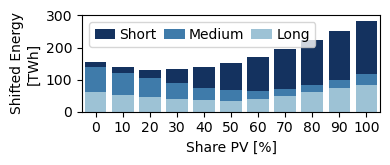

In [61]:
save_dir = "results/plots"
f, a1 = plt.subplots(1, 1, figsize=(4, 1.75))
scenario = "Variation_Generation"
storage_equivalent = pd.read_csv(
        "results/two_weeks/{}/storage_equivalents.csv".format(scenario),
        index_col=0)
parameter = {"share_pv": "Share PV [%]"}
ylabel = "Shifted Energy\n[TWh]"
language = "english"
plot_storage_equivalent_germany_stacked(
            storage_equivalent,
            parameter=parameter,
            ylabel=ylabel,
            loc="upper left",
            language=language,
            ax=a1,
            ylim=(0,301),
        )
a1.set_yticks([0, 100, 200, 300])
a1.set_xticklabels([i*10 for i in range(11)])
plt.tight_layout()
#a1.legend(loc="upper left", ncols=1, columnspacing=0.5, handletextpad=0.3, handlelength=1.5, bbox_to_anchor=(1.0, 0.9))
save_dir_tmp = os.path.join(save_dir, "ga_storage_equivalent_generation.svg")
plt.savefig(save_dir_tmp, bbox_inches='tight')

In [70]:
res_dir = r"H:\Flexibility-Quantification\final_run_paper_v1"
flexible_scenarios = ["EV_flexible", "EV_flexible_with_public", "EV_flexible_with_shifting", "EV_flexible_with_v2g"]
var = "nr_ev"
storage_equivalent_ref, growth, storage_equivalent_flex, diff=load_scenarios_and_diff("EV_reference", flexible_scenarios[0], var, res_dir=res_dir)
storage_equivalent_ref, growth, storage_equivalent_flex_2, diff_2=load_scenarios_and_diff("EV_reference", flexible_scenarios[1], var, res_dir=res_dir)
storage_equivalent_ref, growth, storage_equivalent_flex_3, diff_3=load_scenarios_and_diff("EV_reference", flexible_scenarios[2], var, res_dir=res_dir)
storage_equivalent_ref, growth, storage_equivalent_flex_4, diff_4=load_scenarios_and_diff("EV_reference", flexible_scenarios[3], var, res_dir=res_dir)

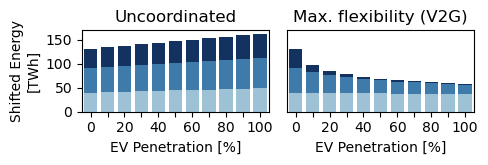

In [71]:
# plot reference and V2G
save_dir = "results/plots"
parameter = {"nr_ev": "Number EVs [Mio.]"}
ylabel = "Shifted Energy\n[TWh]"
language = "english"
fig, axes = plt.subplots(1, 2, figsize=(5, 1.75))
save_dir_tmp = os.path.join(save_dir, "ga_storage_equivalent_EVs_double.svg")
ax = axes[0]
plot_storage_equivalent_germany_stacked(
            storage_equivalent_ref,
            parameter=parameter,
            ylabel=ylabel,
            loc=None,
            language=language,
            ax=ax,
            title="Uncoordinated"
        )
ax = axes[1]
plot_storage_equivalent_germany_stacked(
            storage_equivalent_flex_4,
            parameter=parameter,
            ylabel=ylabel,
            loc="upper right",
            language=language,
            ax=ax,
            title="Max. flexibility (V2G)"
        )
axes[0].set_title("Uncoordinated")
for ax in axes:
    ax.set_xlabel("EV Penetration [%]")
    #ax.set_xticklabels([10*i for i in range(11)])
    ax.set_xticklabels([0, "", 20, "", 40, "", 60, "", 80, "", 100 ])
    ax.set_ylim(0,170)
    ax.set_yticks([0,50,100, 150])
ax = axes[1]
axes[1].legend().remove()
#a1 = ax.twinx()
#a1.set_ylim(ax.get_ylim())
#a1.set_ylabel("~~Shifted Energy \n[\% of Base Case]", rotation=270, labelpad=25)
#a1.yaxis.set_label_position("right")
#a1.yaxis.tick_right()
ax.set_ylabel("")
ax.set_yticks([])
energy_ref = storage_equivalent_ref.groupby("nr_ev").sum().loc[0, "energy_stored"]/1e3
#a1.set_yticks([0, energy_ref/2, energy_ref])
#a1.set_yticklabels([0, 50, 100])
plt.tight_layout()
plt.subplots_adjust(wspace=0.1)
#ax.legend(ncols=3, loc="upper left", columnspacing=0.5, handletextpad=0.3, handlelength=1.5)
plt.savefig(save_dir_tmp)

In [62]:
res_dir = r"C:\Users\aheider\Documents\Software\Flexibility-Quantification\results\final_run_paper_v1"
flexible_scenarios = ["HP_flexible", "HP_flexible_double_TES", "HP_flexible_four_TES"]
var = "nr_hp"
storage_equivalent_ref, growth, storage_equivalent_flex, diff=load_scenarios_and_diff("HP_reference", flexible_scenarios[0], var, res_dir=res_dir)
storage_equivalent_ref, growth, storage_equivalent_flex_2, diff_2=load_scenarios_and_diff("HP_reference", flexible_scenarios[1], var, res_dir=res_dir)
storage_equivalent_ref, growth, storage_equivalent_flex_3, diff_3=load_scenarios_and_diff("HP_reference", flexible_scenarios[2], var, res_dir=res_dir)

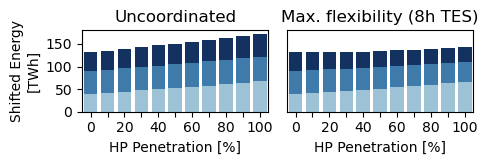

In [68]:
# plot reference and V2G
save_dir = "results/plots"
parameter = {"nr_hp": "Number HPs [Mio.]"}
ylabel = "Shifted Energy\n[TWh]"
language = "english"
fig, axes = plt.subplots(1, 2, figsize=(5, 1.75))
save_dir_tmp = os.path.join(save_dir, "ga_storage_equivalent_HPs_double.svg")
ax = axes[0]
plot_storage_equivalent_germany_stacked(
            storage_equivalent_ref,
            parameter=parameter,
            ylabel=ylabel,
            loc=None,
            language=language,
            ax=ax,
            title="HPs Base"
        )
ax = axes[1]
plot_storage_equivalent_germany_stacked(
            storage_equivalent_flex_3,
            parameter=parameter,
            ylabel=ylabel,
            loc="upper right",
            language=language,
            ax=ax,
            title="Max. flexibility (8h TES)"
        )
axes[0].set_title("Uncoordinated")
for ax in axes:
    ax.set_xlabel("HP Penetration [%]")
    ax.set_xticklabels([0, "", 20, "", 40, "", 60, "", 80, "", 100 ])
    ax.set_ylim(0,180)
    ax.set_yticks([0,50,100,150])
ax = axes[1]
#a1 = ax.twinx()
#a1.set_ylim(ax.get_ylim())
#a1.set_ylabel("~~Shifted Energy \n[\% of Base Case]", rotation=270, labelpad=25)
#a1.yaxis.set_label_position("right")
#a1.yaxis.tick_right()
ax.set_ylabel("")
ax.set_yticks([])
energy_ref = storage_equivalent_ref.groupby("nr_hp").sum().loc[0, "energy_stored"]/1e3
#a1.set_yticks([0, energy_ref/2, energy_ref])
#a1.set_yticklabels([0, 50, 100])
axes[1].legend().remove()
plt.tight_layout()
plt.subplots_adjust(wspace=0.1)
#ax.legend(ncols=3, loc=(-0.55, -0.4), columnspacing=0.5)
#plt.legend(ncols=3, loc=(-0.2, 0.5))
plt.savefig(save_dir_tmp, bbox_inches='tight')

# Main Body

In [5]:
from matplotlib import rc
#rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})
rc('font',**{'family':'serif','serif':['Times'], 'size':12})
rc('text', usetex=True)
import sys 
sys.path.append("C:/APPS/MiKTeX/21.7/fonts/source/public/rsfs")

# 4 Case Study

In [3]:
scenario_dict = base_scenario()
# import HP data
hp_mode = "inflexible"
scenario_dict = scenario_input_hps(scenario_dict=scenario_dict, mode=hp_mode)
nr_hp_mio = 19.4
nr_hp_mio, ts_heat_el, sum_energy_heat, capacity_tes, p_nom_hp, ts_heat_demand = \
            model_input_hps(
                scenario_dict=scenario_dict,
                hp_mode=hp_mode,
                nr_hp_mio=nr_hp_mio
            )
# import EV data
ev_mode = "inflexible"
scenario_dict = scenario_input_evs(scenario_dict=scenario_dict, mode=ev_mode, extended_flex=False)
nr_ev_mio = 48.8
(ref_charging, flexibility_bands) = scale_electric_vehicles(
            nr_ev_mio, scenario_dict)

In [5]:
# Installed capacities (less than here: https://www.diw.de/de/diw_01.c.821878.de/publikationen/wochenberichte/2021_29_1/100_prozent_erneuerbare_energien_fuer_deutschland__koordinierte_ausbauplanung_notwendig.html#table1)
wind_ego = 98.4 + 27
solar_ego = 97.8
scaling = scenario_dict["ts_demand"].sum().sum()/scenario_dict["ts_vres"].sum().sum()
wind_ego*scaling, solar_ego*scaling

(186.33296570178175, 145.32188234158096)

In [22]:
# Installed capacities 2024
wind_ego = 61.2 + 8.5
solar_ego = 83.4
vres = scenario_dict["ts_vres"].copy()
vres["solar"] *= (solar_ego)
vres["wind"] *= (wind_ego)
scaling = scenario_dict["ts_demand"].sum().sum()/vres.sum().sum()
wind_ego*scaling, solar_ego*scaling, vres["solar"].sum()/vres.sum().sum()

(156.8816226938713, 187.71775226210713, 0.41938577380623193)

In [21]:
# Installed capacities 2022
wind_ego = 58 + 8.2
solar_ego = 76.6
vres = scenario_dict["ts_vres"].copy()
vres["solar"] *= (solar_ego)
vres["wind"] *= (wind_ego)
scaling = scenario_dict["ts_demand"].sum().sum()/vres.sum().sum()
wind_ego*scaling, solar_ego*scaling, vres["solar"].sum()/vres.sum().sum()

(159.08163052360456, 184.07330661794725, 0.41124361016879074)

In [20]:
# Installed capacities 2019
wind_ego = 53.2 + 7.5
solar_ego = 48.9
vres = scenario_dict["ts_vres"].copy()
vres["solar"] *= (solar_ego)
vres["wind"] *= (wind_ego)
scaling = scenario_dict["ts_demand"].sum().sum()/vres.sum().sum()
wind_ego*scaling, solar_ego*scaling, vres["solar"].sum()/vres.sum().sum()

(181.79213614425896, 146.45198447206363, 0.3271927033705109)

In [23]:
# end 2023 https://www.bundesnetzagentur.de/SharedDocs/Pressemitteilungen/EN/2024/20240105_EEGZubau.html
wind_ego = 60.9 + 8.5
solar_ego = 81.7
vres = scenario_dict["ts_vres"].copy()
vres["solar"] *= (solar_ego)
vres["wind"] *= (wind_ego)
scaling = scenario_dict["ts_demand"].sum().sum()/vres.sum().sum()
wind_ego*scaling, solar_ego*scaling, vres["solar"].sum()/vres.sum().sum()

(157.95137647695518, 185.94564060759708, 0.41542664682680797)

In [14]:
tmp = scenario_dict["ts_vres"].sum()
tmp["solar"]/tmp.sum()

0.3764266136364324

In [24]:
scenario_dict["ts_demand"].sum().sum()

496122.08453500003

In [6]:
# Installed capacities (less than here: https://www.diw.de/de/diw_01.c.821878.de/publikationen/wochenberichte/2021_29_1/100_prozent_erneuerbare_energien_fuer_deutschland__koordinierte_ausbauplanung_notwendig.html#table1)
wind_ego = 98.4 + 27
solar_ego = 97.8
scaling = scenario_dict["ts_demand"].sum().sum()/scenario_dict["ts_vres"].sum().sum()
wind_ego*scaling, solar_ego*scaling

(21128.540980622034, 16478.240094934885)

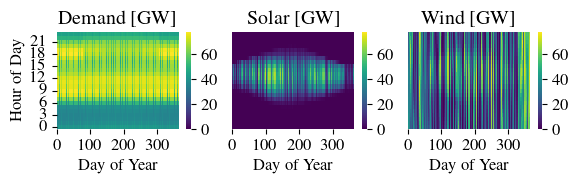

In [7]:
# plot input open_ego
# Todo: Demand minimum at 0, revert y-axis
df_plot = scenario_dict["ts_vres"].copy()
df_plot["Demand"] = scenario_dict["ts_demand"].sum(axis=1)
df_plot["Day of Year"] = df_plot.index.dayofyear
df_plot["Hour of Day"] = df_plot.index.hour
df_plot = df_plot.groupby(["Hour of Day", "Day of Year"]).mean().unstack()
vmax = df_plot[["Demand", "solar", "wind"]].max().max()
figsize = (6,2)
fig, ax =  plt.subplots(1, 3, figsize=figsize)
ticks = [0, 20, 40, 60]
g = sns.heatmap(df_plot["Demand"], cmap='viridis', xticklabels=False, ax=ax[0],
                       cbar=True, linewidths=0, vmin=0, vmax=vmax, cbar_kws={'ticks': ticks})
g.invert_yaxis()
g = sns.heatmap(df_plot["solar"], cmap='viridis', xticklabels=False, ax=ax[1],
                       cbar=True, linewidths=0, vmin=0, vmax=vmax, cbar_kws={'ticks': ticks})
g.invert_yaxis()
g = sns.heatmap(df_plot["wind"], cmap='viridis', xticklabels=False, ax=ax[2],
                       cbar=True, linewidths=0, vmin=0, vmax=vmax, cbar_kws={'ticks': ticks})
g.invert_yaxis()
ax[1].set_ylabel("")
ax[1].set_yticks([])
ax[2].set_ylabel("")
ax[2].set_yticks([])
ax[0].set_yticklabels(ax[0].get_yticklabels(), rotation=0)
ax[0].set_xticks([0,100,200,300], [0,100,200,300])
ax[1].set_xticks([0,100,200,300], [0,100,200,300])
ax[2].set_xticks([0,100,200,300], [0,100,200,300])
ax[0].set_title("Demand [GW]")
ax[1].set_title("Solar [GW]")
ax[2].set_title("Wind [GW]")
plt.tight_layout()
fig.subplots_adjust(wspace=0.15)
plt.savefig("results/plots/paper_dc_ego_input_heatmap.pdf")

In [16]:
scenario_dict["ts_vres"]

wind  solar
2011-01-01 00:00:00  32.79629    0.0
2011-01-01 01:00:00  35.93961    0.0
2011-01-01 02:00:00  39.34750    0.0
2011-01-01 03:00:00  41.61822    0.0
2011-01-01 04:00:00  44.70332    0.0
...                       ...    ...
2011-12-30 19:00:00  33.44207    0.0
2011-12-30 20:00:00  32.41918    0.0
2011-12-30 21:00:00  31.41303    0.0
2011-12-30 22:00:00  30.50777    0.0
2011-12-30 23:00:00  30.24151    0.0

[8736 rows x 2 columns]

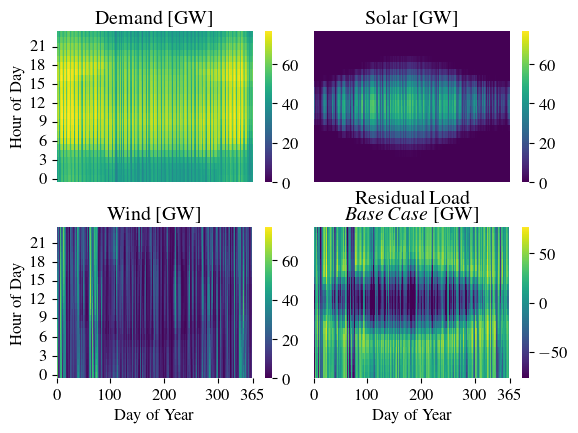

In [7]:
scaling = scenario_dict["ts_demand"].sum().sum()/scenario_dict["ts_vres"].sum().sum()
df_plot = scenario_dict["ts_vres"].copy()
df_plot["Demand"] = scenario_dict["ts_demand"].sum(axis=1)
df_plot["RL"] = scenario_dict["ts_demand"].sum(axis=1) - scenario_dict["ts_vres"].multiply(scaling).sum(axis=1)
df_plot["Day of Year"] = df_plot.index.dayofyear
df_plot["Hour of Day"] = df_plot.index.hour
df_plot = df_plot.groupby(["Hour of Day", "Day of Year"]).mean().unstack()
vmax = df_plot[["Demand", "solar", "wind"]].max().max()
ticks = [0, 20, 40, 60]
figsize = (6, 4.5)
fig, ax =  plt.subplots(2, 2, figsize=figsize)
title1="Demand [GW]"
g = sns.heatmap(df_plot["Demand"], cmap='viridis', xticklabels=False, ax=ax[(0,0)],
                       cbar=True, linewidths=0, vmin=0, vmax=vmax, cbar_kws={'ticks': ticks})
g.invert_yaxis()
ax[(0,0)].set_title(title1)
title2="Solar [GW]"
g = sns.heatmap(df_plot["solar"], cmap='viridis', xticklabels=False, ax=ax[(0,1)],
                       cbar=True, linewidths=0, vmin=0, vmax=vmax, cbar_kws={'ticks': ticks})
g.invert_yaxis()
ax[(0,1)].set_title(title2)
title3="Wind [GW]"
g = sns.heatmap(df_plot["wind"], cmap='viridis', xticklabels=False, ax=ax[(1,0)],
                       cbar=True, linewidths=0, vmin=0, vmax=vmax, cbar_kws={'ticks': ticks})
g.invert_yaxis()
ax[(1,0)].set_title(title3)
title4="~ Residual Load \n $Base~Case$ [GW]"
g = sns.heatmap(df_plot["RL"], cmap='viridis', xticklabels=False, ax=ax[(1,1)],
                       cbar=True, linewidths=0, vmin=-vmax, vmax=vmax)# , vmin=-vmax, vmax=vmax
g.invert_yaxis()
ax[(1,1)].set_title(title4)
ax[(1,1)].set_ylabel("")
ax[(1,1)].set_yticks([])
ax[(0,1)].set_ylabel("")
ax[(0,1)].set_yticks([])
ax[(0,0)].set_yticklabels(ax[(0,0)].get_yticklabels(), rotation=0)
ax[(1,0)].set_yticklabels(ax[(1,0)].get_yticklabels(), rotation=0)
#ax[(0,1)].set_yticklabels(ax[(0,0)].get_yticklabels(), rotation=0)
#ax[(1,1)].set_yticklabels(ax[(1,0)].get_yticklabels(), rotation=0)
ax[(1,0)].set_xticks([0,100,200,300,365], [0,100,200,300,365])
ax[(1,1)].set_xticks([0,100,200,300,365], [0,100,200,300,365])
ax[(0,1)].set_xlabel("")
ax[(0,0)].set_xlabel("")
plt.tight_layout()
fig.subplots_adjust(wspace=0.05, hspace=0.3)
plt.savefig("results/plots/paper_dc_input_heatmap.pdf")

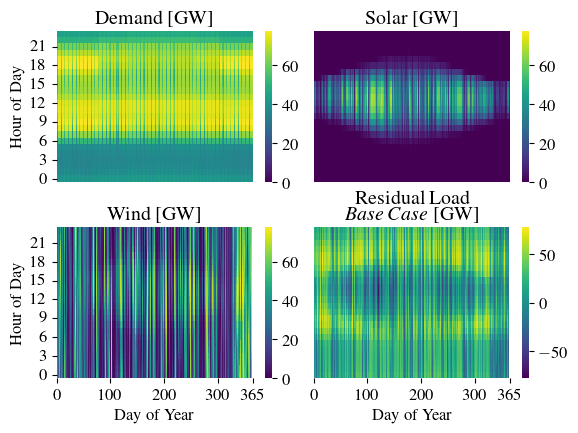

In [6]:
df_plot = scenario_dict["ts_vres"].copy()
df_plot["Demand"] = scenario_dict["ts_demand"].sum(axis=1)
df_plot["RL"] = scenario_dict["ts_demand"].sum(axis=1) - scenario_dict["ts_vres"].sum(axis=1)
df_plot["Day of Year"] = df_plot.index.dayofyear
df_plot["Hour of Day"] = df_plot.index.hour
df_plot = df_plot.groupby(["Hour of Day", "Day of Year"]).mean().unstack()
vmax = df_plot[["Demand", "solar", "wind"]].max().max()
ticks = [0, 20, 40, 60]
figsize = (6, 4.5)
fig, ax =  plt.subplots(2, 2, figsize=figsize)
title1="Demand [GW]"
g = sns.heatmap(df_plot["Demand"], cmap='viridis', xticklabels=False, ax=ax[(0,0)],
                       cbar=True, linewidths=0, vmin=0, vmax=vmax, cbar_kws={'ticks': ticks})
g.invert_yaxis()
ax[(0,0)].set_title(title1)
title2="Solar [GW]"
g = sns.heatmap(df_plot["solar"], cmap='viridis', xticklabels=False, ax=ax[(0,1)],
                       cbar=True, linewidths=0, vmin=0, vmax=vmax, cbar_kws={'ticks': ticks})
g.invert_yaxis()
ax[(0,1)].set_title(title2)
title3="Wind [GW]"
g = sns.heatmap(df_plot["wind"], cmap='viridis', xticklabels=False, ax=ax[(1,0)],
                       cbar=True, linewidths=0, vmin=0, vmax=vmax, cbar_kws={'ticks': ticks})
g.invert_yaxis()
ax[(1,0)].set_title(title3)
title4="~ Residual Load \n $Base~Case$ [GW]"
g = sns.heatmap(df_plot["RL"], cmap='viridis', xticklabels=False, ax=ax[(1,1)],
                       cbar=True, linewidths=0, vmin=-vmax, vmax=vmax)# , vmin=-vmax, vmax=vmax
g.invert_yaxis()
ax[(1,1)].set_title(title4)
ax[(1,1)].set_ylabel("")
ax[(1,1)].set_yticks([])
ax[(0,1)].set_ylabel("")
ax[(0,1)].set_yticks([])
ax[(0,0)].set_yticklabels(ax[(0,0)].get_yticklabels(), rotation=0)
ax[(1,0)].set_yticklabels(ax[(1,0)].get_yticklabels(), rotation=0)
#ax[(0,1)].set_yticklabels(ax[(0,0)].get_yticklabels(), rotation=0)
#ax[(1,1)].set_yticklabels(ax[(1,0)].get_yticklabels(), rotation=0)
ax[(1,0)].set_xticks([0,100,200,300,365], [0,100,200,300,365])
ax[(1,1)].set_xticks([0,100,200,300,365], [0,100,200,300,365])
ax[(0,1)].set_xlabel("")
ax[(0,0)].set_xlabel("")
plt.tight_layout()
fig.subplots_adjust(wspace=0.05, hspace=0.3)
plt.savefig("results/plots/paper_dc_ego_input_heatmap.pdf")

Text(0.5, 0, 'Time of Day')

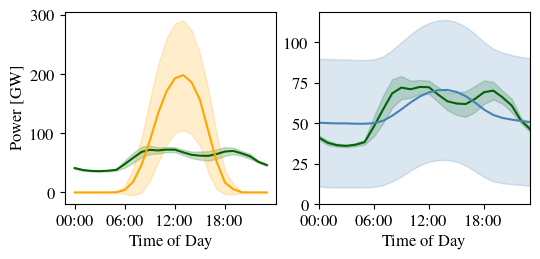

In [24]:
figsize = (6, 2.5)
fig, ax =  plt.subplots(1, 2, figsize=figsize, gridspec_kw={'width_ratios': [1., 1]})
df_plot = scenario_dict["ts_vres"].copy()
df_plot["Demand"] = scenario_dict["ts_demand"].sum(axis=1)
df_plot["solar"] = df_plot["solar"].divide(df_plot["solar"].sum()).multiply(df_plot["Demand"].sum())
df_plot["wind"] = df_plot["wind"].divide(df_plot["wind"].sum()).multiply(df_plot["Demand"].sum())
df_plot["RL"] = scenario_dict["ts_demand"].sum(axis=1) - scenario_dict["ts_vres"].sum(axis=1)
df_plot["Day of Year"] = df_plot.index.dayofyear
df_plot["Hour of Day"] = df_plot.index.hour
sns.lineplot(data=df_plot, x="Hour of Day", y="Demand", errorbar='sd', ax=ax[0], color='Darkgreen')
sns.lineplot(data=df_plot, x="Hour of Day", y="solar", errorbar='sd', ax=ax[0], color='orange')
sns.lineplot(data=df_plot, x="Hour of Day", y="Demand", errorbar='sd', ax=ax[1], color='Darkgreen')
sns.lineplot(data=df_plot, x="Hour of Day", y="wind", errorbar='sd', ax=ax[1], color='Steelblue')
a0=ax[1]
a0.set_xlim(0,23)
ax[1].set_ylim(0,None)
#a0.set_ylim(0,350)
a0.set_xticks([0,6,12,18], ["00:00", "06:00", "12:00", "18:00"])
a0.set_ylabel("")
a0.set_xlabel("Time of Day")
ax[0].set_xticks([0,6,12,18], ["00:00", "06:00", "12:00", "18:00"])
ax[0].set_ylabel("Power [GW]")
ax[0].set_xlabel("Time of Day")

Text(0, 0.5, 'Power [GW]')

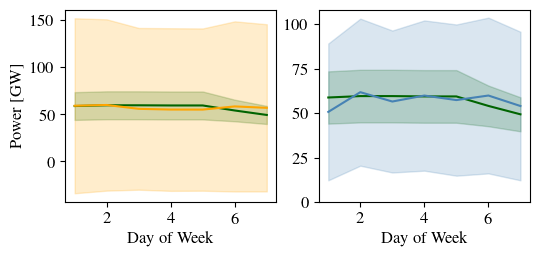

In [34]:
figsize = (6, 2.5)
fig, ax =  plt.subplots(1, 2, figsize=figsize, gridspec_kw={'width_ratios': [1., 1]})
df_plot["Day of Week"] = df_plot.index.weekday+1
sns.lineplot(data=df_plot, x="Day of Week", y="Demand", errorbar='sd', ax=ax[0], color='Darkgreen')
sns.lineplot(data=df_plot, x="Day of Week", y="solar", errorbar='sd', ax=ax[0], color='orange')
sns.lineplot(data=df_plot, x="Day of Week", y="Demand", errorbar='sd', ax=ax[1], color='Darkgreen')
sns.lineplot(data=df_plot, x="Day of Week", y="wind", errorbar='sd', ax=ax[1], color='Steelblue')
a0=ax[1]
ax[1].set_ylim(0,None)
#a0.set_ylim(0,350)
a0.set_ylabel("")
ax[0].set_ylabel("Power [GW]")

Text(0, 0.5, 'Power [GW]')

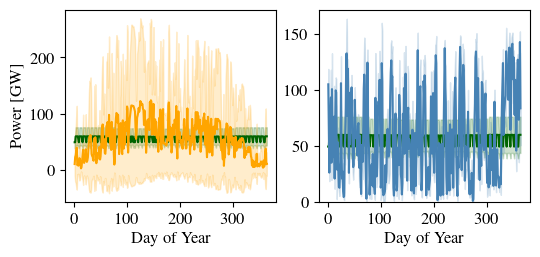

In [36]:
figsize = (6, 2.5)
fig, ax =  plt.subplots(1, 2, figsize=figsize, gridspec_kw={'width_ratios': [1., 1]})
xlabel = "Day of Year"
df_plot[xlabel] = df_plot.index.dayofyear
sns.lineplot(data=df_plot, x=xlabel, y="Demand", errorbar='sd', ax=ax[0], color='Darkgreen')
sns.lineplot(data=df_plot, x=xlabel, y="solar", errorbar='sd', ax=ax[0], color='orange')
sns.lineplot(data=df_plot, x=xlabel, y="Demand", errorbar='sd', ax=ax[1], color='Darkgreen')
sns.lineplot(data=df_plot, x=xlabel, y="wind", errorbar='sd', ax=ax[1], color='Steelblue')
a0=ax[1]
ax[1].set_ylim(0,None)
#a0.set_ylim(0,350)
a0.set_ylabel("")
ax[0].set_ylabel("Power [GW]")

C:\Users\aheider\AppData\Local\Temp\ipykernel_28104\3002207413.py:4: FutureWarning: weekofyear and week have been deprecated, please use DatetimeIndex.isocalendar().week instead, which returns a Series. To exactly reproduce the behavior of week and weekofyear and return an Index, you may call pd.Int64Index(idx.isocalendar().week)
  df_plot[xlabel] = df_plot.index.week


Text(0, 0.5, 'Power [GW]')

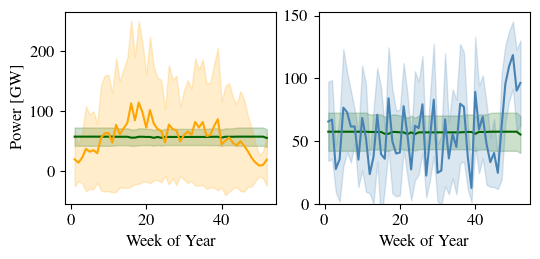

In [37]:
figsize = (6, 2.5)
fig, ax =  plt.subplots(1, 2, figsize=figsize, gridspec_kw={'width_ratios': [1., 1]})
xlabel = "Week of Year"
df_plot[xlabel] = df_plot.index.week
sns.lineplot(data=df_plot, x=xlabel, y="Demand", errorbar='sd', ax=ax[0], color='Darkgreen')
sns.lineplot(data=df_plot, x=xlabel, y="solar", errorbar='sd', ax=ax[0], color='orange')
sns.lineplot(data=df_plot, x=xlabel, y="Demand", errorbar='sd', ax=ax[1], color='Darkgreen')
sns.lineplot(data=df_plot, x=xlabel, y="wind", errorbar='sd', ax=ax[1], color='Steelblue')
a0=ax[1]
ax[1].set_ylim(0,None)
#a0.set_ylim(0,350)
a0.set_ylabel("")
ax[0].set_ylabel("Power [GW]")

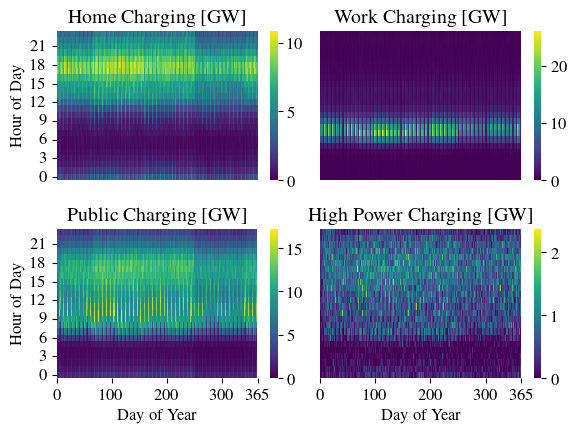

In [32]:
df_plot = ref_charging.copy()
df_plot["Day of Year"] = df_plot.index.dayofyear
df_plot["Hour of Day"] = df_plot.index.hour
df_plot = df_plot.groupby(["Hour of Day", "Day of Year"]).mean().unstack()
figsize = (6, 4.5)
fig, ax =  plt.subplots(2, 2, figsize=figsize)
title1="Home Charging [GW]"
g = sns.heatmap(df_plot["home"], cmap='viridis', xticklabels=False, ax=ax[(0,0)],
                       cbar=True, linewidths=0, vmin=0)
g.invert_yaxis()
ax[(0,0)].set_title(title1)
title2="Work Charging [GW]"
g = sns.heatmap(df_plot["work"], cmap='viridis', xticklabels=False, ax=ax[(0,1)],
                       cbar=True, linewidths=0, vmin=0)
g.invert_yaxis()
ax[(0,1)].set_title(title2)
title3="Public Charging [GW]"
g = sns.heatmap(df_plot["public"], cmap='viridis', xticklabels=False, ax=ax[(1,0)],
                       cbar=True, linewidths=0, vmin=0)
g.invert_yaxis()
ax[(1,0)].set_title(title3)
title4="High Power Charging [GW]"
g = sns.heatmap(df_plot["hpc"], cmap='viridis', xticklabels=False, ax=ax[(1,1)],
                       cbar=True, linewidths=0, vmin=0)
g.invert_yaxis()
ax[(1,1)].set_title(title4)
ax[(1,1)].set_ylabel("")
ax[(1,1)].set_yticks([])
ax[(0,1)].set_ylabel("")
ax[(0,1)].set_yticks([])
ax[(0,0)].set_yticklabels(ax[(0,0)].get_yticklabels(), rotation=0)
ax[(1,0)].set_yticklabels(ax[(1,0)].get_yticklabels(), rotation=0)
#ax[(0,1)].set_yticklabels(ax[(0,0)].get_yticklabels(), rotation=0)
#ax[(1,1)].set_yticklabels(ax[(1,0)].get_yticklabels(), rotation=0)
ax[(1,0)].set_xticks([0,100,200,300,365], [0,100,200,300,365])
ax[(1,1)].set_xticks([0,100,200,300,365], [0,100,200,300,365])
ax[(0,1)].set_xlabel("")
ax[(0,0)].set_xlabel("")
plt.tight_layout()
fig.subplots_adjust(wspace=0.05)
plt.savefig("results/plots/paper_dc_evs_heatmap.pdf")

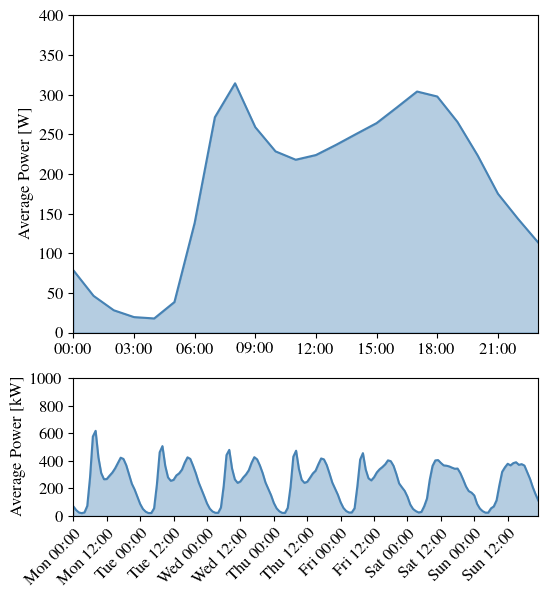

In [153]:
fig, (a0, a1) = plt.subplots(2,1, figsize=(6, 6.5), gridspec_kw={'height_ratios': [2.3, 1]})
df_plot = pd.DataFrame()
df_plot["Power [W]"] = ref_charging.sum(axis=1)
df_plot["Hour of Day"] = df_plot.index.hour
df_plot = df_plot.groupby(["Hour of Day"]).mean()
df_plot = df_plot.divide(df_plot.sum()).multiply(4440)
df_plot.plot(ax=a0, legend=False, color='SteelBlue')
a0.fill_between(df_plot.index,df_plot["Power [W]"], alpha=0.4, color='SteelBlue')
a0.set_xlim(0,23)
a0.set_ylim(0,400)
a0.set_xticks([0,3,6,9,12,15,18,21], ["00:00", "03:00", "06:00", "09:00", "12:00", "15:00", "18:00", "21:00"])
a0.set_ylabel("Average Power [W]")
a0.set_xlabel("")
df_plot = pd.DataFrame()
df_plot["Power [W]"] = ref_charging.sum(axis=1)
df_plot.index = pd.date_range(start="2029-01-01", freq="1h", periods=(len(df_plot)))
df_plot["Hour of Day"] = df_plot.index.hour
df_plot["Day of Week"] = df_plot.index.weekday
df_plot = df_plot.groupby(["Day of Week", "Hour of Day"]).sum()
consumption_ref = 41051
df_plot= df_plot.divide(df_plot.sum()).multiply(consumption_ref).reset_index()
df_plot["Power [W]"].plot(ax=a1, color='SteelBlue')
a1.fill_between(df_plot["Power [W]"].index,df_plot["Power [W]"], alpha=0.4, color='SteelBlue')
a1.set_xlim(0,167)
a1.set_ylim(0,1000)
a1.set_yticks([0,200,400,600,800,1000])
a1.set_xticks([i*12 for i in range(14)], ["Mon 00:00", "Mon 12:00", "Tue 00:00", "Tue 12:00", "Wed 00:00", "Wed 12:00", 
                                         "Thu 00:00", "Thu 12:00", "Fri 00:00", "Fri 12:00", "Sat 00:00", "Sat 12:00", 
                                         "Sun 00:00", "Sun 12:00", ], rotation=45, ha="right", rotation_mode='anchor')
a1.set_ylabel("Average Power [kW]", ha="center")
plt.savefig("results/plots/charging_patterns.pdf")

In [147]:
df_plot

Day of Week  Hour of Day   Power [W]
0              0            0   69.459291
1              0            1   42.388094
2              0            2   25.045734
3              0            3   20.086800
4              0            4   25.238466
..           ...          ...         ...
163            6           19  317.241584
164            6           20  269.393404
165            6           21  208.586738
166            6           22  157.075448
167            6           23  111.348509

[168 rows x 3 columns]

In [24]:
grid_ids = [177]
grid_dir = r"H:\Flexibility-Quantification"
for grid_id in grid_ids:
    flexibility_bands_work = \
        pd.read_csv('{}/ev_flexibility_bands_{}_work_00.csv'.format(grid_dir, grid_id), index_col=0,
                    dtype=np.float16, parse_dates=True)
bands = flexibility_bands_work.set_index(pd.date_range('2029-01-01', '2029-01-08', freq='15min'))

In [8]:
colors_sns = sns.color_palette("Paired")
colors_sns

[(0.6509803921568628, 0.807843137254902, 0.8901960784313725),
 (0.12156862745098039, 0.47058823529411764, 0.7058823529411765),
 (0.6980392156862745, 0.8745098039215686, 0.5411764705882353),
 (0.2, 0.6274509803921569, 0.17254901960784313),
 (0.984313725490196, 0.6039215686274509, 0.6),
 (0.8901960784313725, 0.10196078431372549, 0.10980392156862745),
 (0.9921568627450981, 0.7490196078431373, 0.43529411764705883),
 (1.0, 0.4980392156862745, 0.0),
 (0.792156862745098, 0.6980392156862745, 0.8392156862745098),
 (0.41568627450980394, 0.23921568627450981, 0.6039215686274509),
 (1.0, 1.0, 0.6),
 (0.6941176470588235, 0.34901960784313724, 0.1568627450980392)]

C:\Users\aheider\AppData\Local\Temp\ipykernel_11516\2171276683.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bands_tmp[l_min_p] = 0
C:\Users\aheider\AppData\Local\Temp\ipykernel_11516\2171276683.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bands_tmp.rename(columns={'lower_'+cp:l_min_e, 'upper_'+cp:l_max_e, 'power_'+cp:l_max_p}, inplace=True)
C:\Users\aheider\AppData\Local\Temp\ipykernel_11516\2171276683.py:32: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(days)


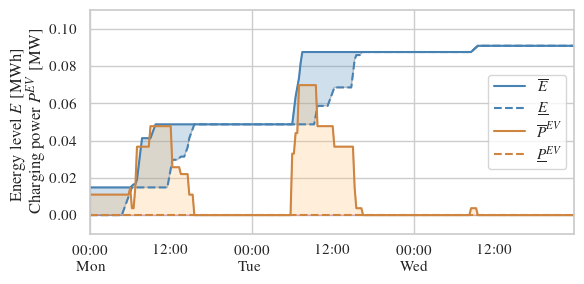

In [10]:
sns.set()
sns.set_style("whitegrid")
#rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})
rc('font',**{'family':'serif','serif':['Times'], 'size':12})
rc('text', usetex=True)
# load data
cp = '8115054_0'
l_min_p = r"$\underline{P}^{EV}$"
l_max_p = r"$\overline{P}^{EV}$"
l_min_e = r"$\underline{E}$"
l_max_e = r"$\overline{E}$"
linestyles=["solid", "dashed", "solid", "dashed"]
figsize = (6, 3)
bands_tmp = bands[bands.columns[bands.columns.str.contains(cp)]]
bands_tmp[l_min_p] = 0
bands_tmp.rename(columns={'lower_'+cp:l_min_e, 'upper_'+cp:l_max_e, 'power_'+cp:l_max_p}, inplace=True)
ax=bands_tmp.iloc[:3*4*24].plot(figsize=figsize, color=['SteelBlue', 'SteelBlue','Peru', 'Peru'], 
                                legend="center right")
i=0
for l in ax.lines:
    l.set_linestyle(linestyles[i])
    i += 1
plt.legend(loc="center right")
ax.fill_between(bands_tmp.index, bands_tmp[l_min_e], 
                bands_tmp[l_max_e],facecolor='SteelBlue', alpha=0.25,edgecolor='k')

ax.fill_between(bands_tmp.index, bands_tmp[l_min_p], 
                bands_tmp[l_max_p],facecolor=colors_sns[6], alpha=0.25, edgecolor='Crimson')
ylim = plt.ylim()
plt.ylim([-0.01, 0.11])
days = ['00:00\n~Mon','00:00\n~Tue', '00:00\n~Wed']
ax.set_xticklabels(days)
ylabels = ax.get_yticklabels()
ax.set_ylabel('~~~Energy level $E$ [MWh]\nCharging power $P^{EV}$ [MW]')
#ax.set_yticklabels([0,0,50,100,''])
plt.tight_layout()
#ax.set_xlim(0,250)
plt.savefig('results/plots/energy_bands.pdf')

C:\Users\aheider\AppData\Local\Temp\ipykernel_25480\2741810729.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bands_tmp[l_min_p] = 0
C:\Users\aheider\AppData\Local\Temp\ipykernel_25480\2741810729.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bands_tmp.rename(columns={'lower_'+cp:l_min_e, 'upper_'+cp:l_max_e, 'power_'+cp:l_max_p}, inplace=True)
C:\Users\aheider\AppData\Local\Temp\ipykernel_25480\2741810729.py:32: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(days)


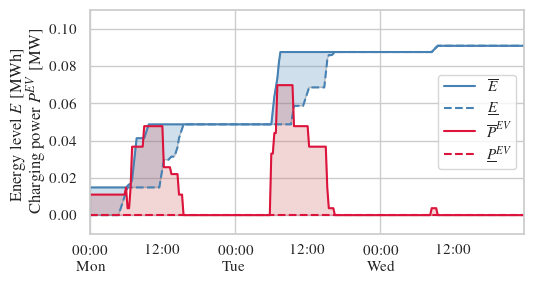

In [27]:
sns.set()
sns.set_style("whitegrid")
#rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})
rc('font',**{'family':'serif','serif':['Times'], 'size':12})
rc('text', usetex=True)
# load data
cp = '8115054_0'
l_min_p = r"$\underline{P}^{EV}$"
l_max_p = r"$\overline{P}^{EV}$"
l_min_e = r"$\underline{E}$"
l_max_e = r"$\overline{E}$"
linestyles=["solid", "dashed", "solid", "dashed"]
figsize = (5.5, 3)
bands_tmp = bands[bands.columns[bands.columns.str.contains(cp)]]
bands_tmp[l_min_p] = 0
bands_tmp.rename(columns={'lower_'+cp:l_min_e, 'upper_'+cp:l_max_e, 'power_'+cp:l_max_p}, inplace=True)
ax=bands_tmp.iloc[:3*4*24].plot(figsize=figsize, color=['SteelBlue', 'SteelBlue','Crimson', 'Crimson'], 
                                legend="center right")
i=0
for l in ax.lines:
    l.set_linestyle(linestyles[i])
    i += 1
plt.legend(loc="center right")
ax.fill_between(bands_tmp.index, bands_tmp[l_min_e], 
                bands_tmp[l_max_e],facecolor='SteelBlue', alpha=0.25,edgecolor='k')

ax.fill_between(bands_tmp.index, bands_tmp[l_min_p], 
                bands_tmp[l_max_p],facecolor='IndianRed', alpha=0.25, edgecolor='Crimson')
ylim = plt.ylim()
plt.ylim([-0.01, 0.11])
days = ['00:00\n~Mon','00:00\n~Tue', '00:00\n~Wed']
ax.set_xticklabels(days)
ylabels = ax.get_yticklabels()
ax.set_ylabel('~~~Energy level $E$ [MWh]\nCharging power $P^{EV}$ [MW]')
#ax.set_yticklabels([0,0,50,100,''])
plt.tight_layout()
#ax.set_xlim(0,250)
plt.savefig('results/plots/diss_energy_bands.pdf')

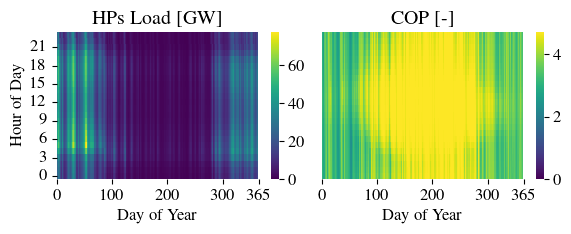

In [10]:
df_plot = pd.DataFrame()
title1 = "HPs Load [GW]"
title2 = "COP [-]"
df_plot[title1] = ts_heat_el
df_plot[title2] = scenario_dict["ts_cop"]
df_plot["Day of Year"] = df_plot.index.dayofyear
df_plot["Hour of Day"] = df_plot.index.hour
df_plot = df_plot.groupby(["Hour of Day", "Day of Year"]).mean().unstack()
figsize = (6, 2.5)
fig, ax =  plt.subplots(1, 2, figsize=figsize)
g = sns.heatmap(df_plot[title1], cmap='viridis', xticklabels=False, ax=ax[0],
                       cbar=True, vmin=0, linewidths=0)
g.invert_yaxis()
g = sns.heatmap(df_plot[title2], cmap='viridis', xticklabels=False, ax=ax[1],
                       cbar=True, vmin=0, linewidths=0)
g.invert_yaxis()
ax[1].set_ylabel("")
ax[1].set_yticks([])
ax[0].set_yticklabels(ax[0].get_yticklabels(), rotation=0)
ax[0].set_xticks([0,100,200,300,365], [0,100,200,300,365])
ax[1].set_xticks([0,100,200,300,365], [0,100,200,300,365])
ax[0].set_title(title1)
ax[1].set_title(title2)
plt.tight_layout()
fig.subplots_adjust(wspace=0.05)
plt.savefig("results/plots/paper_dc_hps_heatmap.pdf")

In [11]:
ts_heat_el.sum()

118058.76963593441

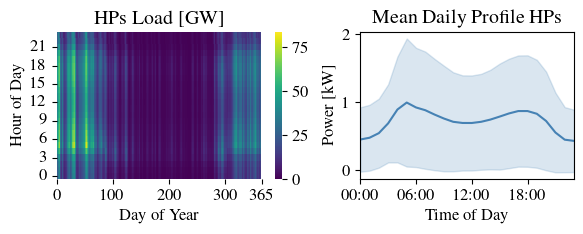

In [22]:
df_plot = pd.DataFrame()
title1 = "HPs Load [GW]"
title2 = "Mean Daily Profile HPs"
df_plot[title1] = ts_heat_el
df_plot["Day of Year"] = df_plot.index.dayofyear
df_plot["Hour of Day"] = df_plot.index.hour
df_plot = df_plot.groupby(["Hour of Day", "Day of Year"]).mean().unstack()
figsize = (6, 2.5)
fig, ax =  plt.subplots(1, 2, figsize=figsize, gridspec_kw={'width_ratios': [1.2, 1]})
g = sns.heatmap(df_plot[title1], cmap='viridis', xticklabels=False, ax=ax[0],
                       cbar=True, vmin=0, linewidths=0)
g.invert_yaxis()
ax[0].set_yticklabels(ax[0].get_yticklabels(), rotation=0)
ax[0].set_xticks([0,100,200,300,365], [0,100,200,300,365])
ax[0].set_title(title1)
# plot heat pump load with standard deviation (or 25, 75 percentiles?)
df_plot = pd.DataFrame()
df_plot["Power [kW]"] = ts_heat_el.divide(19.4)
df_plot["Hour of Day"] = df_plot.index.hour
sns.lineplot(data=df_plot, x="Hour of Day", y="Power [kW]", errorbar='sd', ax=ax[1], color='SteelBlue')
a0=ax[1]
a0.set_xlim(0,23)
#a0.set_ylim(0,350)
a0.set_xticks([0,6,12,18], ["00:00", "06:00", "12:00", "18:00"])
a0.set_ylabel("Power [kW]")
a0.set_xlabel("Time of Day")
ax[1].set_title(title2)
plt.tight_layout()
fig.subplots_adjust(wspace=0.2)
#plt.savefig("results/plots/diss_hp_profiles.pdf")

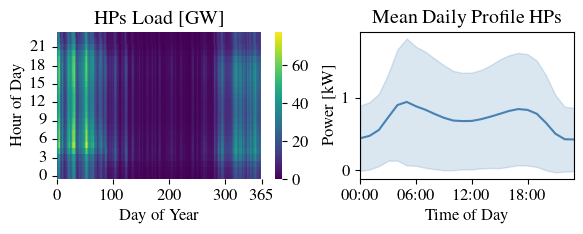

In [9]:
df_plot = pd.DataFrame()
title1 = "HPs Load [GW]"
title2 = "Mean Daily Profile HPs"
df_plot[title1] = ts_heat_el
df_plot["Day of Year"] = df_plot.index.dayofyear
df_plot["Hour of Day"] = df_plot.index.hour
df_plot = df_plot.groupby(["Hour of Day", "Day of Year"]).mean().unstack()
figsize = (6, 2.5)
fig, ax =  plt.subplots(1, 2, figsize=figsize, gridspec_kw={'width_ratios': [1.2, 1]})
g = sns.heatmap(df_plot[title1], cmap='viridis', xticklabels=False, ax=ax[0],
                       cbar=True, vmin=0, linewidths=0)
g.invert_yaxis()
ax[0].set_yticklabels(ax[0].get_yticklabels(), rotation=0)
ax[0].set_xticks([0,100,200,300,365], [0,100,200,300,365])
ax[0].set_title(title1)
# plot heat pump load with standard deviation (or 25, 75 percentiles?)
df_plot = pd.DataFrame()
df_plot["Power [kW]"] = ts_heat_el.divide(19.4)
df_plot["Hour of Day"] = df_plot.index.hour
sns.lineplot(data=df_plot, x="Hour of Day", y="Power [kW]", errorbar='sd', ax=ax[1], color='SteelBlue')
a0=ax[1]
a0.set_xlim(0,23)
#a0.set_ylim(0,350)
a0.set_xticks([0,6,12,18], ["00:00", "06:00", "12:00", "18:00"])
a0.set_ylabel("Power [kW]")
a0.set_xlabel("Time of Day")
ax[1].set_title(title2)
plt.tight_layout()
fig.subplots_adjust(wspace=0.2)
plt.savefig("results/plots/diss_hp_profiles.pdf")

In [8]:
df_plot.max()

Power [kW]      4.00373
Hour of Day    23.00000
dtype: float64

In [11]:
df_plot.max()

Power [W]       4.310457
Hour of Day    23.000000
dtype: float64

In [9]:
def get_years_dict(mode):
    if mode == "generation":
        years_dict = {
            "ego": [2011],
            "rn": [year for year in range(1980, 2020)]
        }
    elif mode == "demand":
        years_dict = {
            "ego": [2011],
            "entso": [year for year in range(2013, 2023)]
        }
    else:
        raise ValueError("mode not correct")
    return years_dict

In [5]:
base_values = base_scenario(vres_data_source="ego", year=2011)
vres_energy = base_values["ts_vres"].sum().sum()
solar_energy = base_values["ts_vres"].solar.sum()
print(f"ego-2011 has a share of {solar_energy/vres_energy*100}% solar.")
total_demand = base_values["ts_demand"].sum().sum()
print(f"ego-2011 has a total demand of {total_demand} GWh")

ego-2011 has a share of 28.177566872349658% solar.
ego-2011 has a total demand of 499299.467829801 GWh


In [54]:
pip install openpyxl

     -------------------------------------- 250.0/250.0 kB 5.2 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


In [20]:
mode = "demand"
years_dict = get_years_dict(mode)
demand = pd.DataFrame()
for data_source in years_dict.keys():
    for year in years_dict[data_source]:
        if mode == "generation":
            scenario_dict = base_scenario(vres_data_source=data_source, year=year)
        elif mode == "demand":
            scenario_dict = base_scenario(demand_data_source=data_source, year=year)
        else:
            raise ValueError("Mode not defined")
        scenario_dict = adjust_timeseries_data(scenario_dict)
        demand[f"{data_source}-{year}"] = scenario_dict["ts_demand"].sum(axis=1)
        total_demand = scenario_dict["ts_demand"].sum().sum()/1e3
        print(f"{data_source}-{year} has a total demand of {total_demand} TWh")

ego-2011 has a total demand of 499.299467829801 TWh
entso-2013 has a total demand of 462.34566099999995 TWh
entso-2014 has a total demand of 451.55200299999996 TWh
entso-2015 has a total demand of 499.0551382025 TWh
entso-2016 has a total demand of 500.60744001 TWh
entso-2017 has a total demand of 504.55102010249993 TWh
entso-2018 has a total demand of 507.990561775 TWh
entso-2019 has a total demand of 496.12208453500006 TWh
entso-2020 has a total demand of 482.852027665 TWh
entso-2021 has a total demand of 503.306908115 TWh
entso-2022 has a total demand of 482.5258484874999 TWh


In [16]:
mode = "demand"
years_dict = get_years_dict(mode)
demand = pd.DataFrame()
for data_source in years_dict.keys():
    for year in years_dict[data_source]:
        if mode == "generation":
            scenario_dict = base_scenario(vres_data_source=data_source, year_generation=year)
        elif mode == "demand":
            scenario_dict = base_scenario(demand_data_source=data_source, year_load=year)
        else:
            raise ValueError("Mode not defined")
        scenario_dict = adjust_timeseries_data(scenario_dict)
        demand[f"{data_source}-{year}"] = scenario_dict["ts_demand"].sum(axis=1)
        total_demand = scenario_dict["ts_demand"].sum().sum()/1e3
        print(f"{data_source}-{year} has a total demand of {total_demand} TWh")

ego-2011 has a total demand of 499.299467829801 TWh
entso-2013 has a total demand of 465.02679099999995 TWh
entso-2014 has a total demand of 456.1055545 TWh
entso-2015 has a total demand of 499.0551382025 TWh
entso-2016 has a total demand of 500.60744001 TWh
entso-2017 has a total demand of 504.55102010249993 TWh
entso-2018 has a total demand of 507.990561775 TWh
entso-2019 has a total demand of 496.12208453500006 TWh
entso-2020 has a total demand of 482.852027665 TWh
entso-2021 has a total demand of 503.306908115 TWh
entso-2022 has a total demand of 482.5258484874999 TWh


<AxesSubplot: >

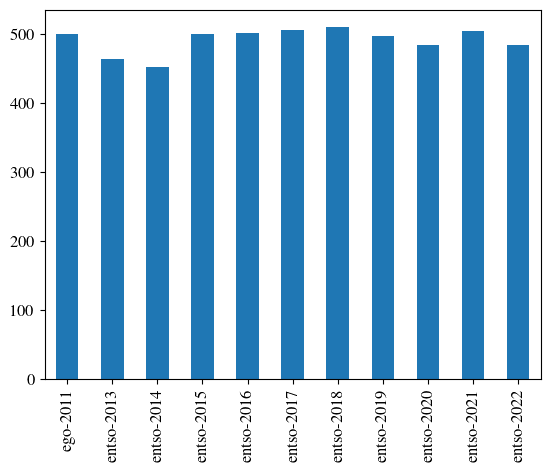

In [14]:
demand.sum().divide(364*1000).multiply(365).plot.bar()

<AxesSubplot: >

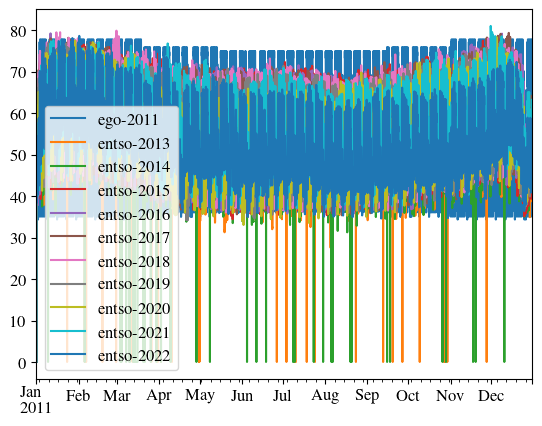

In [21]:
demand.plot()

In [19]:
tmp = demand.iloc[1:]
tmp[tmp==0].dropna(how="all").dropna(how="all",axis=1)

entso-2013  entso-2014
2011-01-09 14:00:00         NaN         0.0
2011-01-23 14:00:00         0.0         NaN
2011-02-05 12:00:00         0.0         0.0
2011-02-06 13:00:00         0.0         NaN
2011-02-18 12:00:00         0.0         NaN
...                         ...         ...
2011-10-29 15:00:00         0.0         NaN
2011-11-17 12:00:00         NaN         0.0
2011-11-19 10:00:00         NaN         0.0
2011-11-27 12:00:00         0.0         NaN
2011-12-10 11:00:00         NaN         0.0

[124 rows x 2 columns]

In [42]:
mode = "generation"
years_dict = get_years_dict(mode)
if mode == "generation":
    years_dict = {
        "ego": [2011],
        "rn": [year for year in range(1980, 2020)]
    }
elif mode == "demand":
    years_dict = {
        "ego": [2011],
        "entso": [year for year in range(2015, 2023)]
    }
else:
    raise ValueError("mode not correct")
generation = pd.DataFrame()
wind = pd.DataFrame()
solar = pd.DataFrame()
for data_source in years_dict.keys():
    for year in years_dict[data_source]:
        if mode == "generation":
            scenario_dict = base_scenario(vres_data_source=data_source, year=year)
        elif mode == "demand":
            scenario_dict = base_scenario(demand_data_source=data_source, year=year)
        else:
            raise ValueError("Mode not defined")
        scenario_dict = adjust_timeseries_data(scenario_dict)
        generation[f"{data_source}-{year}"] = scenario_dict["ts_vres"].sum(axis=1)
        wind[f"{data_source}-{year}"] = scenario_dict["ts_vres"]["wind"]
        solar[f"{data_source}-{year}"] = scenario_dict["ts_vres"]["solar"]
        vres_energy = scenario_dict["ts_vres"].sum().sum()
        solar_energy = scenario_dict["ts_vres"].solar.sum()
        print(f"{data_source}-{year} has a share of {solar_energy/vres_energy*100}% solar.")

ego-2011 has a share of 28.177566872349658% solar.
rn-1980 has a share of 36.269435952764226% solar.
rn-1981 has a share of 35.633513918090856% solar.
rn-1982 has a share of 39.411474278118966% solar.
rn-1983 has a share of 34.135421532695844% solar.
rn-1984 has a share of 36.78515083216833% solar.
rn-1985 has a share of 38.217815036594246% solar.
rn-1986 has a share of 35.887289382618285% solar.
rn-1987 has a share of 38.53105983008977% solar.
rn-1988 has a share of 33.83630178370365% solar.
rn-1989 has a share of 38.03918832476544% solar.
rn-1990 has a share of 34.39580721004486% solar.
rn-1991 has a share of 38.909907660755906% solar.
rn-1992 has a share of 35.37821091153175% solar.
rn-1993 has a share of 36.51985634145944% solar.
rn-1994 has a share of 34.89848327296905% solar.
rn-1995 has a share of 36.104808872643204% solar.
rn-1996 has a share of 41.48347646289159% solar.
rn-1997 has a share of 39.332010856770935% solar.
rn-1998 has a share of 33.82034058745938% solar.
rn-1999 h

In [11]:
mode = "generation"
years_dict = get_years_dict(mode)
if mode == "generation":
    years_dict = {
        "ego": [2011],
        "rn": [year for year in range(1980, 2020)]
    }
elif mode == "demand":
    years_dict = {
        "ego": [2011],
        "entso": [year for year in range(2015, 2023)]
    }
else:
    raise ValueError("mode not correct")
generation = pd.DataFrame()
wind = pd.DataFrame()
solar = pd.DataFrame()
for data_source in years_dict.keys():
    for year in years_dict[data_source]:
        if mode == "generation":
            scenario_dict = base_scenario(vres_data_source=data_source, year_generation=year)
        elif mode == "demand":
            scenario_dict = base_scenario(demand_data_source=data_source, year_load=year)
        else:
            raise ValueError("Mode not defined")
        scenario_dict = adjust_timeseries_data(scenario_dict)
        generation[f"{data_source}-{year}"] = scenario_dict["ts_vres"].sum(axis=1)
        wind[f"{data_source}-{year}"] = scenario_dict["ts_vres"]["wind"]
        solar[f"{data_source}-{year}"] = scenario_dict["ts_vres"]["solar"]
        vres_energy = scenario_dict["ts_vres"].sum().sum()
        solar_energy = scenario_dict["ts_vres"].solar.sum()
        print(f"{data_source}-{year} has a share of {solar_energy/vres_energy*100}% solar.")

ego-2011 has a share of 28.177566872349658% solar.
rn-1980 has a share of 39.85250357288893% solar.
rn-1981 has a share of 39.18413461559045% solar.
rn-1982 has a share of 43.07921971775699% solar.
rn-1983 has a share of 37.6424097265375% solar.
rn-1984 has a share of 40.34870836480653% solar.
rn-1985 has a share of 41.88116590041563% solar.
rn-1986 has a share of 39.43218701328533% solar.
rn-1987 has a share of 42.175693270247244% solar.
rn-1988 has a share of 37.304827935138455% solar.
rn-1989 has a share of 41.636730365706995% solar.
rn-1990 has a share of 37.91348600657348% solar.
rn-1991 has a share of 42.55040999855073% solar.
rn-1992 has a share of 38.923031773225595% solar.
rn-1993 has a share of 40.13494599572539% solar.
rn-1994 has a share of 38.46194070796333% solar.
rn-1995 has a share of 39.70380810094865% solar.
rn-1996 has a share of 45.15424944454177% solar.
rn-1997 has a share of 43.029424632235276% solar.
rn-1998 has a share of 37.30830526957288% solar.
rn-1999 has a 

In [95]:
solar.sum().divide(wind.sum()+solar.sum()).mean()

0.3739601286048286

In [ ]:
generation = generation.divide(generation.sum()).multiply(generation["ego-2011"].sum())

C:\Users\aheider\AppData\Local\Temp\ipykernel_25920\2718325699.py:10: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[1].set_xticklabels([txt.get_text().replace("\n2011", "") for txt in axes[1].get_xticklabels("")])


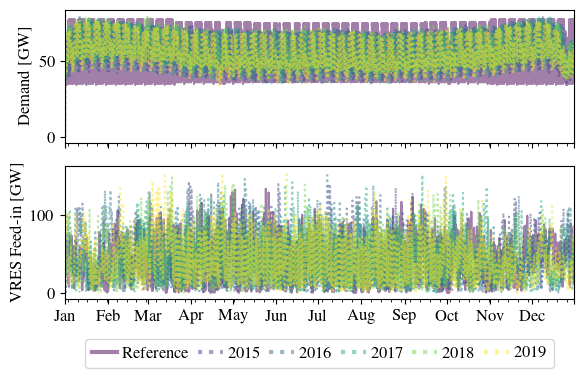

In [16]:
figsize = (6, 3.5)
fig, axes =  plt.subplots(2, 1, figsize=figsize)
demand[["ego-2011", "entso-2015", "entso-2016", "entso-2017", "entso-2018", "entso-2019"]].plot(
    ax=axes[0], style=["-",  ':' , ':',  ':' , ':' , ':',  ':'], alpha=0.5, cmap='viridis', legend=False)
axes[0].set_ylabel("Demand [GW]")
axes[0].set_xticklabels([])
generation[["ego-2011", "rn-2015", "rn-2016", "rn-2017", "rn-2018", "rn-2019"]].plot(
    ax=axes[1], style=["-",  ':' , ':',  ':' , ':' , ':',  ':'], alpha=0.5, cmap='viridis', legend=False)
axes[1].set_ylabel("VRES Feed-in [GW]")
axes[1].set_xticklabels([txt.get_text().replace("\n2011", "") for txt in axes[1].get_xticklabels("")])
plt.tight_layout()
leg = axes[0].legend(["Reference", "2015", "2016", "2017", "2018", "2019"], ncols=6, loc="lower center", bbox_to_anchor=(0.5, -1.75),
               columnspacing=0.5, handletextpad=0.3, handlelength=1.5)
# set the linewidth of each legend object
for legobj in leg.legendHandles:
    legobj.set_linewidth(3.0)
plt.savefig("results/plots/timeseries_variation.pdf", bbox_inches='tight')

In [15]:
demand

ego-2011  entso-2013  entso-2014  entso-2015  \
2011-01-01 00:00:00   0.000000    0.000000    0.000000    0.000000   
2011-01-01 01:00:00  41.612145   41.653958   41.653958   41.653958   
2011-01-01 02:00:00  37.885423   40.113580   40.113580   40.113580   
2011-01-01 03:00:00  35.672131   39.312937   39.312937   39.312937   
2011-01-01 04:00:00  34.731638   39.097163   39.097163   39.097163   
...                        ...         ...         ...         ...   
2011-12-30 20:00:00  76.615674   56.012905   56.012905   56.012905   
2011-12-30 21:00:00  69.508749   53.738318   53.738318   53.738318   
2011-12-30 22:00:00  62.313207   52.204352   52.204352   52.204352   
2011-12-30 23:00:00  49.763040   48.736055   48.736055   48.736055   
2011-12-31 00:00:00  44.518146   45.457217   45.457217   45.457217   

                     entso-2016  entso-2017  entso-2018  entso-2019  \
2011-01-01 00:00:00    0.000000    0.000000    0.000000    0.000000   
2011-01-01 01:00:00   41.653958   41.653958   41.653958   41.653958   
2011-01-01 02:00:00   40.113580   40.113580   40.113580   40.113580   
2011-01-01 03:00:00   39.312937   39.312937   39.312937   39.312937   
2011-01-01 04:00:00   39.097163   39.097163   39.097163   39.097163   
...                         ...         ...         ...         ...   
2011-12-30 20:00:00   56.012905   56.012905   56.012905   56.012905   
2011-12-30 21:00:00   53.738318   53.738318   53.738318   53.738318   
2011-12-30 22:00:00   52.204352   52.204352   52.204352   52.204352   
2011-12-30 23:00:00   48.736055   48.736055   48.736055   48.736055   
2011-12-31 00:00:00   45.457217   45.457217   45.457217   45.457217   

                     entso-2020  entso-2021  entso-2022  
2011-01-01 00:00:00    0.000000    0.000000    0.000000  
2011-01-01 01:00:00   41.653958   41.653958   41.653958  
2011-01-01 02:00:00   40.113580   40.113580   40.113580  
2011-01-01 03:00:00   39.312937   39.312937   39.312937  
2011-01-01 04:00:00   39.097163   39.097163   39.097163  
...                         ...         ...         ...  
2011-12-30 20:00:00   56.012905   56.012905   56.012905  
2011-12-30 21:00:00   53.738318   53.738318   53.738318  
2011-12-30 22:00:00   52.204352   52.204352   52.204352  
2011-12-30 23:00:00   48.736055   48.736055   48.736055  
2011-12-31 00:00:00   45.457217   45.457217   45.457217  

[8737 rows x 11 columns]

C:\Users\aheider\AppData\Local\Temp\ipykernel_22796\2759296746.py:10: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[1].set_xticklabels([txt.get_text().replace("\n2011", "") for txt in axes[1].get_xticklabels("")])


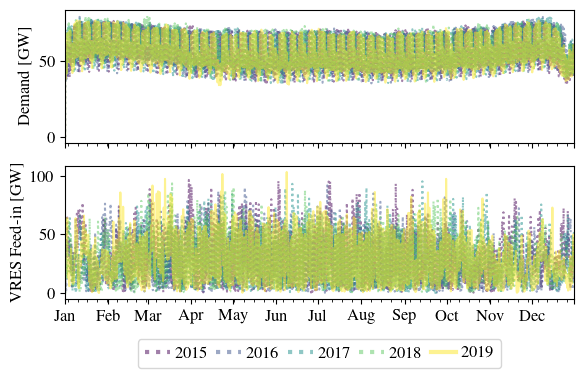

In [23]:
figsize = (6, 3.5)
fig, axes =  plt.subplots(2, 1, figsize=figsize)
demand[["entso-2015", "entso-2016", "entso-2017", "entso-2018", "entso-2019"]].plot(
    ax=axes[0], style=[':' , ':',  ':' , ':' , '-'], alpha=0.5, cmap='viridis', legend=False)
axes[0].set_ylabel("Demand [GW]")
axes[0].set_xticklabels([])
generation[["rn-2015", "rn-2016", "rn-2017", "rn-2018", "rn-2019"]].plot(
    ax=axes[1], style=[':' , ':',  ':' , ':' , '-'], alpha=0.5, cmap='viridis', legend=False)
axes[1].set_ylabel("VRES Feed-in [GW]")
axes[1].set_xticklabels([txt.get_text().replace("\n2011", "") for txt in axes[1].get_xticklabels("")])
plt.tight_layout()
leg = axes[0].legend(["2015", "2016", "2017", "2018", "2019"], ncols=6, loc="lower center", bbox_to_anchor=(0.5, -1.75),
               columnspacing=0.5, handletextpad=0.3, handlelength=1.5)
# set the linewidth of each legend object
for legobj in leg.legendHandles:
    legobj.set_linewidth(3.0)
plt.savefig("results/plots/timeseries_variation_new.pdf", bbox_inches='tight')

<AxesSubplot: >

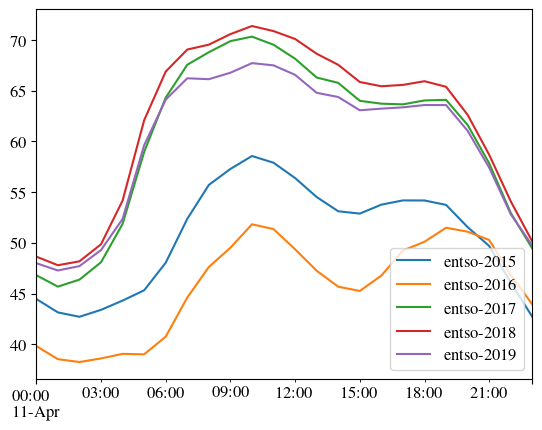

In [22]:
n=100
demand[["entso-2015", "entso-2016", "entso-2017", "entso-2018", "entso-2019"]].iloc[n*24:n*24+24].plot()

In [21]:
wind

ego-2011  rn-1980  rn-1981  rn-1982  rn-1983  rn-1984  \
2011-01-01 00:00:00        NaN      NaN      NaN      NaN      NaN      NaN   
2011-01-01 01:00:00  28.936663   0.2584   0.8960   0.2313   0.1488   0.8541   
2011-01-01 02:00:00  47.402914   0.2579   0.8904   0.1976   0.1506   0.8620   
2011-01-01 03:00:00  48.639814   0.2446   0.8915   0.1695   0.1536   0.8701   
2011-01-01 04:00:00  50.193898   0.2362   0.8865   0.1496   0.1565   0.8773   
...                        ...      ...      ...      ...      ...      ...   
2011-12-30 20:00:00  19.666086   0.5164   0.3291   0.1053   0.5406   0.0245   
2011-12-30 21:00:00  16.976337   0.5238   0.3403   0.1092   0.5407   0.0228   
2011-12-30 22:00:00  15.288628   0.5099   0.3346   0.1081   0.5268   0.0221   
2011-12-30 23:00:00  13.980715   0.5176   0.3404   0.1087   0.4876   0.0222   
2011-12-31 00:00:00  12.847836   0.5232   0.3602   0.1157   0.4657   0.0220   

                     rn-1985  rn-1986  rn-1987  rn-1988  ...  rn-2010  \
2011-01-01 00:00:00      NaN      NaN      NaN      NaN  ...      NaN   
2011-01-01 01:00:00   0.2653   0.1318   0.4682   0.2194  ...   0.1996   
2011-01-01 02:00:00   0.2650   0.1250   0.4598   0.2220  ...   0.1963   
2011-01-01 03:00:00   0.2521   0.1181   0.4352   0.2260  ...   0.1857   
2011-01-01 04:00:00   0.2296   0.1164   0.4053   0.2410  ...   0.1764   
...                      ...      ...      ...      ...  ...      ...   
2011-12-30 20:00:00   0.1047   0.3671   0.1575   0.1953  ...   0.1595   
2011-12-30 21:00:00   0.1083   0.4332   0.1237   0.1817  ...   0.1823   
2011-12-30 22:00:00   0.1070   0.4913   0.1123   0.1683  ...   0.2005   
2011-12-30 23:00:00   0.1065   0.5370   0.1128   0.1578  ...   0.2177   
2011-12-31 00:00:00   0.1087   0.5699   0.1146   0.1485  ...   0.2332   

                     rn-2011  rn-2012  rn-2013  rn-2014  rn-2015  rn-2016  \
2011-01-01 00:00:00      NaN      NaN      NaN      NaN      NaN      NaN   
2011-01-01 01:00:00   0.4733   0.2155   0.5906   0.2510   0.2139   0.1429   
2011-01-01 02:00:00   0.5071   0.2461   0.5506   0.2433   0.2206   0.1368   
2011-01-01 03:00:00   0.5335   0.2751   0.5163   0.2271   0.2248   0.1232   
2011-01-01 04:00:00   0.5654   0.2978   0.4808   0.2213   0.2276   0.1096   
...                      ...      ...      ...      ...      ...      ...   
2011-12-30 20:00:00   0.3011   0.5202   0.4915   0.1599   0.4783   0.1627   
2011-12-30 21:00:00   0.2660   0.5215   0.4736   0.1601   0.4700   0.1576   
2011-12-30 22:00:00   0.2337   0.5156   0.4496   0.1634   0.4634   0.1493   
2011-12-30 23:00:00   0.2061   0.5132   0.4136   0.1669   0.4668   0.1431   
2011-12-31 00:00:00   0.1793   0.5040   0.3736   0.1698   0.4663   0.1376   

                     rn-2017  rn-2018  rn-2019  
2011-01-01 00:00:00      NaN      NaN      NaN  
2011-01-01 01:00:00   0.3222   0.5539   0.4643  
2011-01-01 02:00:00   0.3220   0.6081   0.5103  
2011-01-01 03:00:00   0.3192   0.6662   0.5599  
2011-01-01 04:00:00   0.3195   0.7094   0.5934  
...                      ...      ...      ...  
2011-12-30 20:00:00   0.7276   0.1847   0.4802  
2011-12-30 21:00:00   0.7412   0.1508   0.4656  
2011-12-30 22:00:00   0.7157   0.1318   0.4511  
2011-12-30 23:00:00   0.6594   0.1136   0.4375  
2011-12-31 00:00:00   0.6000   0.1013   0.4324  

[8737 rows x 41 columns]

C:\Users\aheider\AppData\Local\Temp\ipykernel_20536\2414460909.py:3: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, ax =  plt.subplots(figsize=figsize)


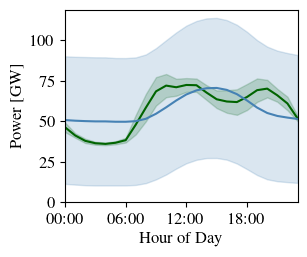

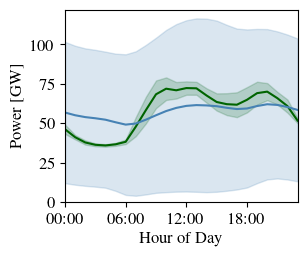

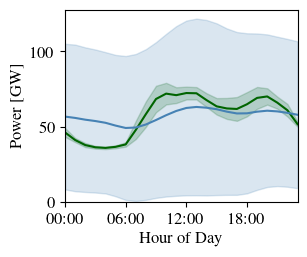

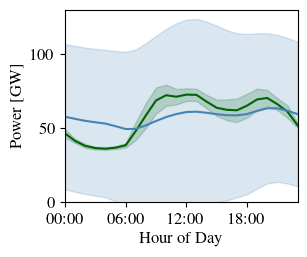

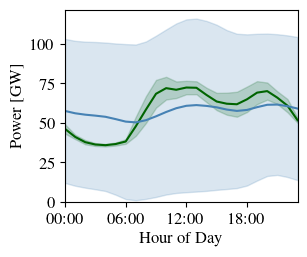

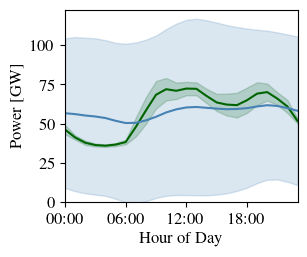

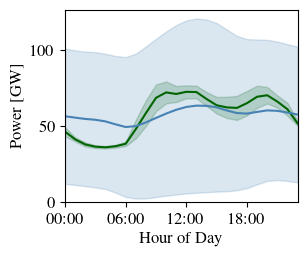

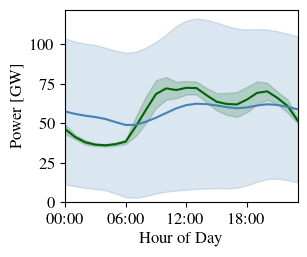

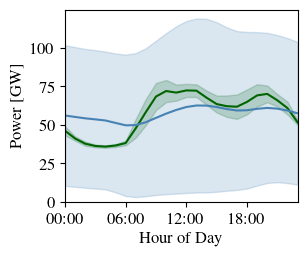

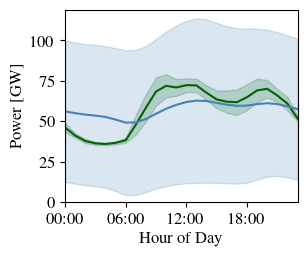

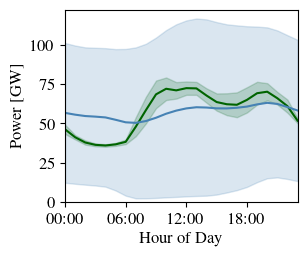

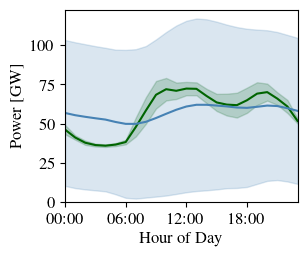

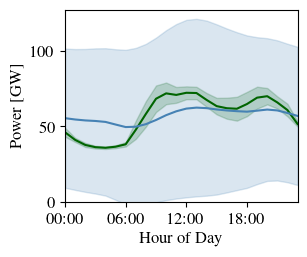

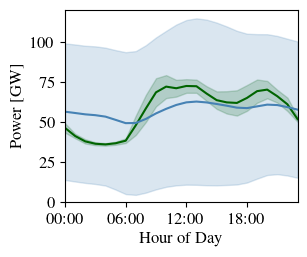

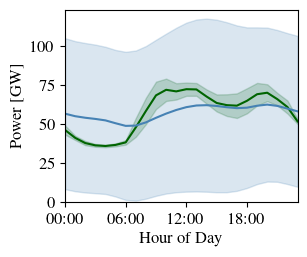

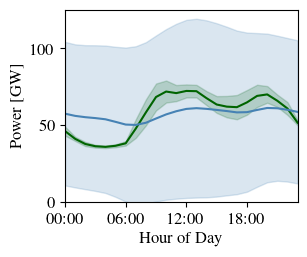

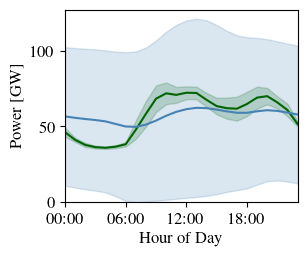

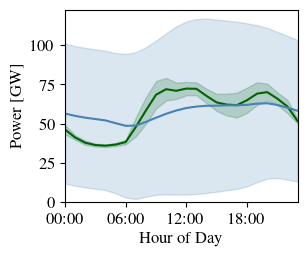

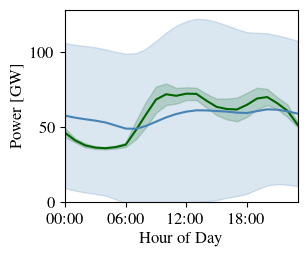

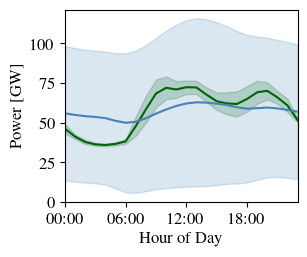

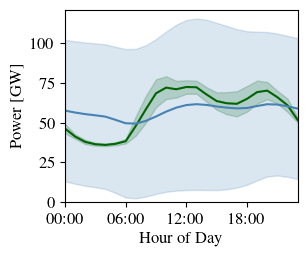

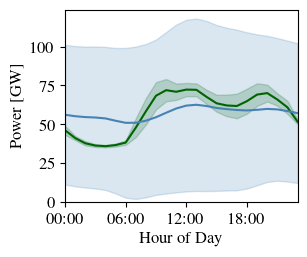

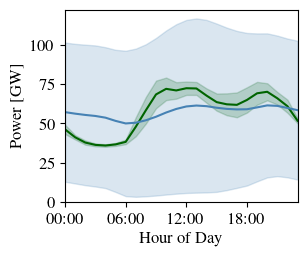

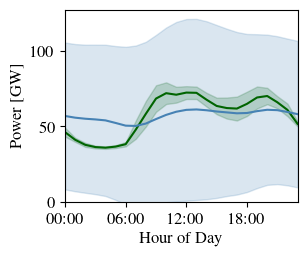

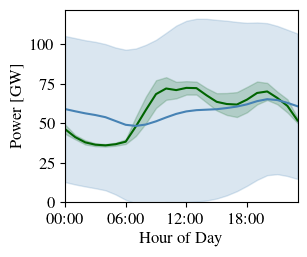

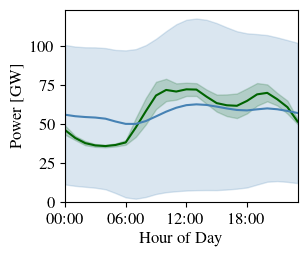

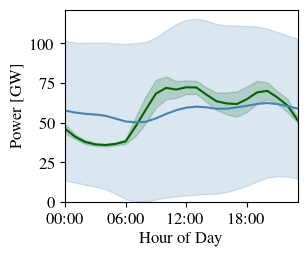

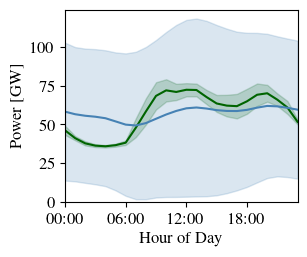

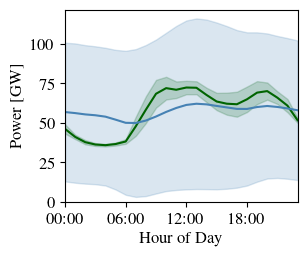

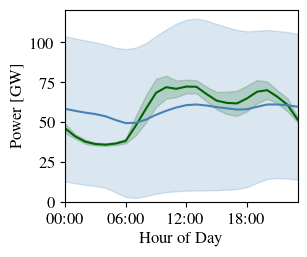

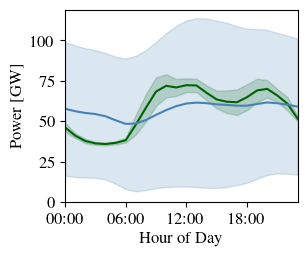

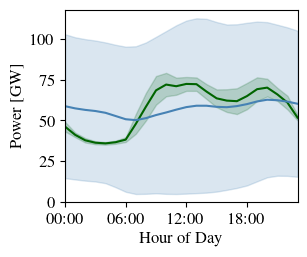

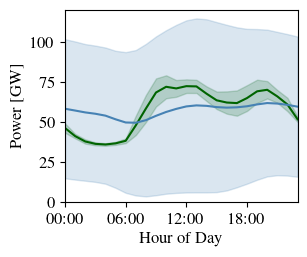

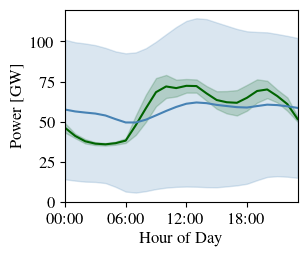

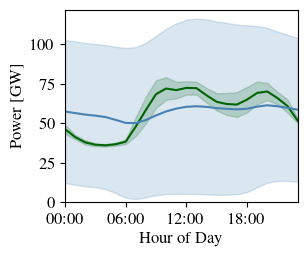

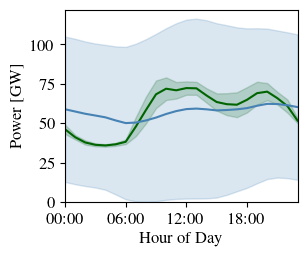

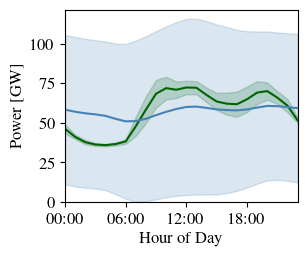

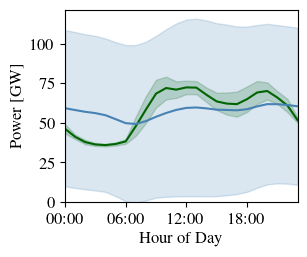

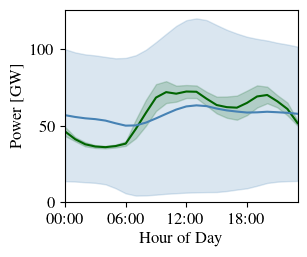

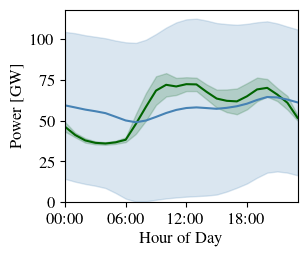

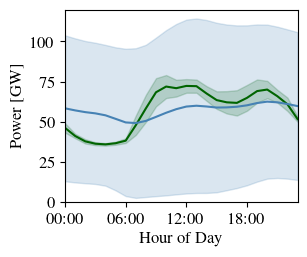

In [22]:
figsize = (6, 2.5)
for scenario in wind.columns:
    fig, ax =  plt.subplots(1, 2, figsize=figsize, gridspec_kw={'width_ratios': [1., 1]})
    df_plot = scenario_dict["ts_vres"].copy()
    df_plot["Demand"] = scenario_dict["ts_demand"].sum(axis=1)
    df_plot["solar"] = solar[scenario].divide(solar[scenario].sum()).multiply(df_plot["Demand"].sum())
    df_plot["wind"] = wind[scenario].divide(wind[scenario].sum()).multiply(df_plot["Demand"].sum())
    df_plot["RL"] = scenario_dict["ts_demand"].sum(axis=1) - scenario_dict["ts_vres"].sum(axis=1)
    df_plot["Day of Year"] = df_plot.index.dayofyear
    df_plot["Hour of Day"] = df_plot.index.hour
    sns.lineplot(data=df_plot, x="Hour of Day", y="Demand", errorbar='sd', ax=ax[0], color='Darkgreen')
    sns.lineplot(data=df_plot, x="Hour of Day", y="solar", errorbar='sd', ax=ax[0], color='orange')
    sns.lineplot(data=df_plot, x="Hour of Day", y="Demand", errorbar='sd', ax=ax[1], color='Darkgreen')
    sns.lineplot(data=df_plot, x="Hour of Day", y="wind", errorbar='sd', ax=ax[1], color='Steelblue')
    a0=ax[1]
    a0.set_xlim(0,23)
    ax[1].set_ylim(0,None)
    #a0.set_ylim(0,350)
    a0.set_xticks([0,6,12,18], ["00:00", "06:00", "12:00", "18:00"])
    a0.set_ylabel("")
    a0.set_xlabel("Time of Day")
    ax[0].set_xticks([0,6,12,18], ["00:00", "06:00", "12:00", "18:00"])
    ax[0].set_ylabel("Power [GW]")
    ax[0].set_xlabel("Time of Day")

C:\Users\aheider\AppData\Local\Temp\ipykernel_20536\2876915959.py:3: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, ax =  plt.subplots(1, 2, figsize=figsize, gridspec_kw={'width_ratios': [1., 1]})


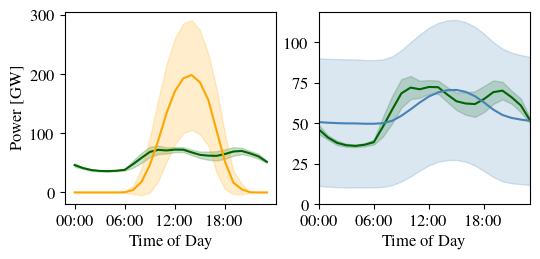

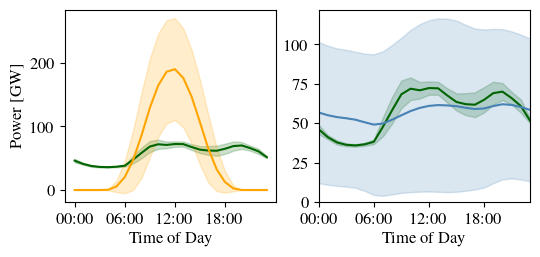

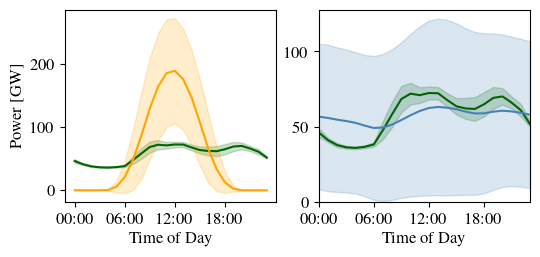

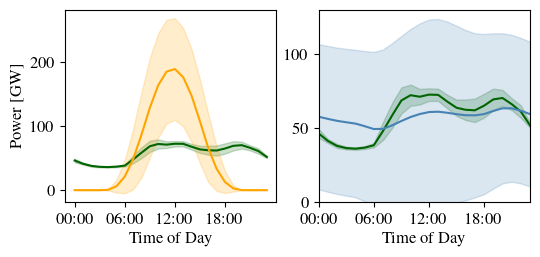

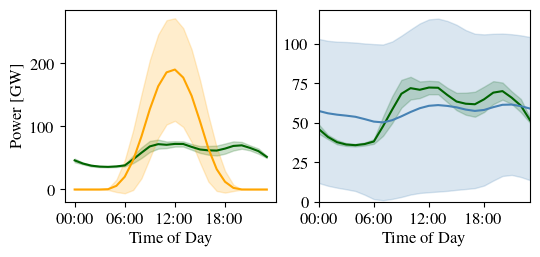

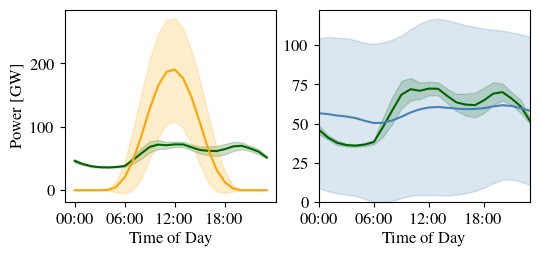

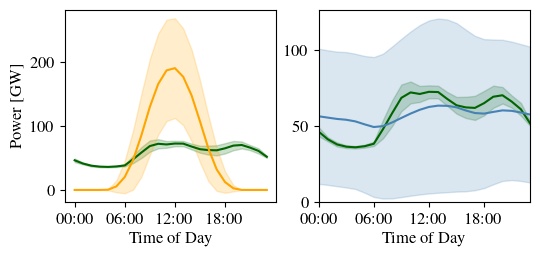

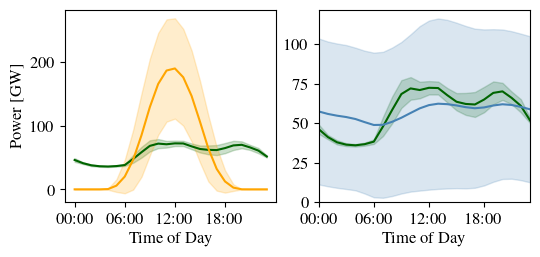

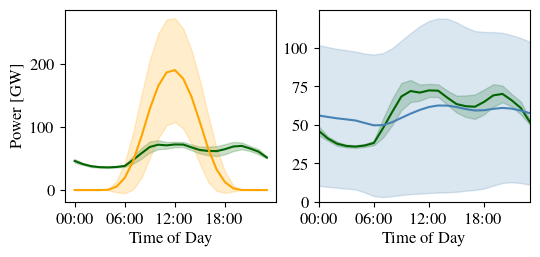

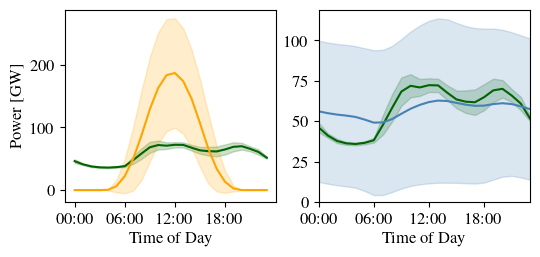

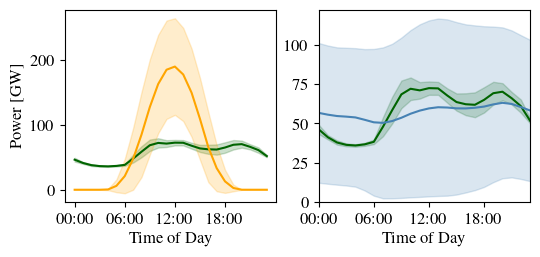

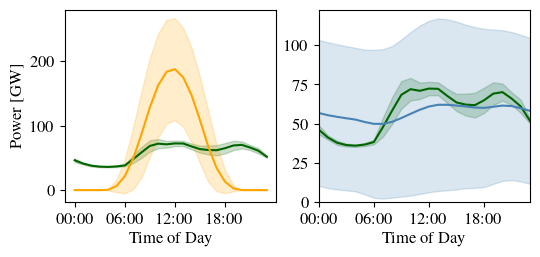

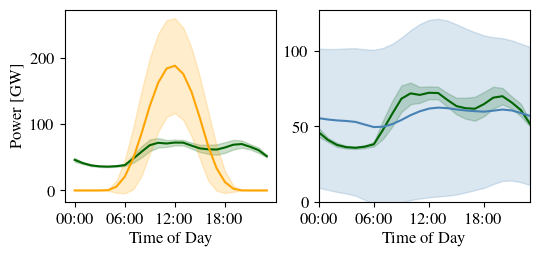

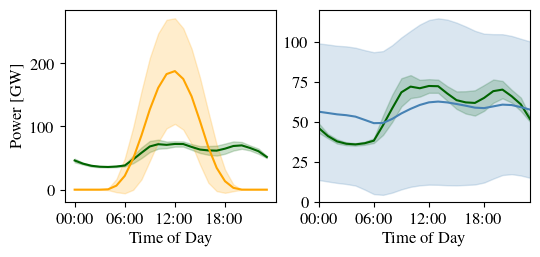

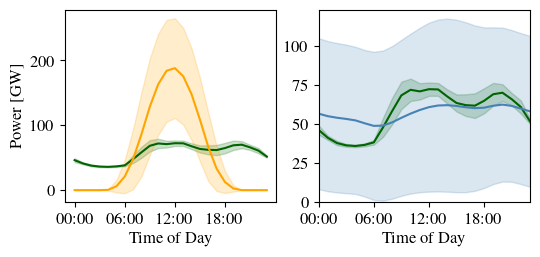

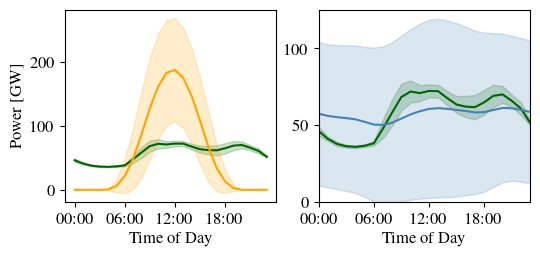

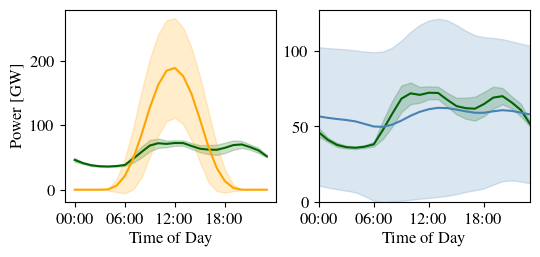

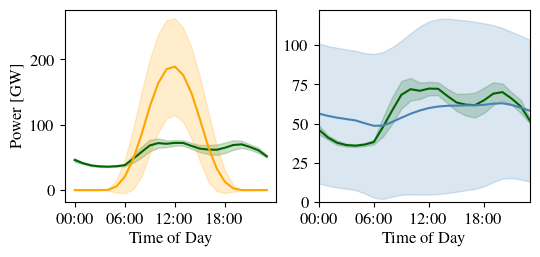

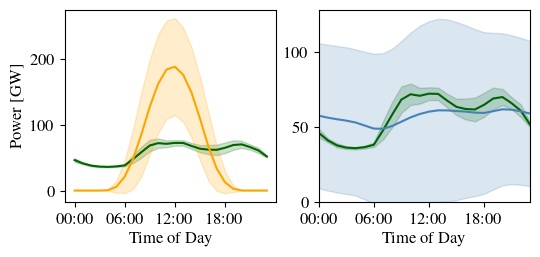

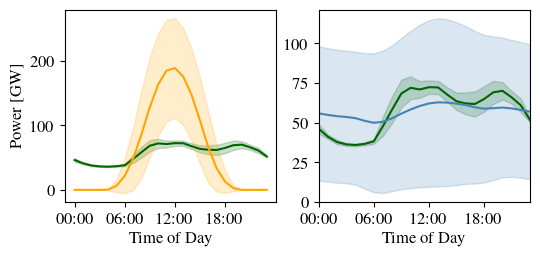

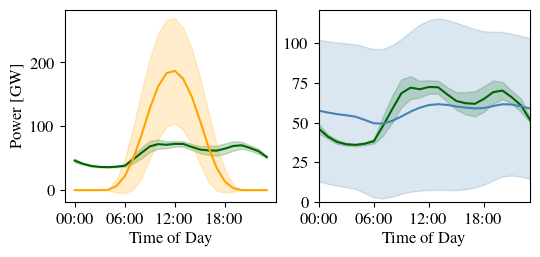

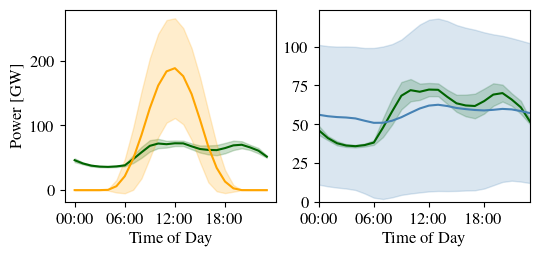

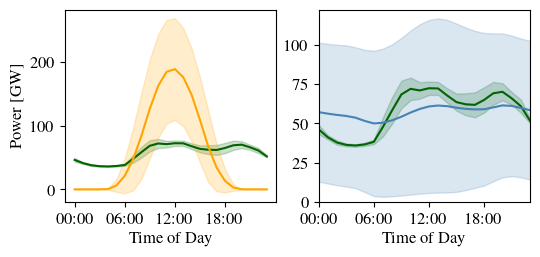

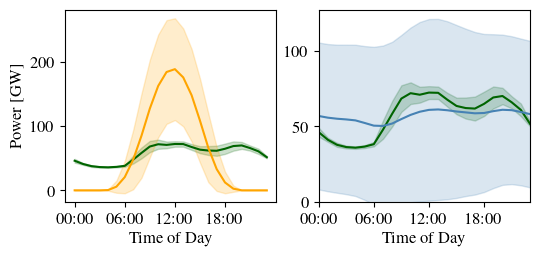

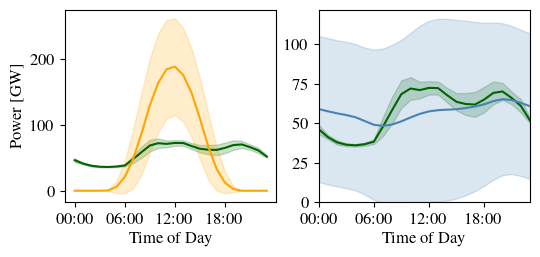

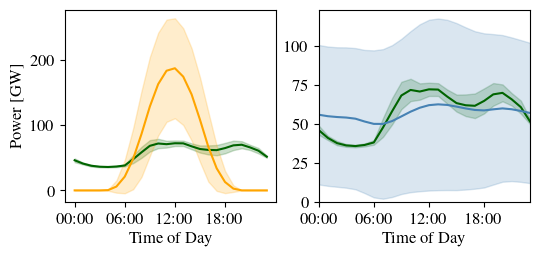

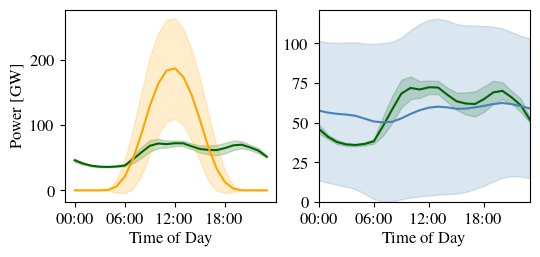

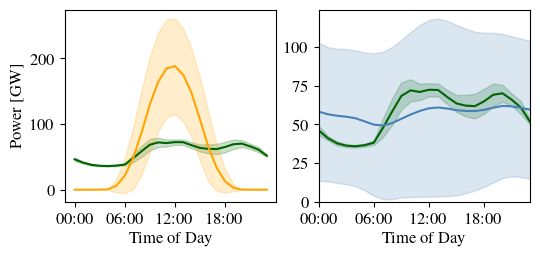

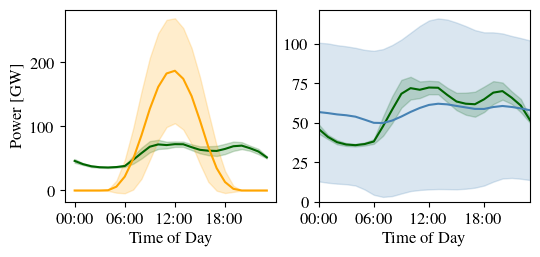

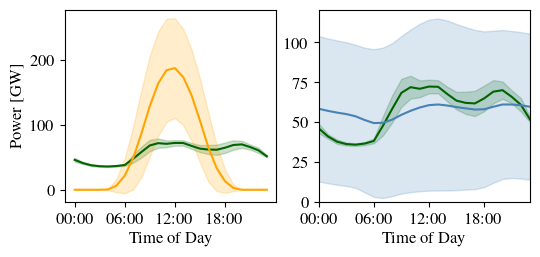

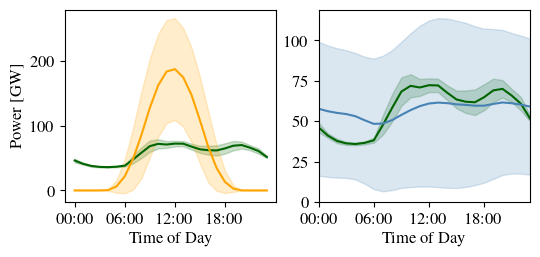

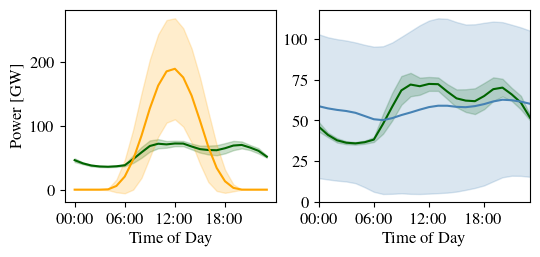

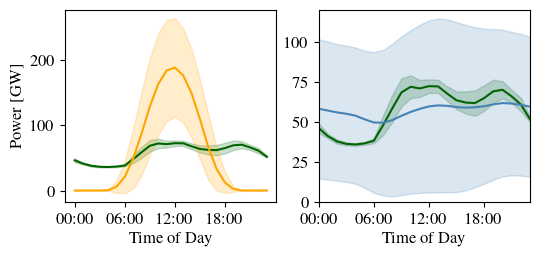

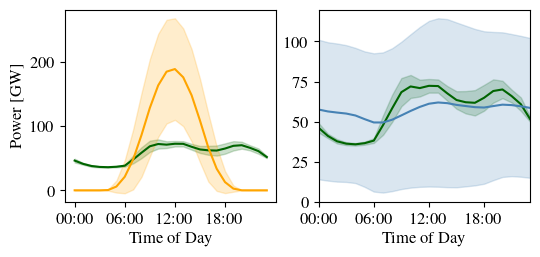

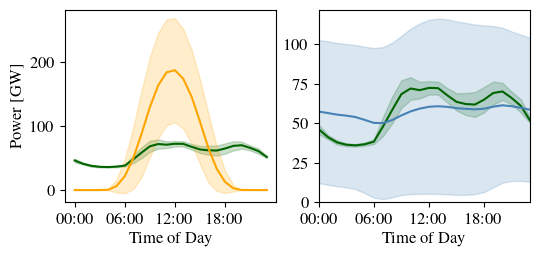

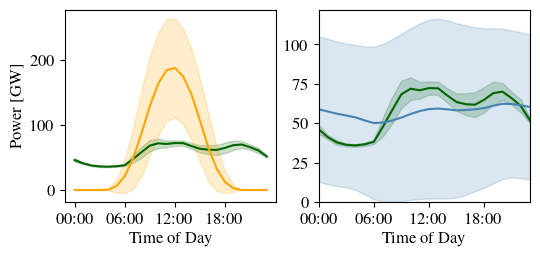

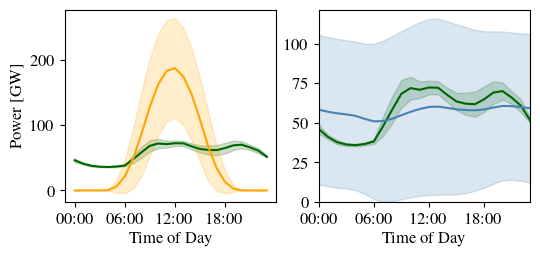

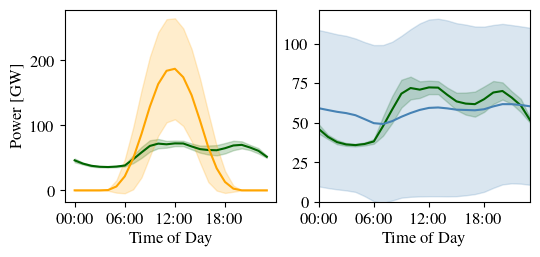

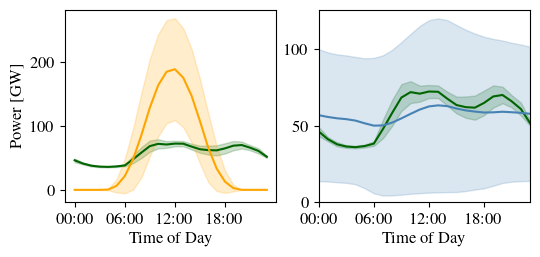

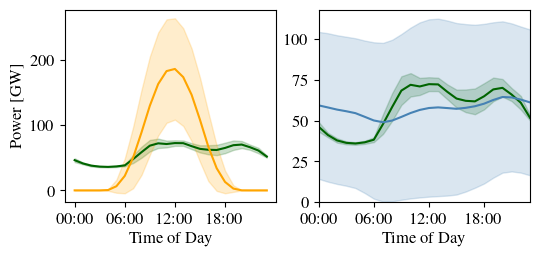

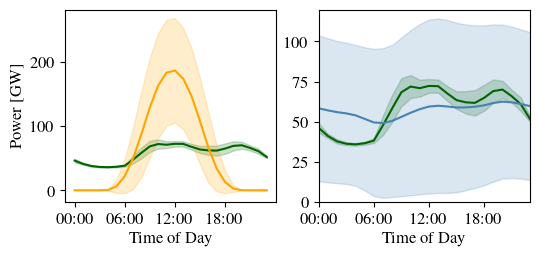

In [43]:
figsize = (6, 2.5)
for scenario in wind.columns:
    fig, ax =  plt.subplots(1, 2, figsize=figsize, gridspec_kw={'width_ratios': [1., 1]})
    df_plot = scenario_dict["ts_vres"].copy()
    df_plot["Demand"] = scenario_dict["ts_demand"].sum(axis=1)
    df_plot["solar"] = solar[scenario].divide(solar[scenario].sum()).multiply(df_plot["Demand"].sum())
    df_plot["wind"] = wind[scenario].divide(wind[scenario].sum()).multiply(df_plot["Demand"].sum())
    df_plot["RL"] = scenario_dict["ts_demand"].sum(axis=1) - scenario_dict["ts_vres"].sum(axis=1)
    df_plot["Day of Year"] = df_plot.index.dayofyear
    df_plot["Hour of Day"] = df_plot.index.hour
    sns.lineplot(data=df_plot, x="Hour of Day", y="Demand", errorbar='sd', ax=ax[0], color='Darkgreen')
    sns.lineplot(data=df_plot, x="Hour of Day", y="solar", errorbar='sd', ax=ax[0], color='orange')
    sns.lineplot(data=df_plot, x="Hour of Day", y="Demand", errorbar='sd', ax=ax[1], color='Darkgreen')
    sns.lineplot(data=df_plot, x="Hour of Day", y="wind", errorbar='sd', ax=ax[1], color='Steelblue')
    a0=ax[1]
    a0.set_xlim(0,23)
    ax[1].set_ylim(0,None)
    #a0.set_ylim(0,350)
    a0.set_xticks([0,6,12,18], ["00:00", "06:00", "12:00", "18:00"])
    a0.set_ylabel("")
    a0.set_xlabel("Time of Day")
    ax[0].set_xticks([0,6,12,18], ["00:00", "06:00", "12:00", "18:00"])
    ax[0].set_ylabel("Power [GW]")
    ax[0].set_xlabel("Time of Day")

In [36]:
def plot_entso_ts(scenario_dict, generation):
    figsize = (9, 2.5)
    fig, ax =  plt.subplots(1, 3, figsize=figsize)
    df_plot = generation.copy()
    df_plot["Demand"] = scenario_dict["ts_demand"].sum(axis=1)
    for gen_type in ['Wind Onshore', 'Wind Offshore', 'Solar']:
        df_plot[gen_type] = df_plot[gen_type].divide(df_plot[gen_type].sum()).multiply(df_plot["Demand"].sum())
    df_plot["Day of Year"] = df_plot.index.dayofyear
    df_plot["Hour of Day"] = df_plot.index.hour
    sns.lineplot(data=df_plot, x="Hour of Day", y="Demand", errorbar='sd', ax=ax[0], color='Darkgreen')
    sns.lineplot(data=df_plot, x="Hour of Day", y='Solar', errorbar='sd', ax=ax[0], color='orange')
    sns.lineplot(data=df_plot, x="Hour of Day", y="Demand", errorbar='sd', ax=ax[1], color='Darkgreen')
    sns.lineplot(data=df_plot, x="Hour of Day", y='Wind Onshore', errorbar='sd', ax=ax[1], color='Steelblue')
    sns.lineplot(data=df_plot, x="Hour of Day", y="Demand", errorbar='sd', ax=ax[2], color='Darkgreen')
    sns.lineplot(data=df_plot, x="Hour of Day", y='Wind Offshore', errorbar='sd', ax=ax[2], color='Steelblue')
    for a0 in ax:
        a0.set_xlim(0,23)
        a0.set_ylim(0,None)
        a0.set_xticks([0,6,12,18], ["00:00", "06:00", "12:00", "18:00"])
        a0.set_ylabel("")
        a0.set_xlabel("Time of Day")
    ax[0].set_ylabel("Power [GW]")

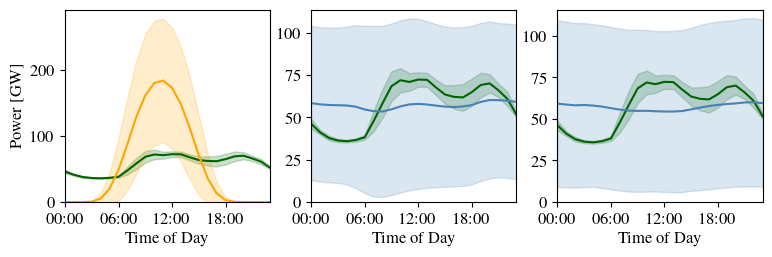

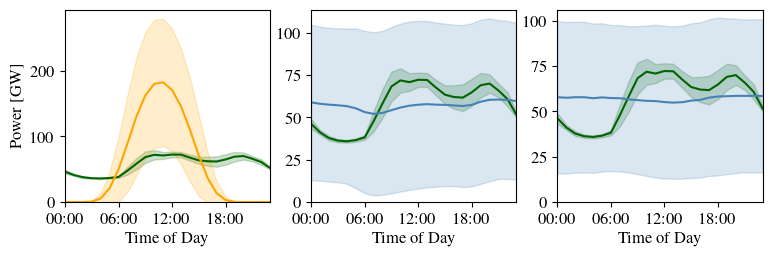

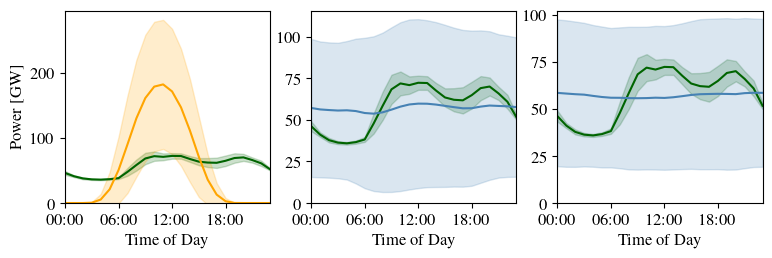

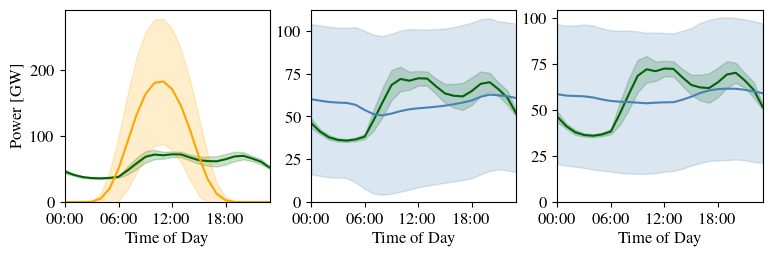

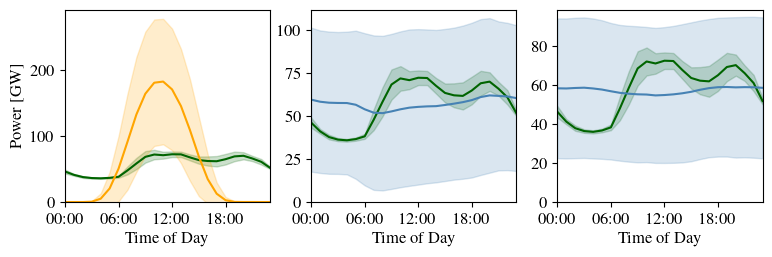

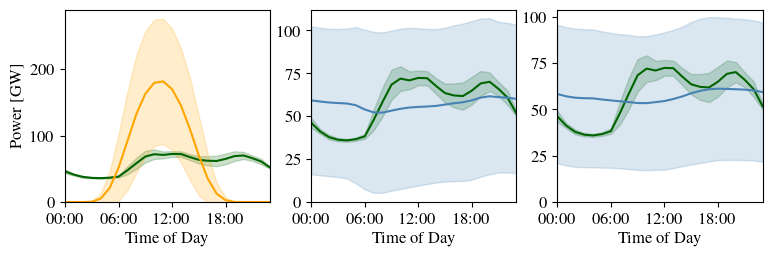

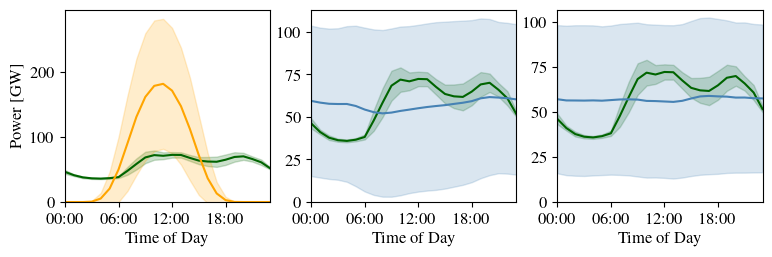

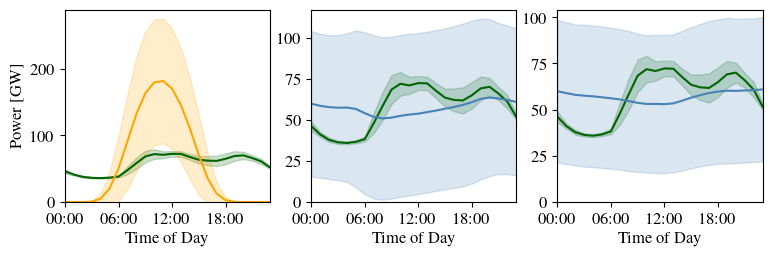

In [37]:
timeindex = scenario_dict["ts_demand"].index
for year in range(2015, 2023):
    generation = pd.DataFrame()
    for month in ["01", "02", "03", "04", "05", "06",
                  "07", "08", "09", "10", "11", "12"]:
        generation_month = pd.DataFrame()
        generation_tmp = pd.read_csv(
                    f"data/generation_entso/{year}_{month}_AggregatedGenerationPerType_16.1.B_C.csv", sep='\t',
                    index_col=0, parse_dates=True)
        generation_tmp = generation_tmp.loc[
                    generation_tmp.AreaName == "DE CTY"]
        for gen_type in ['Wind Onshore', 'Wind Offshore', 'Solar']:
            generation_month[gen_type] = generation_tmp.loc[generation_tmp.ProductionType==gen_type]["ActualGenerationOutput"]
        generation_month = generation_month.resample("1h").mean()
        generation = pd.concat([generation, generation_month])
    generation = generation.iloc[:len(timeindex)]
    generation.index = timeindex
    plot_entso_ts(scenario_dict, generation)

In [32]:
year=2015
generation = pd.DataFrame()
timeindex = scenario_dict["ts_demand"].index
for month in ["01", "02", "03", "04", "05", "06",
              "07", "08", "09", "10", "11", "12"]:
    generation_month = pd.DataFrame()
    generation_tmp = pd.read_csv(
                f"data/generation_entso/{year}_{month}_AggregatedGenerationPerType_16.1.B_C.csv", sep='\t',
                index_col=0, parse_dates=True)
    generation_tmp = generation_tmp.loc[
                generation_tmp.AreaName == "DE CTY"]
    for gen_type in ['Wind Onshore', 'Wind Offshore', 'Solar']:
        generation_month[gen_type] = generation_tmp.loc[generation_tmp.ProductionType==gen_type]["ActualGenerationOutput"]
    generation_month = generation_month.resample("1h").mean()
    generation = pd.concat([generation, generation_month])
generation = generation.iloc[:len(timeindex)]
generation.index = timeindex
generation

Wind Onshore  Wind Offshore  Solar
2011-01-01 00:00:00     9046.3175       520.8100    0.0
2011-01-01 01:00:00     9196.3875       519.0325    0.0
2011-01-01 02:00:00     9146.8025       522.5550    0.0
2011-01-01 03:00:00     9203.9550       524.6200    0.0
2011-01-01 04:00:00     9511.3325       524.4050    0.0
...                           ...            ...    ...
2011-12-30 20:00:00    15868.1225      2537.0600    0.0
2011-12-30 21:00:00    15635.4450      2537.8050    0.0
2011-12-30 22:00:00    15605.4500      2542.0525    0.0
2011-12-30 23:00:00    15487.4900      2538.8800    0.0
2011-12-31 00:00:00    15085.0900      2541.0575    0.0

[8737 rows x 3 columns]

# Results

In [47]:
def change_width(ax, new_value) :
    for patch in ax.patches :
        current_width = patch.get_width()
        diff = current_width - new_value

        # we change the bar width
        patch.set_width(new_value)

        # we recenter the bar
        patch.set_x(patch.get_x() + diff * .5)

In [48]:
def plot_storage_equivalent_germany_stacked(
        storage_equivalent,
        parameter={"scenario": "Deutschland"},
        ylabel="Gespeicherte Energie [GWh]",
        figsize=(5, 3),
        loc="upper left",
        ylim=None,
        language="english",
        save_dir=None,
        title=None,
        barwidth=None,
        ax=None,
        var="energy_stored"
):
    param = list(parameter.items())[0][0]
    xlabel = list(parameter.items())[0][1]
    
    
    if (language == "german") or (language == "deutsch"):
        type_dict = {0: "Kurz", 1: "Mittel", 2: "Land"}
    else:
        type_dict = {0: "Short", 1: "Medium", 2: "Long"}
    if ax is None:
        fig, ax = plt.subplots(figsize=figsize)
    colors = matplotlib.cm.get_cmap("Blues")
    for storage_type in range(storage_equivalent.storage_type.max()+1):
        plot_df = pd.DataFrame(index=storage_equivalent[param].unique())
        for val in storage_equivalent[param].unique():
            tmp = storage_equivalent.loc[(storage_equivalent[param] == val)&
                                        (storage_equivalent.storage_type >= storage_type)&
                                        (np.sign(storage_equivalent.energy_stored) == np.sign(storage_equivalent.loc[
                                            (storage_equivalent[param] == val)&
                                            (storage_equivalent.storage_type == storage_type), var
                                        ].values[0]))]
            plot_df.loc[val, ylabel] = tmp[var].sum()/1e3
        plot_df[xlabel] = storage_equivalent[param].unique()

        sns.barplot(x=xlabel, y=ylabel, color=colors(1.0-0.3*storage_type),
                    data=plot_df, ax=ax, label=type_dict[storage_type])
    if loc is not None:
        plt.legend(loc=loc)#loc="lower left"
    if barwidth is not None:
        change_width(ax, barwidth)
    if ylim is not None:
        # ax.get_ylim()
        ax.set_ylim(ylim)
    if param in ["nr_ev"]:
        xticklabels = ax.get_xticklabels()
        ax.set_xticklabels([int(float(tick.get_text())) for tick in xticklabels])
    if title is not None:
        plt.title(title)
    plt.tight_layout()
    if save_dir is not None:
        if "png" in save_dir:
            plt.savefig(save_dir, dpi=300)
        else:
            plt.savefig(save_dir)
    #plt.show()

In [49]:
def plot_storage_equivalent_germany_stacked_four(
        storage_equivalent_ref, storage_equivalent_flex, growth, diff,
        parameter={"scenario": "Deutschland"},
        ylabel="Stored Energy [TWh]",
        ylabel1="Change in Stored Energy [TWh]",
        figsize=(8, 6),
        ylim=None,
        language="english",
        loc="upper left",
        save_dir=None,
        titles = ["Reference Operation", "Optimised Operation", "Growth Reference Operation", "Reduction Optimised Operation"]
):
    param = list(parameter.items())[0][0]
    xlabel = list(parameter.items())[0][1]
    
    
    axes_dict = {(0,0): {"title": titles[0], "values": storage_equivalent_ref, "ylim": 0},
                (0,1): {"title": titles[1], "values": storage_equivalent_flex, "ylim": 1},
                (1,0): {"title": titles[2], "values": growth, "ylim": 2},
                (1,1): {"title": titles[3], "values": diff, "ylim": 3}}
    
    if (language == "german") or (language == "deutsch"):
        type_dict = {0: "Tag", 1: "Woche", 2: "Saisonal"}
    else:
        type_dict = {0: "Short", 1: "Medium", 2: "Long"}
    fig, axes = plt.subplots(2,2,figsize=figsize)
    colors = matplotlib.cm.get_cmap("Blues")
    for ax in axes_dict.keys():
        storage_equivalent = axes_dict[ax]["values"]
        for storage_type in range(storage_equivalent.storage_type.max()+1):

            plot_df = pd.DataFrame(index=storage_equivalent[param].unique())
            for val in storage_equivalent[param].unique():
                tmp = storage_equivalent.loc[(storage_equivalent[param] == val)&
                                            (storage_equivalent.storage_type >= storage_type)&
                                            (np.sign(storage_equivalent.energy_stored) == np.sign(storage_equivalent.loc[
                                                (storage_equivalent[param] == val)&
                                                (storage_equivalent.storage_type == storage_type), "energy_stored"
                                            ].values[0]))]
                plot_df.loc[val, ylabel] = tmp.energy_stored.sum()/1e3
            plot_df[xlabel] = storage_equivalent[param].unique()

            sns.barplot(x=xlabel, y=ylabel, color=colors(1.0-0.3*storage_type),
                        data=plot_df, ax=axes[ax], label=type_dict[storage_type])
        axes[ax].set_title(axes_dict[ax]["title"])
        if ax == (0,0):
            axes[ax].legend(loc=loc, columnspacing=0.5, handletextpad=0.3, handlelength=1.0,
                            borderpad=0.2)#loc="lower left"
        if ylim is not None:
            axes[ax].set_ylim(ylim[axes_dict[ax]["ylim"]])
        if (ax==(0,1)) or (ax==(1,1)):
            axes[ax].set_ylabel("")
        elif ax==(1,0):
            axes[ax].set_ylabel(ylabel1)
        if (ax==(0,0)) or (ax==(0,1)):
            axes[ax].set_xlabel("")
            axes[ax].set_xticks([])
        else:
            if param in ["nr_ev"]:
                xticklabels = axes[ax].get_xticklabels()
                axes[ax].set_xticklabels([int(float(tick.get_text())) for tick in xticklabels])
    plt.tight_layout()
    if save_dir is not None:
        if "png" in save_dir:
            plt.savefig(save_dir, dpi=300)
        else:
            plt.savefig(save_dir)
    return axes

In [50]:
def plot_storage_equivalent_germany_stacked_five(
        df_0, df_1, df_2, df_3, df_4,
        parameter={"scenario": "Deutschland"},
        ylabel="Stored Energy [TWh]",
        ylabel1="Change in Stored Energy [TWh]",
        figsize=(8, 9),
        ylim=None,
        language="english",
        loc="upper left",
        save_dir=None,
        titles = ["Reference Operation", "Optimised Operation", "Growth Reference Operation", "Reduction Optimised Operation", ""]
):
    param = list(parameter.items())[0][0]
    xlabel = list(parameter.items())[0][1]
    
    
    axes_dict = {(0,0): {"title": titles[0], "values": df_0, "ylim": 0},
                (0,1): {"title": titles[1], "values": df_1, "ylim": 1},
                (1,0): {"title": titles[2], "values": df_2, "ylim": 2},
                (1,1): {"title": titles[3], "values": df_3, "ylim": 3},
                (2,0): {"title": titles[4], "values": df_4, "ylim": 3}}
    
    if (language == "german") or (language == "deutsch"):
        type_dict = {0: "Tag", 1: "Woche", 2: "Saisonal"}
    else:
        type_dict = {0: "Short", 1: "Medium", 2: "Long"}
    fig, axes = plt.subplots(3,2,figsize=figsize)
    fig.delaxes(axes[(2,1)])
    colors = matplotlib.cm.get_cmap("Blues")
    for ax in axes_dict.keys():
        storage_equivalent = axes_dict[ax]["values"]
        for storage_type in range(storage_equivalent.storage_type.max()+1):

            plot_df = pd.DataFrame(index=storage_equivalent[param].unique())
            for val in storage_equivalent[param].unique():
                tmp = storage_equivalent.loc[(storage_equivalent[param] == val)&
                                            (storage_equivalent.storage_type >= storage_type)&
                                            (np.sign(storage_equivalent.energy_stored) == np.sign(storage_equivalent.loc[
                                                (storage_equivalent[param] == val)&
                                                (storage_equivalent.storage_type == storage_type), "energy_stored"
                                            ].values[0]))]
                plot_df.loc[val, ylabel] = tmp.energy_stored.sum()/1e3
            plot_df[xlabel] = storage_equivalent[param].unique()

            sns.barplot(x=xlabel, y=ylabel, color=colors(1.0-0.3*storage_type),
                        data=plot_df, ax=axes[ax], label=type_dict[storage_type])
        axes[ax].set_title(axes_dict[ax]["title"])
        if ax == (0,0):
            axes[ax].legend(loc=loc)#loc="lower left"
        if ylim is not None:
            axes[ax].set_ylim(ylim[axes_dict[ax]["ylim"]])
        if (ax==(0,1)) or (ax==(1,1)) or (ax==(1,2)):
            axes[ax].set_ylabel("")
        elif ax==(1,0):
            axes[ax].set_ylabel(ylabel1)
        if (ax==(0,0)) or (ax==(0,1)) or (ax==(1,0)):
            axes[ax].set_xlabel("")
            axes[ax].set_xticklabels([])
        else:
            if param in ["nr_ev"]:
                xticklabels = axes[ax].get_xticklabels()
                axes[ax].set_xticklabels([int(float(tick.get_text())) for tick in xticklabels])
    plt.tight_layout()
    if save_dir is not None:
        if "png" in save_dir:
            plt.savefig(save_dir, dpi=300)
        else:
            plt.savefig(save_dir)
    return axes

# Variation generation

In [24]:
res_dir = r"U:\Software\Flexibility-Quantification\results\Diss2024_final"
scenario = "Gen_Base"
storage_equivalent_tmp = pd.read_csv(
        "{}/{}/storage_equivalents.csv".format(res_dir, scenario),
        index_col=0)
storage_equivalent_tmp

storage_type  energy_stored      data_source  year
0             0   14039.021997  flat_generation  2019
1             1   11685.144663  flat_generation  2019
2             2   11835.119451  flat_generation  2019
0             0   54456.267709               rn  2019
1             1   51900.822676               rn  2019
2             2   31717.142043               rn  2019

In [25]:
storage_equivalent_tm[["energy_stored", "scenario"]]p.groupby("data_source").sum().divide(1000)

storage_type  energy_stored   year
data_source                                        
flat_generation         0.003      37.559286  6.057
rn                      0.003     138.074232  6.057

In [8]:
res_dir = r"U:\Software\Flexibility-Quantification\results\Diss2024_final"
scenario = "Gen_Base"
storage_equivalent_tmp = pd.read_csv(
        "{/{}/storage_equivalents.csv".format(res_dir, scenario),
        index_col=0)
storage_equivalent_tmp["scenario"] = "Flat\nGen."
scenario = "Base_Case"
storage_equivalent_tmp_base = pd.read_csv(
        "results/two_weeks/{}/storage_equivalents.csv".format(scenario),
        index_col=0)
storage_equivalent_tmp_base["scenario"] = "100\%\nRES"
storage_equivalent_base = pd.concat([storage_equivalent_tmp, storage_equivalent_tmp_base], ignore_index=True)
storage_equivalent_base

storage_type  energy_stored  nr_hp  nr_ev    scenario
0             0   41189.540061      0      0  Flat\nGen.
1             1   13389.337064      0      0  Flat\nGen.
2             2    1385.567288      0      0  Flat\nGen.
3             0   40476.138467      0      0  100\%\nRES
4             1   51279.081921      0      0  100\%\nRES
5             2   39725.808879      0      0  100\%\nRES

In [14]:
storage_equivalent_base[["energy_stored", "scenario"]].groupby("scenario").sum().divide(1000)

energy_stored
scenario                 
100\%\nRES     131.481029
Flat\nGen.      55.964444

In [12]:
scenario = "Variation_Generation_increased_resolution"
storage_equivalent = pd.read_csv(
        "results/two_weeks/{}/storage_equivalents.csv".format(scenario),
    index_col=0)
storage_equivalent[["energy_stored", "share_pv"]].groupby("share_pv").sum().divide(1000)

energy_stored
share_pv               
0.00         155.045052
0.05         146.504105
0.10         139.479675
0.15         134.088219
0.20         131.178183
0.25         130.691622
0.30         132.247661
0.35         135.407381
0.40         140.020617
0.45         145.869911
0.50         153.086834
0.55         161.702115
0.60         171.656929
0.65         182.889976
0.70         195.400058
0.75         209.096470
0.80         223.408596
0.85         237.921730
0.90         252.582311
0.95         267.365170
1.00         282.243725

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


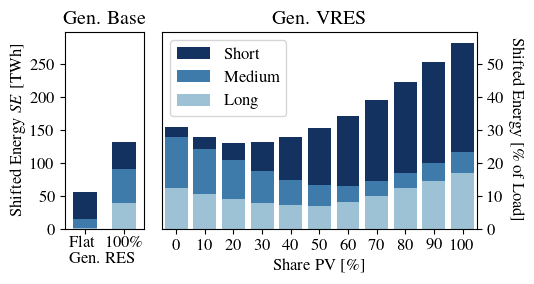

In [38]:
save_dir = "results/plots"
f, (a0, a1) = plt.subplots(1, 2, figsize=(5.5, 3), gridspec_kw={'width_ratios': [1, 4]})
title1 = "Gen. Base"
title2 = "Gen. VRES"
parameter = {"scenario": "Scenario"}
ylabel = "Shifted Energy $SE$ [TWh]"
language = "english"
plot_storage_equivalent_germany_stacked(
            storage_equivalent_base,
            parameter=parameter,
            ylabel=ylabel,
            loc="upper left",
            language=language,
            ax=a0,
            ylim=(0,299),
            barwidth=0.6,
        )
scenario = "Variation_Generation"
storage_equivalent = pd.read_csv(
        "results/two_weeks/{}/storage_equivalents.csv".format(scenario),
        index_col=0)
parameter = {"share_pv": "Share PV [\%]"}
ylabel = "Stored Energy [TWh]"
language = "english"
plot_storage_equivalent_germany_stacked(
            storage_equivalent,
            parameter=parameter,
            ylabel=ylabel,
            loc="upper left",
            language=language,
            ax=a1,
            ylim=(0,299),
        )
a0.set_xlabel("")
a0.set_yticks([0, 50, 100, 150, 200, 250])
a1.set_yticks([0, 50, 100, 150, 200, 250])
a1.set_xticklabels([i*10 for i in range(11)])
a1.set_ylabel("Shifted Energy [\% of Load]", rotation=270, labelpad=15)
a1.yaxis.set_label_position("right")
a1.yaxis.tick_right()
a1.yaxis.tick_right()
a1.set_yticklabels([int(tick/5) for tick in a1.get_yticks()])
a0.set_title(title1)
a1.set_title(title2)
plt.tight_layout()
save_dir_tmp = os.path.join(save_dir, "storage_equivalent_generation.pdf")
plt.savefig(save_dir_tmp)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


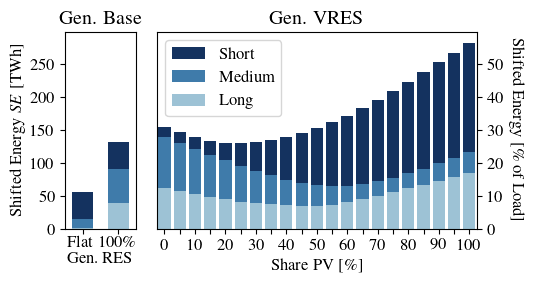

In [51]:
save_dir = "results/plots"
f, (a0, a1) = plt.subplots(1, 2, figsize=(5.5, 3), gridspec_kw={'width_ratios': [1, 4.5]})
title1 = "Gen. Base"
title2 = "Gen. VRES"
parameter = {"scenario": "Scenario"}
ylabel = "Shifted Energy $SE$ [TWh]"
language = "english"
plot_storage_equivalent_germany_stacked(
            storage_equivalent_base,
            parameter=parameter,
            ylabel=ylabel,
            loc="upper left",
            language=language,
            ax=a0,
            ylim=(0,299),
            barwidth=0.6,
        )
scenario = "Variation_Generation_increased_resolution"
storage_equivalent = pd.read_csv(
        "results/two_weeks/{}/storage_equivalents.csv".format(scenario),
        index_col=0)
parameter = {"share_pv": "Share PV [\%]"}
ylabel = "Stored Energy [TWh]"
language = "english"
plot_storage_equivalent_germany_stacked(
            storage_equivalent,
            parameter=parameter,
            ylabel=ylabel,
            loc="upper left",
            language=language,
            ax=a1,
            ylim=(0,299),
        )
a0.set_xlabel("")
a0.set_xticklabels(["Flat~\nGen.~", "~100\%\n~~RES"])
a0.set_yticks([0, 50, 100, 150, 200, 250])
a1.set_yticks([0, 50, 100, 150, 200, 250])
a1.set_xticklabels([int(i/2)*10 if i%2==0 else "" for i in range(21)])
a1.set_ylabel("Shifted Energy [\% of Load]", rotation=270, labelpad=15)
a1.yaxis.set_label_position("right")
a1.yaxis.tick_right()
a1.yaxis.tick_right()
a1.set_yticklabels([int(tick/5) for tick in a1.get_yticks()])
a0.set_title(title1)
a1.set_title(title2)
plt.tight_layout()
save_dir_tmp = os.path.join(save_dir, "storage_equivalent_generation.pdf")
plt.savefig(save_dir_tmp)

In [11]:
storage_equivalent[["energy_stored", "share_pv"]].groupby("share_pv").sum()

energy_stored
share_pv               
0.0       155045.051756
0.1       139479.675209
0.2       131178.183228
0.3       132247.660816
0.4       140020.617352
0.5       153086.833606
0.6       171656.929435
0.7       195400.057549
0.8       223408.595508
0.9       252582.311344
1.0       282243.724796

In [35]:
naming_dict = {"0": "Short", "1": "Medium", "2": "Long"}
color_dict = {"Day": 0, "Week": 1, "Seasonal": 2}
colors = matplotlib.cm.get_cmap("Blues")
color_list = [colors(1.0-0.3*storage_type) for storage_type in [0,1,2]]
tf = pd.Series({
    "Short": pd.to_timedelta("24h"),
    "Medium": pd.to_timedelta("14d"),
    "Long": pd.to_timedelta("364d")
})
tf_num = pd.Series({
    "Short": pd.to_timedelta("24h")/pd.to_timedelta("1h"),
    "Medium": pd.to_timedelta("14d")/pd.to_timedelta("1h"),
    "Long": pd.to_timedelta("364d")/pd.to_timedelta("1h")
})
sd_df = pd.read_csv(os.path.join(r"results/two_weeks", scenario, "storage_durations.csv"), index_col=0, parse_dates=True)
for col in sd_df.columns:
    sd_df[col] = pd.to_timedelta(sd_df[col])
sd_df.rename(columns=naming_dict, inplace=True)
sd_df

Short                    Medium  \
0.0 0 days 11:22:17.803923027 4 days 09:34:49.410391336   
0.0 0 days 11:22:17.803923027 4 days 09:34:49.410391336   
0.0 0 days 11:22:17.803923027 4 days 09:34:49.410391336   
0.0 0 days 11:22:17.803923027 4 days 09:34:49.410391336   
0.0 0 days 11:22:17.803923027 4 days 09:34:49.410391336   
..                        ...                       ...   
1.0 0 days 06:16:56.584609678 4 days 03:50:10.348783136   
1.0 0 days 06:16:56.584609678 4 days 03:50:10.348783136   
1.0 0 days 06:16:56.584609678 4 days 03:50:10.348783136   
1.0 0 days 06:16:56.584609678 4 days 03:50:10.348783136   
1.0 0 days 06:16:56.584609678 4 days 03:50:10.348783136   

                           Long  
0.0  85 days 07:04:24.430335833  
0.0  85 days 07:04:24.430335833  
0.0  85 days 07:04:24.430335833  
0.0  85 days 07:04:24.430335833  
0.0  85 days 07:04:24.430335833  
..                          ...  
1.0 105 days 17:01:00.485806688  
1.0 105 days 17:01:00.485806688  
1.0 105 days 17:01:00.485806688  
1.0 105 days 17:01:00.485806688  
1.0 105 days 17:01:00.485806688  

[110 rows x 3 columns]

In [45]:
tmp = sd_df.reset_index().groupby("index").mean()
tmp.min().divide(pd.to_timedelta("1d")), tmp.max().divide(pd.to_timedelta("1d"))

(Short      0.256131
 Medium     4.159842
 Long      65.294536
 dtype: float64,
 Short       0.473817
 Medium      4.592758
 Long      106.206731
 dtype: float64)

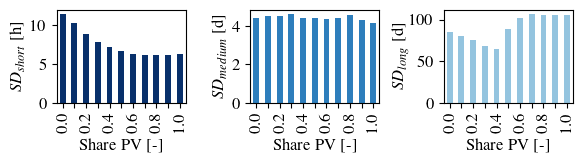

In [37]:
xlabel = "Share PV [-]"
ylabel1 = "$SD_{short}$ [h]"
ylabel2 = "$SD_{medium}$ [d]"
ylabel3 = "$SD_{long}$ [d]"
colors = matplotlib.cm.get_cmap("Blues")
color_list = [colors(1.0-0.3*storage_type) for storage_type in [0,1,2]]
figsize = (6, 1.8)
fig, ax =  plt.subplots(1, 3, figsize=figsize)
sd_df["Short"].groupby(level=0).mean().divide(pd.to_timedelta("1h")).plot.bar(
    ax=ax[0], color=color_list[0], xlabel=xlabel, ylabel=ylabel1)
ax[0].set_xticklabels([0.0, "", 0.2, "", 0.4, "", 0.6, "", 0.8, "", 1.0])
ax[0].set_yticks([0, 5, 10])
#ax[0].set_xticklabels(ax[0].get_xticklabels(), rotation=0)
sd_df["Medium"].groupby(level=0).mean().divide(pd.to_timedelta("1d")).plot.bar(
    ax=ax[1], color=color_list[1], xlabel=xlabel, ylabel=ylabel2)
ax[1].set_xticklabels([0.0, "", 0.2, "", 0.4, "", 0.6, "", 0.8, "", 1.0])
ax[1].set_yticks([0, 2, 4])
#ax[1].set_xticklabels(ax[1].get_xticklabels(), rotation=0)
sd_df["Long"].groupby(level=0).mean().divide(pd.to_timedelta("1d")).plot.bar(
    ax=ax[2], color=color_list[2], xlabel=xlabel, ylabel=ylabel3)
ax[2].set_xticklabels([0.0, "", 0.2, "", 0.4, "", 0.6, "", 0.8, "", 1.0])
ax[2].set_yticks([0,50,100])
#ax[2].set_xticklabels(ax[2].get_xticklabels(), rotation=0)
plt.tight_layout()
fig.subplots_adjust(wspace=0.5)
ax[2].yaxis.set_label_coords(-0.27, 0.5)
plt.savefig("results/plots/paper_dc_storage_durations.pdf")

## Variation starting times

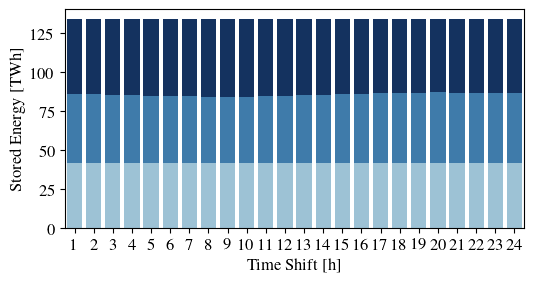

In [111]:
save_dir = "results/plots"
res_dir = r"U:\Software\Flexibility-Quantification\results\Diss2024"
scenario = "Variation_start_time_day"
f, a1 = plt.subplots(figsize=(5.5, 3))
storage_equivalent = pd.read_csv(
        f"{res_dir}/{scenario}/storage_equivalents.csv",
    index_col=0)
parameter = {"time_shift": "Time Shift [h]"}
ylabel = "Stored Energy [TWh]"
language = "english"
plot_storage_equivalent_germany_stacked(
            storage_equivalent,
            parameter=parameter,
            ylabel=ylabel,
            loc=None,
            language=language,
            ax=a1,
        )
plt.tight_layout()

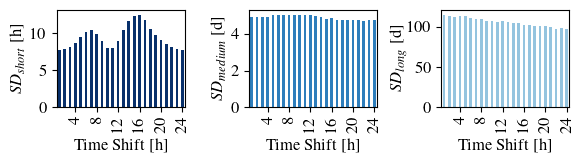

In [117]:
naming_dict = {"0": "Short", "1": "Medium", "2": "Long"}
color_dict = {"Day": 0, "Week": 1, "Seasonal": 2}
colors = matplotlib.cm.get_cmap("Blues")
color_list = [colors(1.0-0.3*storage_type) for storage_type in [0,1,2]]
tf = pd.Series({
    "Short": pd.to_timedelta("24h"),
    "Medium": pd.to_timedelta("14d"),
    "Long": pd.to_timedelta("364d")
})
tf_num = pd.Series({
    "Short": pd.to_timedelta("24h")/pd.to_timedelta("1h"),
    "Medium": pd.to_timedelta("14d")/pd.to_timedelta("1h"),
    "Long": pd.to_timedelta("364d")/pd.to_timedelta("1h")
})
sd_df = pd.read_csv(os.path.join(res_dir, scenario, "storage_durations.csv"), index_col=0, parse_dates=True)
for col in sd_df.columns:
    sd_df[col] = pd.to_timedelta(sd_df[col])
sd_df.rename(columns=naming_dict, inplace=True)
xlabel = "Time Shift [h]"
ylabel1 = "$SD_{short}$ [h]"
ylabel2 = "$SD_{medium}$ [d]"
ylabel3 = "$SD_{long}$ [d]"
colors = matplotlib.cm.get_cmap("Blues")
color_list = [colors(1.0-0.3*storage_type) for storage_type in [0,1,2]]
figsize = (6, 1.8)
fig, ax =  plt.subplots(1, 3, figsize=figsize)
sd_df["Short"].groupby(level=0).mean().divide(pd.to_timedelta("1h")).plot.bar(
    ax=ax[0], color=color_list[0], xlabel=xlabel, ylabel=ylabel1)
#ax[0].set_xticklabels([0.0, "", 0.2, "", 0.4, "", 0.6, "", 0.8, "", 1.0])
ax[0].set_yticks([0, 5, 10])
ax[0].set_xticks([i*4+3 for i in range(6)])
#ax[0].set_xticklabels(ax[0].get_xticklabels(), rotation=0)
sd_df["Medium"].groupby(level=0).mean().divide(pd.to_timedelta("1d")).plot.bar(
    ax=ax[1], color=color_list[1], xlabel=xlabel, ylabel=ylabel2)
#ax[1].set_xticklabels([0.0, "", 0.2, "", 0.4, "", 0.6, "", 0.8, "", 1.0])
ax[1].set_yticks([0, 2, 4])
ax[1].set_xticks([i*4+3 for i in range(6)])
#ax[1].set_xticklabels(ax[1].get_xticklabels(), rotation=0)
sd_df["Long"].groupby(level=0).mean().divide(pd.to_timedelta("1d")).plot.bar(
    ax=ax[2], color=color_list[2], xlabel=xlabel, ylabel=ylabel3)
#ax[2].set_xticklabels([0.0, "", 0.2, "", 0.4, "", 0.6, "", 0.8, "", 1.0])
ax[2].set_yticks([0,50,100])
ax[2].set_xticks([i*4+3 for i in range(6)])
#ax[2].set_xticklabels(ax[2].get_xticklabels(), rotation=0)
plt.tight_layout()
fig.subplots_adjust(wspace=0.5)
ax[2].yaxis.set_label_coords(-0.27, 0.5)

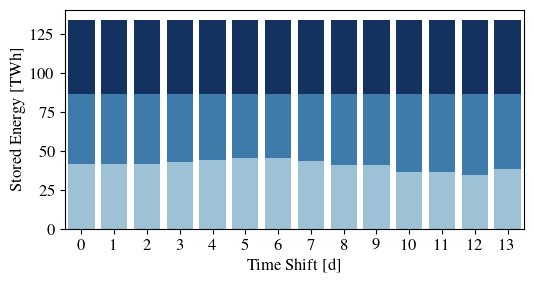

In [121]:
save_dir = "results/plots"
res_dir = r"U:\Software\Flexibility-Quantification\results\Diss2024"
scenario = "Variation_start_time_week"
f, a1 = plt.subplots(figsize=(5.5, 3))
storage_equivalent = pd.read_csv(
        f"{res_dir}/{scenario}/storage_equivalents.csv",
    index_col=0)
storage_equivalent["time_shift"] /= 24
storage_equivalent["time_shift"] = storage_equivalent["time_shift"].astype(int)
parameter = {"time_shift": "Time Shift [d]"}
ylabel = "Stored Energy [TWh]"
language = "english"
plot_storage_equivalent_germany_stacked(
            storage_equivalent,
            parameter=parameter,
            ylabel=ylabel,
            loc=None,
            language=language,
            ax=a1,
        )
plt.tight_layout()

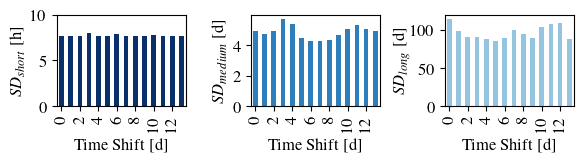

In [129]:
naming_dict = {"0": "Short", "1": "Medium", "2": "Long"}
color_dict = {"Day": 0, "Week": 1, "Seasonal": 2}
colors = matplotlib.cm.get_cmap("Blues")
color_list = [colors(1.0-0.3*storage_type) for storage_type in [0,1,2]]
tf = pd.Series({
    "Short": pd.to_timedelta("24h"),
    "Medium": pd.to_timedelta("14d"),
    "Long": pd.to_timedelta("364d")
})
tf_num = pd.Series({
    "Short": pd.to_timedelta("24h")/pd.to_timedelta("1h"),
    "Medium": pd.to_timedelta("14d")/pd.to_timedelta("1h"),
    "Long": pd.to_timedelta("364d")/pd.to_timedelta("1h")
})
sd_df = pd.read_csv(os.path.join(res_dir, scenario, "storage_durations.csv"), index_col=0, parse_dates=True)
for col in sd_df.columns:
    sd_df[col] = pd.to_timedelta(sd_df[col])
sd_df.rename(columns=naming_dict, inplace=True)
sd_df.index /= 24
sd_df.index = sd_df.index.astype(int)
xlabel = "Time Shift [d]"
ylabel1 = "$SD_{short}$ [h]"
ylabel2 = "$SD_{medium}$ [d]"
ylabel3 = "$SD_{long}$ [d]"
colors = matplotlib.cm.get_cmap("Blues")
color_list = [colors(1.0-0.3*storage_type) for storage_type in [0,1,2]]
figsize = (6, 1.8)
fig, ax =  plt.subplots(1, 3, figsize=figsize)
sd_df["Short"].groupby(level=0).mean().divide(pd.to_timedelta("1h")).plot.bar(
    ax=ax[0], color=color_list[0], xlabel=xlabel, ylabel=ylabel1)
#ax[0].set_xticklabels([0.0, "", 0.2, "", 0.4, "", 0.6, "", 0.8, "", 1.0])
ax[0].set_yticks([0, 5, 10])
ax[0].set_xticks([i*2 for i in range(7)])
#ax[0].set_xticklabels(ax[0].get_xticklabels(), rotation=0)
sd_df["Medium"].groupby(level=0).mean().divide(pd.to_timedelta("1d")).plot.bar(
    ax=ax[1], color=color_list[1], xlabel=xlabel, ylabel=ylabel2)
#ax[1].set_xticklabels([0.0, "", 0.2, "", 0.4, "", 0.6, "", 0.8, "", 1.0])
ax[1].set_yticks([0, 2, 4])
ax[1].set_xticks([i*2 for i in range(7)])
#ax[1].set_xticklabels(ax[1].get_xticklabels(), rotation=0)
sd_df["Long"].groupby(level=0).mean().divide(pd.to_timedelta("1d")).plot.bar(
    ax=ax[2], color=color_list[2], xlabel=xlabel, ylabel=ylabel3)
#ax[2].set_xticklabels([0.0, "", 0.2, "", 0.4, "", 0.6, "", 0.8, "", 1.0])
ax[2].set_yticks([0,50,100])
ax[2].set_xticks([i*2 for i in range(7)])
#ax[2].set_xticklabels(ax[2].get_xticklabels(), rotation=0)
plt.tight_layout()
fig.subplots_adjust(wspace=0.5)
ax[2].yaxis.set_label_coords(-0.27, 0.5)

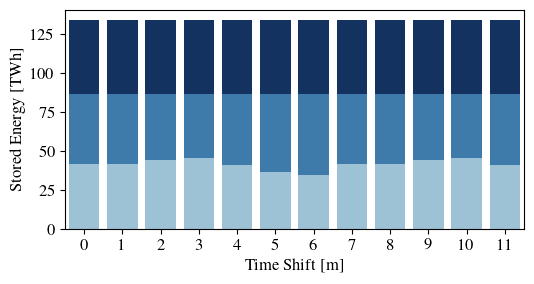

In [131]:
save_dir = "results/plots"
res_dir = r"U:\Software\Flexibility-Quantification\results\Diss2024"
scenario = "Variation_start_time_year"
f, a1 = plt.subplots(figsize=(5.5, 3))
storage_equivalent = pd.read_csv(
        f"{res_dir}/{scenario}/storage_equivalents.csv",
    index_col=0)
storage_equivalent["time_shift"] /= (24*30)
storage_equivalent["time_shift"] = storage_equivalent["time_shift"].astype(int)
parameter = {"time_shift": "Time Shift [m]"}
ylabel = "Stored Energy [TWh]"
language = "english"
plot_storage_equivalent_germany_stacked(
            storage_equivalent,
            parameter=parameter,
            ylabel=ylabel,
            loc=None,
            language=language,
            ax=a1,
        )
plt.tight_layout()

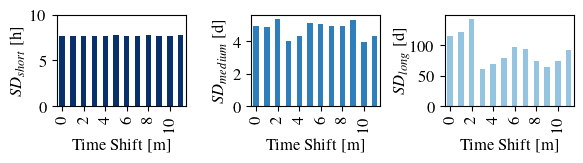

In [133]:
naming_dict = {"0": "Short", "1": "Medium", "2": "Long"}
color_dict = {"Day": 0, "Week": 1, "Seasonal": 2}
colors = matplotlib.cm.get_cmap("Blues")
color_list = [colors(1.0-0.3*storage_type) for storage_type in [0,1,2]]
tf = pd.Series({
    "Short": pd.to_timedelta("24h"),
    "Medium": pd.to_timedelta("14d"),
    "Long": pd.to_timedelta("364d")
})
tf_num = pd.Series({
    "Short": pd.to_timedelta("24h")/pd.to_timedelta("1h"),
    "Medium": pd.to_timedelta("14d")/pd.to_timedelta("1h"),
    "Long": pd.to_timedelta("364d")/pd.to_timedelta("1h")
})
sd_df = pd.read_csv(os.path.join(res_dir, scenario, "storage_durations.csv"), index_col=0, parse_dates=True)
for col in sd_df.columns:
    sd_df[col] = pd.to_timedelta(sd_df[col])
sd_df.rename(columns=naming_dict, inplace=True)
sd_df.index /= (24*30)
sd_df.index = sd_df.index.astype(int)
xlabel = "Time Shift [m]"
ylabel1 = "$SD_{short}$ [h]"
ylabel2 = "$SD_{medium}$ [d]"
ylabel3 = "$SD_{long}$ [d]"
colors = matplotlib.cm.get_cmap("Blues")
color_list = [colors(1.0-0.3*storage_type) for storage_type in [0,1,2]]
figsize = (6, 1.8)
fig, ax =  plt.subplots(1, 3, figsize=figsize)
sd_df["Short"].groupby(level=0).mean().divide(pd.to_timedelta("1h")).plot.bar(
    ax=ax[0], color=color_list[0], xlabel=xlabel, ylabel=ylabel1)
#ax[0].set_xticklabels([0.0, "", 0.2, "", 0.4, "", 0.6, "", 0.8, "", 1.0])
ax[0].set_yticks([0, 5, 10])
ax[0].set_xticks([i*2 for i in range(6)])
#ax[0].set_xticklabels(ax[0].get_xticklabels(), rotation=0)
sd_df["Medium"].groupby(level=0).mean().divide(pd.to_timedelta("1d")).plot.bar(
    ax=ax[1], color=color_list[1], xlabel=xlabel, ylabel=ylabel2)
#ax[1].set_xticklabels([0.0, "", 0.2, "", 0.4, "", 0.6, "", 0.8, "", 1.0])
ax[1].set_yticks([0, 2, 4])
ax[1].set_xticks([i*2 for i in range(6)])
#ax[1].set_xticklabels(ax[1].get_xticklabels(), rotation=0)
sd_df["Long"].groupby(level=0).mean().divide(pd.to_timedelta("1d")).plot.bar(
    ax=ax[2], color=color_list[2], xlabel=xlabel, ylabel=ylabel3)
#ax[2].set_xticklabels([0.0, "", 0.2, "", 0.4, "", 0.6, "", 0.8, "", 1.0])
ax[2].set_yticks([0,50,100])
ax[2].set_xticks([i*2 for i in range(6)])
#ax[2].set_xticklabels(ax[2].get_xticklabels(), rotation=0)
plt.tight_layout()
fig.subplots_adjust(wspace=0.5)
ax[2].yaxis.set_label_coords(-0.27, 0.5)

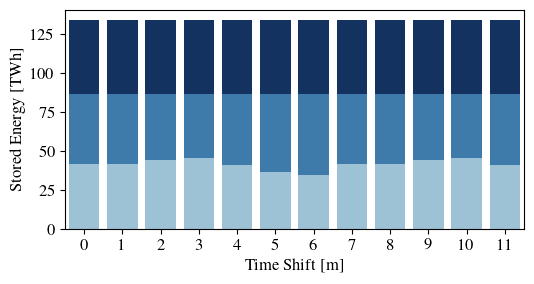

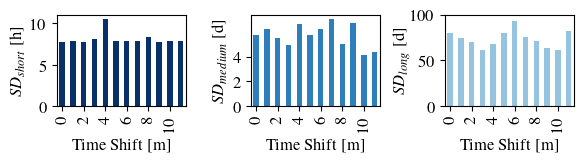

In [134]:
save_dir = "results/plots"
res_dir = r"U:\Software\Flexibility-Quantification\results\Diss2024"
scenario = "Variation_start_time_year_v1"
f, a1 = plt.subplots(figsize=(5.5, 3))
storage_equivalent = pd.read_csv(
        f"{res_dir}/{scenario}/storage_equivalents.csv",
    index_col=0)
storage_equivalent["time_shift"] /= (24*30)
storage_equivalent["time_shift"] = storage_equivalent["time_shift"].astype(int)
parameter = {"time_shift": "Time Shift [m]"}
ylabel = "Stored Energy [TWh]"
language = "english"
plot_storage_equivalent_germany_stacked(
            storage_equivalent,
            parameter=parameter,
            ylabel=ylabel,
            loc=None,
            language=language,
            ax=a1,
        )
plt.tight_layout()

naming_dict = {"0": "Short", "1": "Medium", "2": "Long"}
color_dict = {"Day": 0, "Week": 1, "Seasonal": 2}
colors = matplotlib.cm.get_cmap("Blues")
color_list = [colors(1.0-0.3*storage_type) for storage_type in [0,1,2]]
tf = pd.Series({
    "Short": pd.to_timedelta("24h"),
    "Medium": pd.to_timedelta("14d"),
    "Long": pd.to_timedelta("364d")
})
tf_num = pd.Series({
    "Short": pd.to_timedelta("24h")/pd.to_timedelta("1h"),
    "Medium": pd.to_timedelta("14d")/pd.to_timedelta("1h"),
    "Long": pd.to_timedelta("364d")/pd.to_timedelta("1h")
})
sd_df = pd.read_csv(os.path.join(res_dir, scenario, "storage_durations.csv"), index_col=0, parse_dates=True)
for col in sd_df.columns:
    sd_df[col] = pd.to_timedelta(sd_df[col])
sd_df.rename(columns=naming_dict, inplace=True)
sd_df.index /= (24*30)
sd_df.index = sd_df.index.astype(int)
xlabel = "Time Shift [m]"
ylabel1 = "$SD_{short}$ [h]"
ylabel2 = "$SD_{medium}$ [d]"
ylabel3 = "$SD_{long}$ [d]"
colors = matplotlib.cm.get_cmap("Blues")
color_list = [colors(1.0-0.3*storage_type) for storage_type in [0,1,2]]
figsize = (6, 1.8)
fig, ax =  plt.subplots(1, 3, figsize=figsize)
sd_df["Short"].groupby(level=0).mean().divide(pd.to_timedelta("1h")).plot.bar(
    ax=ax[0], color=color_list[0], xlabel=xlabel, ylabel=ylabel1)
#ax[0].set_xticklabels([0.0, "", 0.2, "", 0.4, "", 0.6, "", 0.8, "", 1.0])
ax[0].set_yticks([0, 5, 10])
ax[0].set_xticks([i*2 for i in range(6)])
#ax[0].set_xticklabels(ax[0].get_xticklabels(), rotation=0)
sd_df["Medium"].groupby(level=0).mean().divide(pd.to_timedelta("1d")).plot.bar(
    ax=ax[1], color=color_list[1], xlabel=xlabel, ylabel=ylabel2)
#ax[1].set_xticklabels([0.0, "", 0.2, "", 0.4, "", 0.6, "", 0.8, "", 1.0])
ax[1].set_yticks([0, 2, 4])
ax[1].set_xticks([i*2 for i in range(6)])
#ax[1].set_xticklabels(ax[1].get_xticklabels(), rotation=0)
sd_df["Long"].groupby(level=0).mean().divide(pd.to_timedelta("1d")).plot.bar(
    ax=ax[2], color=color_list[2], xlabel=xlabel, ylabel=ylabel3)
#ax[2].set_xticklabels([0.0, "", 0.2, "", 0.4, "", 0.6, "", 0.8, "", 1.0])
ax[2].set_yticks([0,50,100])
ax[2].set_xticks([i*2 for i in range(6)])
#ax[2].set_xticklabels(ax[2].get_xticklabels(), rotation=0)
plt.tight_layout()
fig.subplots_adjust(wspace=0.5)
ax[2].yaxis.set_label_coords(-0.27, 0.5)

## SC Integration

In [51]:
def load_scenarios_and_diff(scenario_ref, scenario_flex, variation_parameter, res_dir="results/two_weeks"):
    """
    Method to load storage equivalents of reference (inflexible) and flexible scenario and calculate 
    growth for reference scneario and difference between reference and flexible scenario.
    """
    # load reference scenario
    storage_equivalent_ref = pd.read_csv(
        f"{res_dir}/{scenario_ref}/storage_equivalents.csv",
        index_col=0).reset_index().drop(columns="index")
    # calculate growth
    growth = storage_equivalent_ref.copy()
    ref = storage_equivalent_ref.loc[getattr(storage_equivalent_ref, variation_parameter) == 0]
    for val in getattr(storage_equivalent_ref, variation_parameter).unique():
        tmp = storage_equivalent_ref.loc[getattr(storage_equivalent_ref, variation_parameter) == val]
        growth.loc[tmp.index, "energy_stored"] = \
            tmp["energy_stored"].values-ref["energy_stored"].values
    # load flexible scenario
    storage_equivalent_flex = pd.read_csv(
        f"{res_dir}/{scenario_flex}/storage_equivalents.csv",
        index_col=0).reset_index().drop(columns="index")
    # calculate difference between flexible and reference operation
    diff = storage_equivalent_flex.copy()
    diff["energy_stored"] = storage_equivalent_flex["energy_stored"] - \
                            storage_equivalent_ref["energy_stored"]
    return storage_equivalent_ref, growth, storage_equivalent_flex, diff

In [52]:
def get_relative_storage_equivalent(df, var, energy_ref):
    df_percent = df.copy()
    df_percent[var] = df_percent[var].divide(energy_ref).multiply(100)
    return df_percent

In [53]:
def load_diff_single_storage_types(scenario_reference, scenarios_flex, var, res_dir="results/two_weeks"):
    diffs = {}
    for scenario_flex in scenarios_flex:
        diff = pd.DataFrame()
        for storage_type in range(3):
            scenario_flex_tmp = "_".join([scenario_flex, str(storage_type)])
            storage_equivalent_ref, growth, storage_equivalent_flex, diff_tmp=load_scenarios_and_diff(
                scenario_reference, scenario_flex_tmp, var, res_dir)
            diff = pd.concat([diff, diff_tmp], ignore_index=True)
        diff = diff.groupby([var, "storage_type"]).sum().reset_index()
        diffs[scenario_flex] = diff
    return storage_equivalent_ref, growth, diffs

## Electric Vehicles

In [54]:
import matplotlib.gridspec as gridspec
def plot_storage_equivalent_germany_stacked_five_v1(
        df_0, df_1, df_2, df_3, df_4,
        parameter={"scenario": "Deutschland"},
        ylabel="Stored Energy [TWh]",
        ylabel1="Change in Stored Energy [TWh]",
        figsize=(8, 9),
        ylim=None,
        language="english",
        loc="upper left",
        save_dir=None,
        titles = ["Reference Operation", "Optimised Operation", "Growth Reference Operation", "Reduction Optimised Operation", ""]
):
    param = list(parameter.items())[0][0]
    xlabel = list(parameter.items())[0][1]
    
    fig, axes = plt.subplots(figsize=figsize)
    gs = gridspec.GridSpec(7, 4, figure=fig, hspace=0.2)
    gs_top = gridspec.GridSpec(7, 4, figure=fig, hspace=1.0)
    ax0 = plt.subplot(gs_top[:3, 1:3])
    ax1 = plt.subplot(gs[3:5, :2])
    ax2 = plt.subplot(gs[3:5, 2:])
    ax3 = plt.subplot(gs[5:, :2])
    ax4 = plt.subplot(gs[5:, 2:])
    
    axes_dict = {ax0: {"title": titles[0], "values": df_0, "ylim": 0},
                 ax1: {"title": titles[1], "values": df_1, "ylim": 1},
                 ax2: {"title": titles[2], "values": df_2, "ylim": 2},
                 ax3: {"title": titles[3], "values": df_3, "ylim": 3},
                 ax4: {"title": titles[4], "values": df_4, "ylim": 3}}
    
    if (language == "german") or (language == "deutsch"):
        type_dict = {0: "Tag", 1: "Woche", 2: "Saisonal"}
    else:
        type_dict = {0: "Short", 1: "Medium", 2: "Long"}
    colors = matplotlib.cm.get_cmap("Blues")
    for ax in axes_dict.keys():
        storage_equivalent = axes_dict[ax]["values"]
        for storage_type in range(storage_equivalent.storage_type.max()+1):

            plot_df = pd.DataFrame(index=storage_equivalent[param].unique())
            for val in storage_equivalent[param].unique():
                tmp = storage_equivalent.loc[(storage_equivalent[param] == val)&
                                            (storage_equivalent.storage_type >= storage_type)&
                                            (np.sign(storage_equivalent.energy_stored) == np.sign(storage_equivalent.loc[
                                                (storage_equivalent[param] == val)&
                                                (storage_equivalent.storage_type == storage_type), "energy_stored"
                                            ].values[0]))]
                plot_df.loc[val, ylabel] = tmp.energy_stored.sum()/1e3
            plot_df[xlabel] = storage_equivalent[param].unique()

            sns.barplot(x=xlabel, y=ylabel, color=colors(1.0-0.3*storage_type),
                        data=plot_df, ax=ax, label=type_dict[storage_type])
        ax.set_title(axes_dict[ax]["title"])
        if ylim is not None:
            ax.set_ylim(ylim[axes_dict[ax]["ylim"]])
        if (ax==ax2) or (ax==ax4):
            ax.set_ylabel("")
        elif (ax==ax1) or (ax==ax3):
            ax.set_ylabel(ylabel1)
        if (ax==ax1) or (ax==ax2):
            ax.set_xlabel("")
            ax.set_xticklabels([])
        else:
            if param in ["nr_ev"]:
                xticklabels = ax.get_xticklabels()
                ax.set_xticklabels([int(float(tick.get_text())) for tick in xticklabels])
    ax0.legend(loc=loc)#loc="lower left"
    #gs.tight_layout(fig)
    gs.update(hspace=0.5, wspace=0.5)
    gs_top.update(hspace=0.5, wspace=0.5)
    for ax in [ax3, ax4, ax0]:
        ax.set_xlabel("EV Penetration [\%]")
        ax.set_xticklabels([0, "", 20, "", 40, "", 60, "", 80, "", 100 ])
    for ax in [ax2, ax1]:
        ax.set_xticks([])
    if save_dir is not None:
        if "png" in save_dir:
            plt.savefig(save_dir, dpi=300)
        else:
            plt.savefig(save_dir)
    return gs, fig

In [66]:
import matplotlib.gridspec as gridspec
def plot_storage_equivalent_germany_stacked_five_v1(
        df_0, df_1, df_2, df_3, df_4,
        parameter={"scenario": "Deutschland"},
        ylabel="Stored Energy [TWh]",
        ylabel1="Change in Stored Energy [TWh]",
        figsize=(8, 9),
        ylim=None,
        language="english",
        loc="upper left",
        save_dir=None,
        titles = ["Reference Operation", "Optimised Operation", "Growth Reference Operation", "Reduction Optimised Operation", ""]
):
    param = list(parameter.items())[0][0]
    xlabel = list(parameter.items())[0][1]
    
    fig = plt.figure(figsize=figsize)
    ax0 = plt.subplot2grid((6,4), (0,1), colspan=2, rowspan=2)
    ax1 = plt.subplot2grid((6,4), (2,0), colspan=2, rowspan=2)
    ax2 = plt.subplot2grid((6,4), (2,2), colspan=2, rowspan=2)
    ax3 = plt.subplot2grid((6,4), (4,0), colspan=2, rowspan=2)
    ax4 = plt.subplot2grid((6,4), (4,2), colspan=2, rowspan=2)
    
    #annotate_axes(fig)
    
    axes_dict = {ax0: {"title": titles[0], "values": df_0, "ylim": 0},
                 ax1: {"title": titles[1], "values": df_1, "ylim": 1},
                 ax2: {"title": titles[2], "values": df_2, "ylim": 2},
                 ax3: {"title": titles[3], "values": df_3, "ylim": 3},
                 ax4: {"title": titles[4], "values": df_4, "ylim": 3}}
    
    if (language == "german") or (language == "deutsch"):
        type_dict = {0: "Tag", 1: "Woche", 2: "Saisonal"}
    else:
        type_dict = {0: "Short", 1: "Medium", 2: "Long"}
    colors = matplotlib.cm.get_cmap("Blues")
    for ax in axes_dict.keys():
        storage_equivalent = axes_dict[ax]["values"]
        for storage_type in range(storage_equivalent.storage_type.max()+1):

            plot_df = pd.DataFrame(index=storage_equivalent[param].unique())
            for val in storage_equivalent[param].unique():
                tmp = storage_equivalent.loc[(storage_equivalent[param] == val)&
                                            (storage_equivalent.storage_type >= storage_type)&
                                            (np.sign(storage_equivalent.energy_stored) == np.sign(storage_equivalent.loc[
                                                (storage_equivalent[param] == val)&
                                                (storage_equivalent.storage_type == storage_type), "energy_stored"
                                            ].values[0]))]
                plot_df.loc[val, ylabel] = tmp.energy_stored.sum()/1e3
            plot_df[xlabel] = storage_equivalent[param].unique()

            sns.barplot(x=xlabel, y=ylabel, color=colors(1.0-0.3*storage_type),
                        data=plot_df, ax=ax, label=type_dict[storage_type])
        ax.set_title(axes_dict[ax]["title"])
        if ylim is not None:
            ax.set_ylim(ylim[axes_dict[ax]["ylim"]])
        if (ax==ax2) or (ax==ax4):
            ax.set_ylabel("")
        elif (ax==ax1) or (ax==ax3):
            ax.set_ylabel(ylabel1)
    ax0.legend(loc=loc)#loc="lower left"
    plt.tight_layout()
    for ax in [ax3, ax4, ax0, ax1, ax2]:
        if (ax==ax1) or (ax==ax2):
            ax.set_xlabel("")
        else:
            ax.set_xlabel("EV Penetration [\%]")
        ax.set_xticklabels([0, "", 20, "", 40, "", 60, "", 80, "", 100 ])
        if ax == ax0:
            ax.set_yticks([0,25,50,75])
        else:
            ax.set_yticks([-75, -50, -25, 0])
    plt.subplots_adjust(hspace=2.0, wspace=0.7)
    #for ax in [ax2, ax1]:
    #    ax.set_xticks([])
    if save_dir is not None:
        if "png" in save_dir:
            plt.savefig(save_dir, dpi=300)
        else:
            plt.savefig(save_dir)
    return fig

In [73]:
import matplotlib.gridspec as gridspec
def plot_storage_equivalent_germany_stacked_five_abs(
        df_0, df_1, df_2, df_3, df_4,
        parameter={"scenario": "Deutschland"},
        ylabel="Stored Energy [TWh]",
        ylabel1="Change in Stored Energy [TWh]",
        figsize=(8, 9),
        ylim=None,
        language="english",
        loc="upper left",
        save_dir=None,
        titles = ["Reference Operation", "Optimised Operation", "Growth Reference Operation", "Reduction Optimised Operation", ""]
):
    param = list(parameter.items())[0][0]
    xlabel = list(parameter.items())[0][1]
    
    fig = plt.figure(figsize=figsize)
    ax0 = plt.subplot2grid((6,4), (0,1), colspan=2, rowspan=2)
    ax1 = plt.subplot2grid((6,4), (2,0), colspan=2, rowspan=2)
    ax2 = plt.subplot2grid((6,4), (2,2), colspan=2, rowspan=2)
    ax3 = plt.subplot2grid((6,4), (4,0), colspan=2, rowspan=2)
    ax4 = plt.subplot2grid((6,4), (4,2), colspan=2, rowspan=2)
    
    #annotate_axes(fig)
    
    axes_dict = {ax0: {"title": titles[0], "values": df_0, "ylim": 0},
                 ax1: {"title": titles[1], "values": df_1, "ylim": 1},
                 ax2: {"title": titles[2], "values": df_2, "ylim": 2},
                 ax3: {"title": titles[3], "values": df_3, "ylim": 3},
                 ax4: {"title": titles[4], "values": df_4, "ylim": 3}}
    
    if (language == "german") or (language == "deutsch"):
        type_dict = {0: "Tag", 1: "Woche", 2: "Saisonal"}
    else:
        type_dict = {0: "Short", 1: "Medium", 2: "Long"}
    colors = matplotlib.cm.get_cmap("Blues")
    for ax in axes_dict.keys():
        storage_equivalent = axes_dict[ax]["values"]
        for storage_type in range(storage_equivalent.storage_type.max()+1):

            plot_df = pd.DataFrame(index=storage_equivalent[param].unique())
            for val in storage_equivalent[param].unique():
                tmp = storage_equivalent.loc[(storage_equivalent[param] == val)&
                                            (storage_equivalent.storage_type >= storage_type)&
                                            (np.sign(storage_equivalent.energy_stored) == np.sign(storage_equivalent.loc[
                                                (storage_equivalent[param] == val)&
                                                (storage_equivalent.storage_type == storage_type), "energy_stored"
                                            ].values[0]))]
                plot_df.loc[val, ylabel] = tmp.energy_stored.sum()/1e3
            plot_df[xlabel] = storage_equivalent[param].unique()

            sns.barplot(x=xlabel, y=ylabel, color=colors(1.0-0.3*storage_type),
                        data=plot_df, ax=ax, label=type_dict[storage_type])
        ax.set_title(axes_dict[ax]["title"])
        if ylim is not None:
            ax.set_ylim(ylim[axes_dict[ax]["ylim"]])
        if (ax==ax2) or (ax==ax4):
            ax.set_ylabel("")
        elif (ax==ax1) or (ax==ax3):
            ax.set_ylabel(ylabel1)
    ax0.legend(loc=loc)#loc="lower left"
    plt.tight_layout()
    for ax in [ax3, ax4, ax0, ax1, ax2]:
        if (ax==ax1) or (ax==ax2):
            ax.set_xlabel("")
        else:
            ax.set_xlabel("EV Penetration [\%]")
        ax.set_xticklabels([0, "", 20, "", 40, "", 60, "", 80, "", 100 ])
        ax.set_yticks([-50, -25, 0,  25])
    plt.subplots_adjust(hspace=2.0, wspace=0.7)
    #for ax in [ax2, ax1]:
    #    ax.set_xticks([])
    if save_dir is not None:
        if "png" in save_dir:
            plt.savefig(save_dir, dpi=300)
        else:
            plt.savefig(save_dir)
    return fig

In [56]:
res_dir = r"H:\Flexibility-Quantification\final_run_paper_v1"
flexible_scenarios = ["EV_flexible", "EV_flexible_with_public", "EV_flexible_with_shifting", "EV_flexible_with_v2g"]
var = "nr_ev"
storage_equivalent_ref, growth, storage_equivalent_flex, diff=load_scenarios_and_diff("EV_reference", flexible_scenarios[0], var, res_dir=res_dir)
storage_equivalent_ref, growth, storage_equivalent_flex_2, diff_2=load_scenarios_and_diff("EV_reference", flexible_scenarios[1], var, res_dir=res_dir)
storage_equivalent_ref, growth, storage_equivalent_flex_3, diff_3=load_scenarios_and_diff("EV_reference", flexible_scenarios[2], var, res_dir=res_dir)
storage_equivalent_ref, growth, storage_equivalent_flex_4, diff_4=load_scenarios_and_diff("EV_reference", flexible_scenarios[3], var, res_dir=res_dir)

In [57]:
storage_equivalent_ref[["energy_stored", "nr_ev"]].groupby("nr_ev").sum().divide(1000)

energy_stored
nr_ev               
0.00      131.481029
4.88      134.522000
9.76      137.603813
14.64     140.711510
19.52     143.845958
24.40     147.007735
29.28     150.191169
34.16     153.392906
39.04     156.612876
43.92     159.854574
48.80     163.112134

In [22]:
storage_equivalent_flex_4[["energy_stored", "nr_ev"]].groupby("nr_ev").sum().divide(1000)

energy_stored
nr_ev               
0.00      131.481029
4.88       98.622394
9.76       84.794761
14.64      77.972026
19.52      72.779232
24.40      68.491243
29.28      65.404255
34.16      63.165830
39.04      61.350029
43.92      59.533496
48.80      57.831570

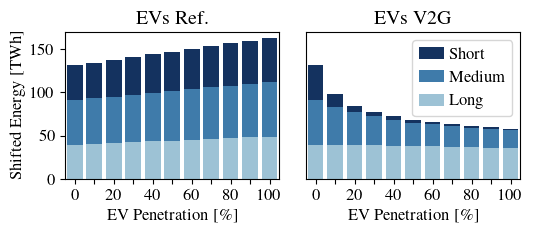

In [24]:
# plot reference and V2G
save_dir = "results/plots"
parameter = {"nr_ev": "Number EVs [Mio.]"}
ylabel = "Shifted Energy [TWh]"
language = "english"
fig, axes = plt.subplots(1, 2, figsize=(5.5,2.5))
save_dir_tmp = os.path.join(save_dir, "paper_dc_storage_equivalent_EVs_double.pdf")
ax = axes[0]
plot_storage_equivalent_germany_stacked(
            storage_equivalent_ref,
            parameter=parameter,
            ylabel=ylabel,
            loc=None,
            language=language,
            ax=ax,
            title="EVs Ref."
        )
ax = axes[1]
plot_storage_equivalent_germany_stacked(
            storage_equivalent_flex_4,
            parameter=parameter,
            ylabel=ylabel,
            loc="upper right",
            language=language,
            ax=ax,
            title="EVs V2G"
        )
axes[0].set_title("EVs Ref.")
for ax in axes:
    ax.set_xlabel("EV Penetration [\%]")
    #ax.set_xticklabels([10*i for i in range(11)])
    ax.set_xticklabels([0, "", 20, "", 40, "", 60, "", 80, "", 100 ])
    ax.set_ylim(0,170)
ax = axes[1]
axes[1].legend(columnspacing=0.5, handletextpad=0.3, handlelength=1.5)
#a1 = ax.twinx()
#a1.set_ylim(ax.get_ylim())
#a1.set_ylabel("~~Shifted Energy \n[\% of Base Case]", rotation=270, labelpad=25)
#a1.yaxis.set_label_position("right")
#a1.yaxis.tick_right()
ax.set_ylabel("")
ax.set_yticks([])
energy_ref = storage_equivalent_ref.groupby("nr_ev").sum().loc[0, "energy_stored"]/1e3
#a1.set_yticks([0, energy_ref/2, energy_ref])
#a1.set_yticklabels([0, 50, 100])
plt.tight_layout()
#ax.legend(ncols=3, loc="upper left", columnspacing=0.5, handletextpad=0.3, handlelength=1.5)
#plt.savefig(save_dir_tmp)

In [59]:
energy_ref = storage_equivalent_ref.groupby("nr_ev").sum().loc[0, "energy_stored"]/1e3
growth_rel = get_relative_storage_equivalent(growth, "energy_stored", energy_ref)
diff_rel = get_relative_storage_equivalent(diff, "energy_stored", energy_ref)
diff_2_rel = get_relative_storage_equivalent(diff_2, "energy_stored", energy_ref)
diff_3_rel = get_relative_storage_equivalent(diff_3, "energy_stored", energy_ref)
diff_4_rel = get_relative_storage_equivalent(diff_4, "energy_stored", energy_ref)

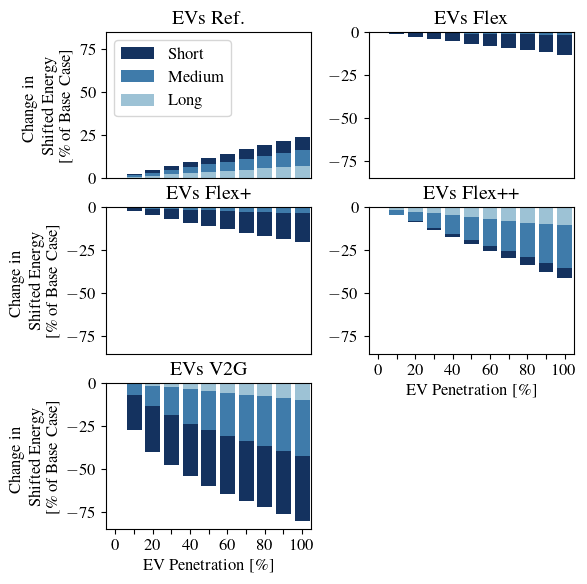

In [45]:
parameter = {"nr_ev": "Number EVs [Mio.]"}
ylabel = "~~~~~Change in\n~~Shifted Energy\n[\% of Base Case]"
language = "english"
save_dir_tmp = os.path.join(save_dir, "paper_dc_storage_equivalent_EVs_flex.pdf")
ylim = 85
ylim_neg = 0
axes=plot_storage_equivalent_germany_stacked_five(growth_rel, diff_rel, diff_2_rel, diff_3_rel, diff_4_rel,
                                             parameter=parameter,
                                             ylabel=ylabel,
                                             ylabel1=ylabel,
                                             ylim=[(-ylim_neg, ylim), (-ylim, ylim_neg), (-ylim, ylim_neg), (-ylim, ylim_neg)],
                                             titles=["EVs Ref.", "EVs Flex", "EVs Flex+", "EVs Flex++", "EVs V2G"],
                                             #save_dir=save_dir_tmp,
                                                 figsize=(6,6))
plt.subplots_adjust(hspace=0.2)
for ax in [axes[(2,0)], axes[(1,1)]]:
    ax.set_xlabel("EV Penetration [\%]")
    ax.set_xticklabels([0, "", 20, "", 40, "", 60, "", 80, "", 100 ])
for ax in [axes[(0,0)], axes[(0,1)], axes[(1,0)]]:
    ax.set_xticks([])
#plt.savefig(save_dir_tmp)

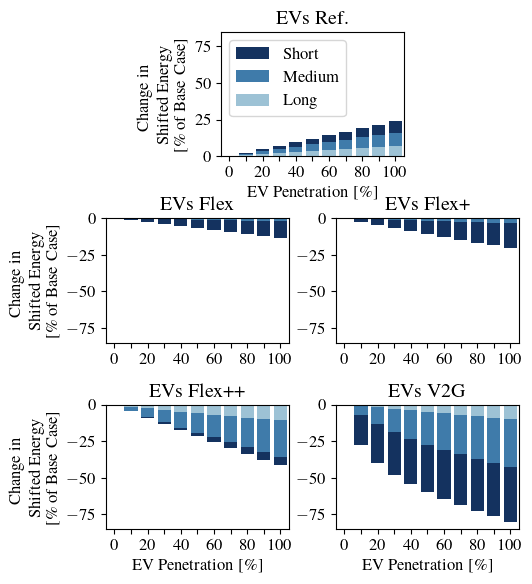

In [140]:
parameter = {"nr_ev": "Number EVs [Mio.]"}
ylabel = "~~~~~Change in\n~~Shifted Energy\n[\% of Base Case]"
language = "english"
save_dir_tmp = os.path.join(save_dir, "paper_dc_storage_equivalent_EVs_flex.pdf")
ylim = 85
ylim_neg = 0
gs,fig =plot_storage_equivalent_germany_stacked_five_v1(growth_rel, diff_rel, diff_2_rel, diff_3_rel, diff_4_rel,
                                             parameter=parameter,
                                             ylabel=ylabel,
                                             ylabel1=ylabel,
                                             ylim=[(-ylim_neg, ylim), (-ylim, ylim_neg), (-ylim, ylim_neg), (-ylim, ylim_neg)],
                                             titles=["EVs Ref.", "EVs Flex", "EVs Flex+", "EVs Flex++", "EVs V2G"],
                                             #save_dir=save_dir_tmp,
                                                 figsize=(5.5,6))
#gs.update(hspace=0.5, wspace=0.5)
#gs.tight_layout(fig)
plt.savefig(save_dir_tmp)

In [64]:
abs_diff_rel = {}
diffs_rel = {
    "flex": diff_rel,
    "flex+": diff_2_rel,
    "flex++": diff_3_rel,
    "v2g": diff_4_rel
}
for scenario in diffs_rel.keys():
    tmp = diffs_rel[scenario].copy()
    tmp["energy_stored"] += growth_rel["energy_stored"]
    abs_diff_rel[scenario] = tmp

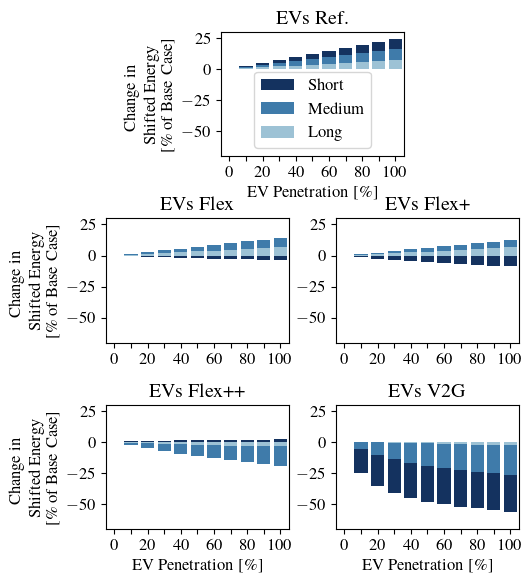

In [74]:
parameter = {"nr_ev": "Number EVs [Mio.]"}
ylabel = "~~~~~Change in\n~~Shifted Energy\n[\% of Base Case]"
language = "english"
save_dir_tmp = os.path.join(save_dir, "paper_dc_storage_equivalent_EVs_flex.pdf")
ylim = 30
ylim_neg = 70
fig =plot_storage_equivalent_germany_stacked_five_abs(growth_rel, abs_diff_rel["flex"], abs_diff_rel["flex+"], 
                                                        abs_diff_rel["flex++"], abs_diff_rel["v2g"],
                                             parameter=parameter,
                                             ylabel=ylabel,
                                             ylabel1=ylabel,
                                             ylim=[(-ylim_neg, ylim), (-ylim_neg, ylim), (-ylim_neg, ylim), (-ylim_neg, ylim)],
                                             titles=["EVs Ref.", "EVs Flex", "EVs Flex+", "EVs Flex++", "EVs V2G"],
                                             #save_dir=save_dir_tmp,
                                                 figsize=(5.5,6),
                                                     loc="lower center")

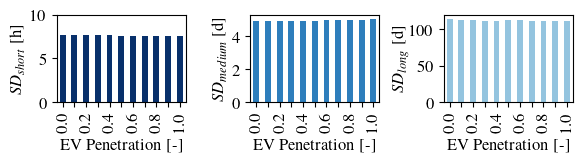

In [103]:
scenario = "EV_reference"
res_dir_base = r"U:\Software\Flexibility-Quantification\results\Diss2024"
naming_dict = {"0": "Short", "1": "Medium", "2": "Long"}
color_dict = {"Day": 0, "Week": 1, "Seasonal": 2}
colors = matplotlib.cm.get_cmap("Blues")
color_list = [colors(1.0-0.3*storage_type) for storage_type in [0,1,2]]
tf = pd.Series({
    "Short": pd.to_timedelta("24h"),
    "Medium": pd.to_timedelta("14d"),
    "Long": pd.to_timedelta("364d")
})
tf_num = pd.Series({
    "Short": pd.to_timedelta("24h")/pd.to_timedelta("1h"),
    "Medium": pd.to_timedelta("14d")/pd.to_timedelta("1h"),
    "Long": pd.to_timedelta("364d")/pd.to_timedelta("1h")
})
sd_df = pd.read_csv(os.path.join(res_dir_base, scenario, "storage_durations.csv"), index_col=0, parse_dates=True)
for col in sd_df.columns:
    sd_df[col] = pd.to_timedelta(sd_df[col])
sd_df.rename(columns=naming_dict, inplace=True)
sd_df

xlabel = "EV Penetration [-]"
ylabel1 = "$SD_{short}$ [h]"
ylabel2 = "$SD_{medium}$ [d]"
ylabel3 = "$SD_{long}$ [d]"
colors = matplotlib.cm.get_cmap("Blues")
color_list = [colors(1.0-0.3*storage_type) for storage_type in [0,1,2]]
figsize = (6, 1.8)
fig, ax =  plt.subplots(1, 3, figsize=figsize)
sd_df["Short"].groupby(level=0).mean().divide(pd.to_timedelta("1h")).plot.bar(
    ax=ax[0], color=color_list[0], xlabel=xlabel, ylabel=ylabel1)
ax[0].set_xticklabels([0.0, "", 0.2, "", 0.4, "", 0.6, "", 0.8, "", 1.0])
ax[0].set_yticks([0, 5, 10])
#ax[0].set_xticklabels(ax[0].get_xticklabels(), rotation=0)
sd_df["Medium"].groupby(level=0).mean().divide(pd.to_timedelta("1d")).plot.bar(
    ax=ax[1], color=color_list[1], xlabel=xlabel, ylabel=ylabel2)
ax[1].set_xticklabels([0.0, "", 0.2, "", 0.4, "", 0.6, "", 0.8, "", 1.0])
ax[1].set_yticks([0, 2, 4])
#ax[1].set_xticklabels(ax[1].get_xticklabels(), rotation=0)
sd_df["Long"].groupby(level=0).mean().divide(pd.to_timedelta("1d")).plot.bar(
    ax=ax[2], color=color_list[2], xlabel=xlabel, ylabel=ylabel3)
ax[2].set_xticklabels([0.0, "", 0.2, "", 0.4, "", 0.6, "", 0.8, "", 1.0])
ax[2].set_yticks([0,50,100])
#ax[2].set_xticklabels(ax[2].get_xticklabels(), rotation=0)
plt.tight_layout()
fig.subplots_adjust(wspace=0.5)
ax[2].yaxis.set_label_coords(-0.27, 0.5)
#plt.savefig("results/plots/paper_dc_storage_durations.pdf")

FileNotFoundError: [Errno 2] No such file or directory: 'U:\\Software\\Flexibility-Quantification\\results\\Diss2024\\EV_flexible_with_shifting\\storage_durations.csv'

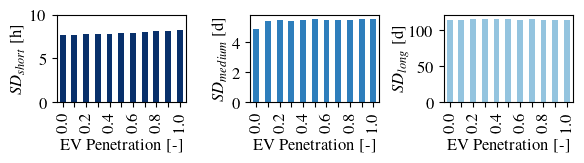

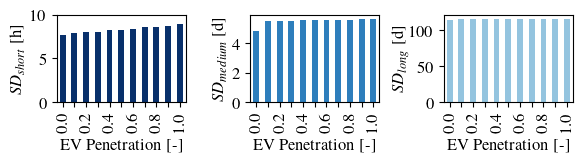

In [106]:
flexible_scenarios = ["EV_flexible", "EV_flexible_with_public", "EV_flexible_with_shifting", "EV_flexible_with_v2g"]
res_dir_base = r"U:\Software\Flexibility-Quantification\results\Diss2024"
naming_dict = {"0": "Short", "1": "Medium", "2": "Long"}
color_dict = {"Day": 0, "Week": 1, "Seasonal": 2}
colors = matplotlib.cm.get_cmap("Blues")
color_list = [colors(1.0-0.3*storage_type) for storage_type in [0,1,2]]
tf = pd.Series({
    "Short": pd.to_timedelta("24h"),
    "Medium": pd.to_timedelta("14d"),
    "Long": pd.to_timedelta("364d")
})
tf_num = pd.Series({
    "Short": pd.to_timedelta("24h")/pd.to_timedelta("1h"),
    "Medium": pd.to_timedelta("14d")/pd.to_timedelta("1h"),
    "Long": pd.to_timedelta("364d")/pd.to_timedelta("1h")
})
for scenario in flexible_scenarios:
    sd_df = pd.read_csv(os.path.join(res_dir_base, scenario, "storage_durations.csv"), index_col=0, parse_dates=True)
    for col in sd_df.columns:
        sd_df[col] = pd.to_timedelta(sd_df[col])
    sd_df.rename(columns=naming_dict, inplace=True)
    sd_df

    xlabel = "EV Penetration [-]"
    ylabel1 = "$SD_{short}$ [h]"
    ylabel2 = "$SD_{medium}$ [d]"
    ylabel3 = "$SD_{long}$ [d]"
    colors = matplotlib.cm.get_cmap("Blues")
    color_list = [colors(1.0-0.3*storage_type) for storage_type in [0,1,2]]
    figsize = (6, 1.8)
    fig, ax =  plt.subplots(1, 3, figsize=figsize)
    sd_df["Short"].groupby(level=0).mean().divide(pd.to_timedelta("1h")).plot.bar(
        ax=ax[0], color=color_list[0], xlabel=xlabel, ylabel=ylabel1)
    ax[0].set_xticklabels([0.0, "", 0.2, "", 0.4, "", 0.6, "", 0.8, "", 1.0])
    ax[0].set_yticks([0, 5, 10])
    #ax[0].set_xticklabels(ax[0].get_xticklabels(), rotation=0)
    sd_df["Medium"].groupby(level=0).mean().divide(pd.to_timedelta("1d")).plot.bar(
        ax=ax[1], color=color_list[1], xlabel=xlabel, ylabel=ylabel2)
    ax[1].set_xticklabels([0.0, "", 0.2, "", 0.4, "", 0.6, "", 0.8, "", 1.0])
    ax[1].set_yticks([0, 2, 4])
    #ax[1].set_xticklabels(ax[1].get_xticklabels(), rotation=0)
    sd_df["Long"].groupby(level=0).mean().divide(pd.to_timedelta("1d")).plot.bar(
        ax=ax[2], color=color_list[2], xlabel=xlabel, ylabel=ylabel3)
    ax[2].set_xticklabels([0.0, "", 0.2, "", 0.4, "", 0.6, "", 0.8, "", 1.0])
    ax[2].set_yticks([0,50,100])
    #ax[2].set_xticklabels(ax[2].get_xticklabels(), rotation=0)
    plt.tight_layout()
    fig.subplots_adjust(wspace=0.5)
    ax[2].yaxis.set_label_coords(-0.27, 0.5)
    #plt.savefig("results/plots/paper_dc_storage_durations.pdf")

In [26]:
scatter_df_total = pd.DataFrame()
x = "Level of Flexibility"
var = "energy_stored"
# initialise scatter df total
tmp = growth.groupby("nr_ev").sum()
tmp[var] = 0
tmp[x] = 0
scatter_df_total = pd.concat([scatter_df_total, tmp])
# iterate through flexibility scenarios
flexibility_levels = [1,2,3,4]
diff_dfs = [diff, diff_2, diff_3, diff_4]
ref = storage_equivalent_ref.groupby("nr_ev").sum()
for fl, diff_df in zip(flexibility_levels, diff_dfs):
    tmp = diff_df.groupby("nr_ev").sum()
    tmp[var] = tmp[var].divide(ref[var])*100
    tmp[x] = fl
    scatter_df_total = pd.concat([scatter_df_total, tmp])

In [27]:
var="nr_ev"
res_dir = r"C:\Users\aheider\Documents\Software\Flexibility-Quantification\results\final_run_paper_v1"
scenarios = ["EV_flexible_reduction", "EV_flexible_with_public_reduction", "EV_flexible_with_shifting_reduction", 
             "EV_flexible_with_v2g_reduction"]
tmp = load_diff_single_storage_types(
    "EV_reference", scenarios, var, res_dir=res_dir)
diff_rel = tmp[2][scenarios[0]]
diff_rel["energy_stored"] = diff_rel["energy_stored"].divide(storage_equivalent_ref.reset_index()["energy_stored"])*1e5
diff_rel_2 = tmp[2][scenarios[1]]
diff_rel_2["energy_stored"] = diff_rel_2["energy_stored"].divide(storage_equivalent_ref.reset_index()["energy_stored"])*1e5
diff_rel_3 = tmp[2][scenarios[2]]
diff_rel_3["energy_stored"] = diff_rel_3["energy_stored"].divide(storage_equivalent_ref.reset_index()["energy_stored"])*1e5
diff_rel_4 = tmp[2][scenarios[3]]
diff_rel_4["energy_stored"] = diff_rel_4["energy_stored"].divide(storage_equivalent_ref.reset_index()["energy_stored"])*1e5

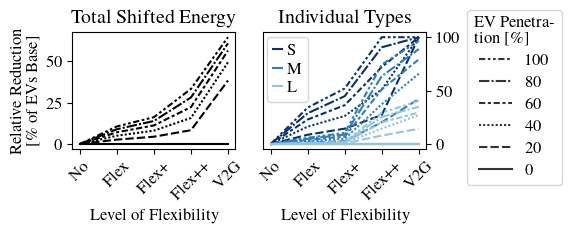

In [29]:
type_dict = {0: "Short", 1: "Medium", 2: "Long"}
x = "Level of Flexibility"
y = "Relative Reduction\n~~[\% of EVs Base]"
# set initial point

df_scatter_plt = diff_rel.copy()
df_scatter_plt[x] = 0
df_scatter_plt[y] = 0
# get values flexibility scenarios
diffs = [diff_rel, diff_rel_2, diff_rel_3, diff_rel_4]
sizes_tes = [1, 2, 3, 4]
for diff_df, size_tes in zip(diffs, sizes_tes):
    tmp=diff_df.copy()
    tmp[x] = size_tes
    tmp[y] = tmp["energy_stored"].abs()/1e3
    df_scatter_plt = pd.concat([df_scatter_plt, tmp], ignore_index=True)

    
param = "nr_ev"
hue = "Storage Type"
colors = matplotlib.cm.get_cmap("Blues")
fig, axes = plt.subplots(1, 2, figsize=(6,2.5))

# subplot 1
ax = axes[0]
df_plot = scatter_df_total.rename(columns={"energy_stored":y}).loc[[i*2*4.88 for i in range(6)]]#.loc[df_scatter_plt[param] == val] 
sns.lineplot(data=df_plot.abs(), x=x, y=y, style=param, ax=ax, color="k")
ax.legend().remove()
ax.set_xticks([0,1,2,3, 4], ["No", "Flex", "Flex+", "Flex++", "V2G"], rotation=45)
ax.set_title("Total Shifted Energy")

# subplot 2
ax = axes[1]
color_list = [colors(1.0-0.3*storage_type) for storage_type in [0,1,2]]
df_scatter_plt[hue] = df_scatter_plt.storage_type.apply(lambda x: type_dict[x])
df_plot = df_scatter_plt.loc[df_scatter_plt[param].isin([i*2*4.88 for i in range(6)])]#.loc[df_scatter_plt[param] == val] 
sns.lineplot(data=df_plot, x=x, y=y, hue=hue, style=param, palette=color_list, ax=ax)
handles, labels = ax.get_legend_handles_labels()
leg = plt.legend(handles[1:4], ["S", "M", "L"], loc="upper left",# title="Storage Type", 
                 columnspacing=0.5, labelspacing=0.2, handletextpad=0.3, handlelength=0.5,
                    bbox_to_anchor=(-0.03, 1.03))
ax.add_artist(leg)
plt.legend(handles=reversed(handles[5:]), labels=reversed([int((float(l)+0.1)/0.488) for l in labels[5:]]),loc=(1.25,-0.0), 
           title="EV Penetra-\ntion [\%]", labelspacing=0.4)
ax.set_xticks([0,1,2,3, 4], ["No", "Flex", "Flex+", "Flex++", "V2G"], rotation=45)
ax.set_ylabel("")
ax.yaxis.tick_right()
ax.set_title("Individual Types")
plt.tight_layout()
plt.legend(handles=reversed(handles[5:]), labels=reversed([int((float(l)+0.1)/0.488) for l in labels[5:]]),loc=(1.25,-0.3), 
           title="EV Penetra-\ntion [\%]", labelspacing=0.4)
plt.savefig("results/plots/paper_dc_reduction_potential_evs_both.pdf", bbox_inches='tight')

## Heat Pumps

In [88]:
def plot_storage_equivalent_germany_stacked_four_v1(
        storage_equivalent_ref, storage_equivalent_flex, growth, diff,
        parameter={"scenario": "Deutschland"},
        ylabel="Stored Energy [TWh]",
        ylabel1="Change in Stored Energy [TWh]",
        figsize=(8, 6),
        ylim=None,
        language="english",
        loc="lower center",
        save_dir=None,
        titles = ["Reference Operation", "Optimised Operation", "Growth Reference Operation", "Reduction Optimised Operation"]
):
    param = list(parameter.items())[0][0]
    xlabel = list(parameter.items())[0][1]
    
    
    axes_dict = {(0,0): {"title": titles[0], "values": storage_equivalent_ref, "ylim": 0},
                (0,1): {"title": titles[1], "values": storage_equivalent_flex, "ylim": 1},
                (1,0): {"title": titles[2], "values": growth, "ylim": 2},
                (1,1): {"title": titles[3], "values": diff, "ylim": 3}}
    
    if (language == "german") or (language == "deutsch"):
        type_dict = {0: "Tag", 1: "Woche", 2: "Saisonal"}
    else:
        type_dict = {0: "Short", 1: "Med.", 2: "Long"}
    fig, axes = plt.subplots(2,2,figsize=figsize)
    colors = matplotlib.cm.get_cmap("Blues")
    for ax in axes_dict.keys():
        storage_equivalent = axes_dict[ax]["values"]
        for storage_type in range(storage_equivalent.storage_type.max()+1):

            plot_df = pd.DataFrame(index=storage_equivalent[param].unique())
            for val in storage_equivalent[param].unique():
                tmp = storage_equivalent.loc[(storage_equivalent[param] == val)&
                                            (storage_equivalent.storage_type >= storage_type)&
                                            (np.sign(storage_equivalent.energy_stored) == np.sign(storage_equivalent.loc[
                                                (storage_equivalent[param] == val)&
                                                (storage_equivalent.storage_type == storage_type), "energy_stored"
                                            ].values[0]))]
                plot_df.loc[val, ylabel] = tmp.energy_stored.sum()/1e3
            plot_df[xlabel] = storage_equivalent[param].unique()

            sns.barplot(x=xlabel, y=ylabel, color=colors(1.0-0.3*storage_type),
                        data=plot_df, ax=axes[ax], label=type_dict[storage_type])
        axes[ax].set_title(axes_dict[ax]["title"])
        if ax == (0,0):
            axes[ax].legend(loc=loc, columnspacing=0.5, handletextpad=0.3, handlelength=1.0,
                            borderpad=0.2, ncols=3)#loc="lower left"
        if ylim is not None:
            axes[ax].set_ylim(ylim[axes_dict[ax]["ylim"]])
        if (ax==(0,1)) or (ax==(1,1)):
            axes[ax].set_ylabel("")
        elif ax==(1,0):
            axes[ax].set_ylabel(ylabel1)
        if (ax==(0,0)) or (ax==(0,1)):
            axes[ax].set_xlabel("")
            axes[ax].set_xticks([])
        else:
            if param in ["nr_ev"]:
                xticklabels = axes[ax].get_xticklabels()
                axes[ax].set_xticklabels([int(float(tick.get_text())) for tick in xticklabels])
    plt.tight_layout()
    if save_dir is not None:
        if "png" in save_dir:
            plt.savefig(save_dir, dpi=300)
        else:
            plt.savefig(save_dir)
    return axes

In [75]:
res_dir = r"C:\Users\aheider\Documents\Software\Flexibility-Quantification\results\final_run_paper_v1"
flexible_scenarios = ["HP_flexible", "HP_flexible_double_TES", "HP_flexible_four_TES"]
var = "nr_hp"
storage_equivalent_ref, growth, storage_equivalent_flex, diff=load_scenarios_and_diff("HP_reference", flexible_scenarios[0], var, res_dir=res_dir)
storage_equivalent_ref, growth, storage_equivalent_flex_2, diff_2=load_scenarios_and_diff("HP_reference", flexible_scenarios[1], var, res_dir=res_dir)
storage_equivalent_ref, growth, storage_equivalent_flex_3, diff_3=load_scenarios_and_diff("HP_reference", flexible_scenarios[2], var, res_dir=res_dir)

In [76]:
storage_equivalent_ref[["energy_stored", "nr_hp"]].groupby("nr_hp").sum().divide(1000)

energy_stored
nr_hp               
0.00      131.481029
1.94      135.113161
3.88      138.848951
5.82      142.704183
7.76      146.660235
9.70      150.720198
11.64     154.867712
13.58     159.097167
15.52     163.398322
17.46     167.765697
19.40     172.182311

In [77]:
storage_equivalent_flex_3[["energy_stored", "nr_hp"]].groupby("nr_hp").sum().divide(1000)

energy_stored
nr_hp               
0.00      131.481029
1.94      131.145431
3.88      131.274706
5.82      131.845446
7.76      132.679025
9.70      133.907335
11.64     135.694870
13.58     137.536939
15.52     139.606835
17.46     141.819664
19.40     144.203975

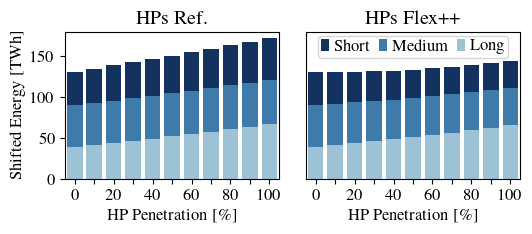

In [31]:
# plot reference and V2G
save_dir = "results/plots"
parameter = {"nr_hp": "Number HPs [Mio.]"}
ylabel = "Shifted Energy [TWh]"
language = "english"
fig, axes = plt.subplots(1, 2, figsize=(5.5,2.5))
save_dir_tmp = os.path.join(save_dir, "paper_dc_storage_equivalent_HPs_double.pdf")
ax = axes[0]
plot_storage_equivalent_germany_stacked(
            storage_equivalent_ref,
            parameter=parameter,
            ylabel=ylabel,
            loc=None,
            language=language,
            ax=ax,
            title="HPs Base"
        )
ax = axes[1]
plot_storage_equivalent_germany_stacked(
            storage_equivalent_flex_3,
            parameter=parameter,
            ylabel=ylabel,
            loc="upper right",
            language=language,
            ax=ax,
            title="HPs Flex++"
        )
axes[0].set_title("HPs Ref.")
for ax in axes:
    ax.set_xlabel("HP Penetration [\%]")
    ax.set_xticklabels([0, "", 20, "", 40, "", 60, "", 80, "", 100 ])
    ax.set_ylim(0,180)
ax = axes[1]
#a1 = ax.twinx()
#a1.set_ylim(ax.get_ylim())
#a1.set_ylabel("~~Shifted Energy \n[\% of Base Case]", rotation=270, labelpad=25)
#a1.yaxis.set_label_position("right")
#a1.yaxis.tick_right()
ax.set_ylabel("")
ax.set_yticks([])
energy_ref = storage_equivalent_ref.groupby("nr_hp").sum().loc[0, "energy_stored"]/1e3
#a1.set_yticks([0, energy_ref/2, energy_ref])
#a1.set_yticklabels([0, 50, 100])
plt.tight_layout()
ax.legend(ncols=3, loc="upper center", columnspacing=0.5, handletextpad=0.3, handlelength=0.5,
         bbox_to_anchor=(0.5, 1.03), borderpad=0.2)
#ax.legend(ncols=3, loc=(-0.55, -0.4), columnspacing=0.5)
#plt.legend(ncols=3, loc=(-0.2, 0.5))
#plt.savefig(save_dir_tmp, bbox_inches='tight')

In [78]:
energy_ref = storage_equivalent_ref.groupby("nr_hp").sum().loc[0, "energy_stored"]/1e3
growth_rel = get_relative_storage_equivalent(growth, "energy_stored", energy_ref)
diff_rel = get_relative_storage_equivalent(diff, "energy_stored", energy_ref)
diff_2_rel = get_relative_storage_equivalent(diff_2, "energy_stored", energy_ref)
diff_3_rel = get_relative_storage_equivalent(diff_3, "energy_stored", energy_ref)

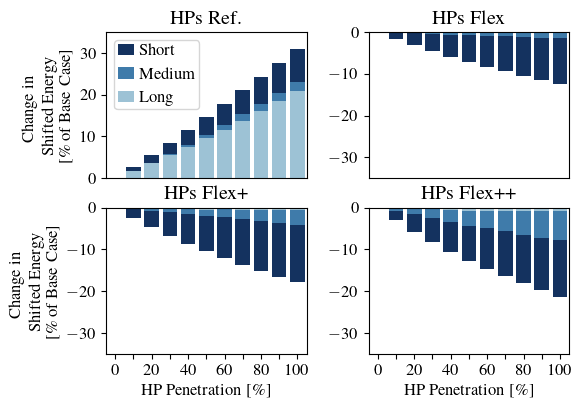

In [21]:
ylabel = "~~~~~Change in\n~~Shifted Energy\n[\% of Base Case]"
language = "english"
save_dir_tmp = os.path.join(save_dir, "paper_dc_storage_equivalent_HPs_flex.pdf")
axes = plot_storage_equivalent_germany_stacked_four(growth_rel, diff_rel, diff_2_rel, diff_3_rel,
                                                    parameter=parameter,
                                                    ylabel=ylabel,
                                                    ylabel1=ylabel,
                                                    ylim=[(0.0, 35), (-35, 0), (-35, 0), (-35, 0)],
                                                    titles=["HPs Ref.", "HPs Flex", "HPs Flex+", "HPs Flex++"],
                                                    figsize=(6, 4.25))
#axes[(0,0)].legend().remove()
#axes[(1,0)].legend(loc="lower left")
plt.subplots_adjust(hspace=0.2)
for ax in [axes[(1,0)], axes[(1,1)]]:
    ax.set_xlabel("HP Penetration [\%]")
    ax.set_xticklabels([0, "", 20, "", 40, "", 60, "", 80, "", 100 ])
plt.savefig(save_dir_tmp)

In [79]:
abs_diff_rel = {}
diffs_rel = {
    "flex": diff_rel,
    "flex+": diff_2_rel,
    "flex++": diff_3_rel,
}
for scenario in diffs_rel.keys():
    tmp = diffs_rel[scenario].copy()
    tmp["energy_stored"] += growth_rel["energy_stored"]
    abs_diff_rel[scenario] = tmp

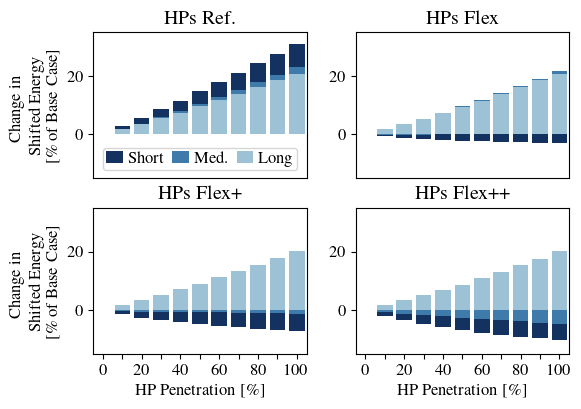

In [90]:
ylabel = "~~~~~Change in\n~~Shifted Energy\n[\% of Base Case]"
language = "english"

parameter = {"nr_hp": "Number HPs [Mio.]"}
save_dir_tmp = os.path.join(save_dir, "paper_dc_storage_equivalent_HPs_flex.pdf")
axes = plot_storage_equivalent_germany_stacked_four_v1(growth_rel, abs_diff_rel["flex"], abs_diff_rel["flex+"], abs_diff_rel["flex++"],
                                                    parameter=parameter,
                                                    ylabel=ylabel,
                                                    ylabel1=ylabel,
                                                    ylim=[(-15, 35), (-15, 35), (-15, 35), (-15, 35)],
                                                    titles=["HPs Ref.", "HPs Flex", "HPs Flex+", "HPs Flex++"],
                                                    figsize=(6, 4.25),)
#axes[(0,0)].legend().remove()
#axes[(1,0)].legend(loc="lower left")
plt.subplots_adjust(hspace=0.2)
for ax in [axes[(1,0)], axes[(1,1)]]:
    ax.set_xlabel("HP Penetration [\%]")
    ax.set_xticklabels([0, "", 20, "", 40, "", 60, "", 80, "", 100 ])

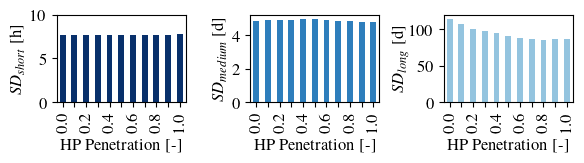

In [102]:
scenario = "HP_reference"
res_dir_base = r"U:\Software\Flexibility-Quantification\results\Diss2024"
naming_dict = {"0": "Short", "1": "Medium", "2": "Long"}
color_dict = {"Day": 0, "Week": 1, "Seasonal": 2}
colors = matplotlib.cm.get_cmap("Blues")
color_list = [colors(1.0-0.3*storage_type) for storage_type in [0,1,2]]
tf = pd.Series({
    "Short": pd.to_timedelta("24h"),
    "Medium": pd.to_timedelta("14d"),
    "Long": pd.to_timedelta("364d")
})
tf_num = pd.Series({
    "Short": pd.to_timedelta("24h")/pd.to_timedelta("1h"),
    "Medium": pd.to_timedelta("14d")/pd.to_timedelta("1h"),
    "Long": pd.to_timedelta("364d")/pd.to_timedelta("1h")
})
sd_df = pd.read_csv(os.path.join(res_dir_base, scenario, "storage_durations.csv"), index_col=0, parse_dates=True)
for col in sd_df.columns:
    sd_df[col] = pd.to_timedelta(sd_df[col])
sd_df.rename(columns=naming_dict, inplace=True)
sd_df

xlabel = "HP Penetration [-]"
ylabel1 = "$SD_{short}$ [h]"
ylabel2 = "$SD_{medium}$ [d]"
ylabel3 = "$SD_{long}$ [d]"
colors = matplotlib.cm.get_cmap("Blues")
color_list = [colors(1.0-0.3*storage_type) for storage_type in [0,1,2]]
figsize = (6, 1.8)
fig, ax =  plt.subplots(1, 3, figsize=figsize)
sd_df["Short"].groupby(level=0).mean().divide(pd.to_timedelta("1h")).plot.bar(
    ax=ax[0], color=color_list[0], xlabel=xlabel, ylabel=ylabel1)
ax[0].set_xticklabels([0.0, "", 0.2, "", 0.4, "", 0.6, "", 0.8, "", 1.0])
ax[0].set_yticks([0, 5, 10])
#ax[0].set_xticklabels(ax[0].get_xticklabels(), rotation=0)
sd_df["Medium"].groupby(level=0).mean().divide(pd.to_timedelta("1d")).plot.bar(
    ax=ax[1], color=color_list[1], xlabel=xlabel, ylabel=ylabel2)
ax[1].set_xticklabels([0.0, "", 0.2, "", 0.4, "", 0.6, "", 0.8, "", 1.0])
ax[1].set_yticks([0, 2, 4])
#ax[1].set_xticklabels(ax[1].get_xticklabels(), rotation=0)
sd_df["Long"].groupby(level=0).mean().divide(pd.to_timedelta("1d")).plot.bar(
    ax=ax[2], color=color_list[2], xlabel=xlabel, ylabel=ylabel3)
ax[2].set_xticklabels([0.0, "", 0.2, "", 0.4, "", 0.6, "", 0.8, "", 1.0])
ax[2].set_yticks([0,50,100])
#ax[2].set_xticklabels(ax[2].get_xticklabels(), rotation=0)
plt.tight_layout()
fig.subplots_adjust(wspace=0.5)
ax[2].yaxis.set_label_coords(-0.27, 0.5)
#plt.savefig("results/plots/paper_dc_storage_durations.pdf")

FileNotFoundError: [Errno 2] No such file or directory: 'U:\\Software\\Flexibility-Quantification\\results\\Diss2024\\HP_flexible_double_TES\\storage_durations.csv'

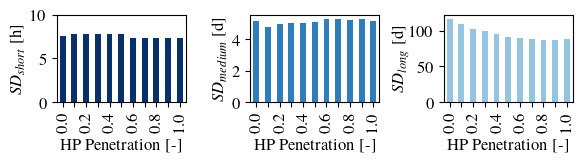

In [107]:
flexible_scenarios = ["HP_flexible", "HP_flexible_double_TES", "HP_flexible_four_TES"]
res_dir_base = r"U:\Software\Flexibility-Quantification\results\Diss2024"
naming_dict = {"0": "Short", "1": "Medium", "2": "Long"}
color_dict = {"Day": 0, "Week": 1, "Seasonal": 2}
colors = matplotlib.cm.get_cmap("Blues")
color_list = [colors(1.0-0.3*storage_type) for storage_type in [0,1,2]]
tf = pd.Series({
    "Short": pd.to_timedelta("24h"),
    "Medium": pd.to_timedelta("14d"),
    "Long": pd.to_timedelta("364d")
})
tf_num = pd.Series({
    "Short": pd.to_timedelta("24h")/pd.to_timedelta("1h"),
    "Medium": pd.to_timedelta("14d")/pd.to_timedelta("1h"),
    "Long": pd.to_timedelta("364d")/pd.to_timedelta("1h")
})
for scenario in flexible_scenarios:
    sd_df = pd.read_csv(os.path.join(res_dir_base, scenario, "storage_durations.csv"), index_col=0, parse_dates=True)
    for col in sd_df.columns:
        sd_df[col] = pd.to_timedelta(sd_df[col])
    sd_df.rename(columns=naming_dict, inplace=True)
    sd_df

    xlabel = "HP Penetration [-]"
    ylabel1 = "$SD_{short}$ [h]"
    ylabel2 = "$SD_{medium}$ [d]"
    ylabel3 = "$SD_{long}$ [d]"
    colors = matplotlib.cm.get_cmap("Blues")
    color_list = [colors(1.0-0.3*storage_type) for storage_type in [0,1,2]]
    figsize = (6, 1.8)
    fig, ax =  plt.subplots(1, 3, figsize=figsize)
    sd_df["Short"].groupby(level=0).mean().divide(pd.to_timedelta("1h")).plot.bar(
        ax=ax[0], color=color_list[0], xlabel=xlabel, ylabel=ylabel1)
    ax[0].set_xticklabels([0.0, "", 0.2, "", 0.4, "", 0.6, "", 0.8, "", 1.0])
    ax[0].set_yticks([0, 5, 10])
    #ax[0].set_xticklabels(ax[0].get_xticklabels(), rotation=0)
    sd_df["Medium"].groupby(level=0).mean().divide(pd.to_timedelta("1d")).plot.bar(
        ax=ax[1], color=color_list[1], xlabel=xlabel, ylabel=ylabel2)
    ax[1].set_xticklabels([0.0, "", 0.2, "", 0.4, "", 0.6, "", 0.8, "", 1.0])
    ax[1].set_yticks([0, 2, 4])
    #ax[1].set_xticklabels(ax[1].get_xticklabels(), rotation=0)
    sd_df["Long"].groupby(level=0).mean().divide(pd.to_timedelta("1d")).plot.bar(
        ax=ax[2], color=color_list[2], xlabel=xlabel, ylabel=ylabel3)
    ax[2].set_xticklabels([0.0, "", 0.2, "", 0.4, "", 0.6, "", 0.8, "", 1.0])
    ax[2].set_yticks([0,50,100])
    #ax[2].set_xticklabels(ax[2].get_xticklabels(), rotation=0)
    plt.tight_layout()
    fig.subplots_adjust(wspace=0.5)
    ax[2].yaxis.set_label_coords(-0.27, 0.5)
    #plt.savefig("results/plots/paper_dc_storage_durations.pdf")

In [33]:
scatter_df_total = pd.DataFrame()
x = "Level of Flexibility"
var = "energy_stored"
# initialise scatter df total
tmp = growth.groupby("nr_hp").sum()
tmp[var] = 0
tmp[x] = 0
scatter_df_total = pd.concat([scatter_df_total, tmp])
# iterate through flexibility scenarios
flexibility_levels = [1,2,4]
diff_dfs = [diff, diff_2, diff_3]
ref = storage_equivalent_ref.groupby("nr_hp").sum()
for fl, diff_df in zip(flexibility_levels, diff_dfs):
    tmp = diff_df.groupby("nr_hp").sum()
    tmp[var] = tmp[var].divide(ref[var])*100
    tmp[x] = fl
    scatter_df_total = pd.concat([scatter_df_total, tmp])

In [34]:
var="nr_hp"
scenarios = ["HP_flexible_reduction", "HP_flexible_double_TES_reduction", "HP_flexible_four_TES_reduction"]
tmp = load_diff_single_storage_types("HP_reference", scenarios, var, res_dir)
diff_rel = tmp[2][scenarios[0]]
diff_rel["energy_stored"] = diff_rel["energy_stored"].divide(storage_equivalent_ref.reset_index()["energy_stored"])*1e5
diff_rel_2 = tmp[2][scenarios[1]]
diff_rel_2["energy_stored"] = diff_rel_2["energy_stored"].divide(storage_equivalent_ref.reset_index()["energy_stored"])*1e5
diff_rel_3 = tmp[2][scenarios[2]]
diff_rel_3["energy_stored"] = diff_rel_3["energy_stored"].divide(storage_equivalent_ref.reset_index()["energy_stored"])*1e5

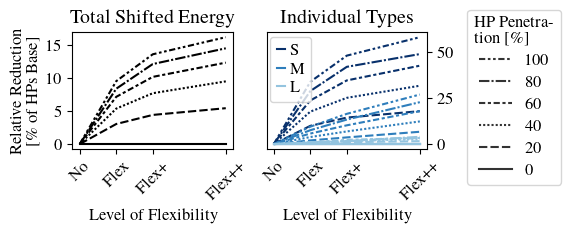

In [37]:
type_dict = {0: "Short", 1: "Medium", 2: "Long"}
x = "Level of Flexibility"
y = "Relative Reduction\n~~[\% of HPs Base]"
# set initial point

df_scatter_plt = diff_rel.copy()
df_scatter_plt[x] = 0
df_scatter_plt[y] = 0
# get values flexibility scenarios
diffs = [diff_rel, diff_rel_2, diff_rel_3]
sizes_tes = [1, 2, 4]
for diff_df, size_tes in zip(diffs, sizes_tes):
    tmp=diff_df.copy()
    tmp[x] = size_tes
    tmp[y] = tmp["energy_stored"].abs()/1e3
    df_scatter_plt = pd.concat([df_scatter_plt, tmp], ignore_index=True)

    
param = "nr_hp"
hue = "Storage Type"
colors = matplotlib.cm.get_cmap("Blues")
fig, axes = plt.subplots(1, 2, figsize=(6,2.5))

# subplot 1
ax = axes[0]
df_plot = scatter_df_total.rename(columns={"energy_stored":y}).loc[[i*2*1.94 for i in range(6)]]#.loc[df_scatter_plt[param] == val] 
sns.lineplot(data=df_plot.abs(), x=x, y=y, style=param, ax=ax, color="k")
ax.legend().remove()
ax.set_yticks([0,5,10,15])
ax.set_xticks([0,1,2, 4], ["No", "Flex", "Flex+", "Flex++"], rotation=45)
ax.set_title("Total Shifted Energy")

# subplot 2
ax = axes[1]
color_list = [colors(1.0-0.3*storage_type) for storage_type in [0,1,2]]
df_scatter_plt[hue] = df_scatter_plt.storage_type.apply(lambda x: type_dict[x])
df_plot = df_scatter_plt.loc[df_scatter_plt.nr_hp.isin([i*2*1.94 for i in range(6)])]#.loc[df_scatter_plt[param] == val] 
sns.lineplot(data=df_plot, x=x, y=y, hue=hue, style=param, palette=color_list, ax=ax)
handles, labels = ax.get_legend_handles_labels()
leg = plt.legend(handles[1:4], ["S", "M", "L"], loc="upper left",# title="Storage Type", 
                 columnspacing=0.5, labelspacing=0.2, handletextpad=0.3, handlelength=0.5,
                    bbox_to_anchor=(-0.03, 1.03))
ax.add_artist(leg)
plt.legend(handles=reversed(handles[5:]), labels=reversed([int((float(l)+0.1)/0.194) for l in labels[5:]]),loc=(1.25,-0.0), 
           title="HP Penetra-\ntion [\%]", labelspacing=0.4)
ax.set_xticks([0,1,2, 4], ["No", "Flex", "Flex+", "Flex++"], rotation=45)
ax.set_ylabel("")
ax.yaxis.tick_right()
ax.set_title("Individual Types")
plt.tight_layout()
plt.legend(handles=reversed(handles[5:]), labels=reversed([int((float(l)+0.1)/0.194) for l in labels[5:]]),loc=(1.25,-0.3), 
           title="HP Penetra-\ntion [\%]", labelspacing=0.4)
plt.savefig("results/plots/paper_dc_reduction_potential_hps_both.pdf", bbox_inches='tight')

## Sensitivity

In [176]:
scenario = "Sensitivity_Weights"
res_dir_base = r"H:\Flexibility-Quantification\final_run_paper_v1"
storage_equivalent = pd.read_csv(
        f"{res_dir_base}/{scenario}/storage_equivalents.csv",
        index_col=0)
scenario = "Sensitivity_Weights_HP_max_flex"
storage_equivalent_hp_max_flex = pd.read_csv(
        f"{res_dir_base}/{scenario}/storage_equivalents.csv",
        index_col=0)
scenario = "Sensitivity_Weights_EV_max_flex"
storage_equivalent_ev_max_flex = pd.read_csv(
        f"{res_dir_base}/{scenario}/storage_equivalents.csv",
        index_col=0)

In [178]:
def plot_storage_equivalent_germany_stacked_three(
        storage_equivalent_1, storage_equivalent_2, storage_equivalent_3, 
        parameter={"scenario": "Deutschland"},
        ylabel="Stored Energy [TWh]",
        figsize=(8, 2.5),
        ylim=None,
        language="english",
        loc="upper left",
        save_dir=None,
        titles = ["Base Case", "With 40 Mio. EVs", "With 20 Mio. HPs"]
):
    param = list(parameter.items())[0][0]
    xlabel = list(parameter.items())[0][1]
    
    
    axes_dict = {0: {"title": titles[0], "values": storage_equivalent_1},
                1: {"title": titles[1], "values": storage_equivalent_2},
                2: {"title": titles[2], "values": storage_equivalent_3},}
    
    if (language == "german") or (language == "deutsch"):
        type_dict = {0: "Kurz", 1: "Mittel", 2: "Land"}
    else:
        type_dict = {0: "Short", 1: "Medium", 2: "Long"}
    fig, axes = plt.subplots(1,3,figsize=figsize)
    colors = matplotlib.cm.get_cmap("Blues")
    for ax in axes_dict.keys():
        storage_equivalent = axes_dict[ax]["values"]
        for storage_type in range(storage_equivalent.storage_type.max()+1):

            plot_df = pd.DataFrame(index=storage_equivalent[param].unique())
            for val in storage_equivalent[param].unique():
                tmp = storage_equivalent.loc[(storage_equivalent[param] == val)&
                                            (storage_equivalent.storage_type >= storage_type)&
                                            (np.sign(storage_equivalent.energy_stored) == np.sign(storage_equivalent.loc[
                                                (storage_equivalent[param] == val)&
                                                (storage_equivalent.storage_type == storage_type), "energy_stored"
                                            ].values[0]))]
                plot_df.loc[val, ylabel] = tmp.energy_stored.sum()/1e3
            plot_df[xlabel] = storage_equivalent[param].unique()

            sns.barplot(x=xlabel, y=ylabel, color=colors(1.0-0.3*storage_type),
                        data=plot_df, ax=axes[ax], label=type_dict[storage_type])
        axes[ax].set_title(axes_dict[ax]["title"])
        if (ax == 0) & (loc is not None):
            axes[ax].legend(loc=loc, ncols=3)#loc="lower left"
        if ylim is not None:
            axes[ax].set_ylim(ylim)
        if (ax==1) or (ax==2):
            axes[ax].set_ylabel("")
        elif ax==0:
            axes[ax].set_ylabel(ylabel)
        else:
            if param in ["nr_ev"]:
                xticklabels = axes[ax].get_xticklabels()
                axes[ax].set_xticklabels([int(float(tick.get_text())) for tick in xticklabels])
    plt.tight_layout()
    if save_dir is not None:
        if "png" in save_dir:
            plt.savefig(save_dir, dpi=300)
        else:
            plt.savefig(save_dir)
    return axes

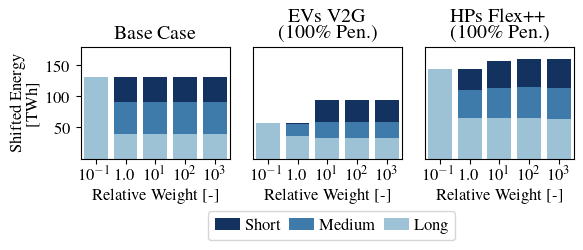

In [213]:

import itertools
def flip(items, ncol):
    return itertools.chain(*[items[i::ncol] for i in range(ncol)])
save_dir = "results/plots"
parameter = {"relative_weight": "Relative Weight [-]"}
ylabel = "Shifted Energy\n~~~~~~[TWh]"
language = "english"
rename_dict={0.1: "$10^{-1}$", 10: "$10^{1}$", 100: "$10^{2}$", 1000: "$10^{3}$"}
save_dir_tmp = os.path.join(save_dir, "paper_dc_sensitivity_weights.pdf")
axes=plot_storage_equivalent_germany_stacked_three(
    storage_equivalent.replace(rename_dict), storage_equivalent_ev_max_flex.replace(rename_dict), 
    storage_equivalent_hp_max_flex.replace(rename_dict),
    parameter=parameter,
    ylabel=ylabel,
    loc=None,
    language=language,
    ylim=(0, 180),
    titles = ["Base Case", "~~EVs V2G \n(100\% Pen.)", "HPs Flex++ \n(100\% Pen.)"],
    figsize=(6, 2.3)
)
axes[0].set_yticks([50, 100, 150])
axes[1].set_yticks([])
axes[2].set_yticks([])
plt.tight_layout()
handles, labels = axes[1].get_legend_handles_labels()
axes[1].legend(handles, labels,  ncols=3, loc=(-0.3,-0.73), 
               columnspacing=0.5, handletextpad=0.3, handlelength=1.5)
plt.savefig(save_dir_tmp, bbox_inches='tight')

In [4]:
res_dir = r"C:\Users\aheider\Documents\Software\Flexibility-Quantification\results\two_weeks"
scenario = "Variation_Generation_years"
storage_equivalent_gen = pd.read_csv(
        f"{res_dir}/{scenario}/storage_equivalents.csv",
        index_col=0)
storage_equivalent_gen.loc[storage_equivalent_gen.data_source=="ego", "year"] = "ref."
scenario = "Variation_Load_years"
storage_equivalent_demand = pd.read_csv(
        f"{res_dir}/{scenario}/storage_equivalents.csv",
        index_col=0)
storage_equivalent_demand.loc[storage_equivalent_demand.data_source=="ego", "year"] = "ref."

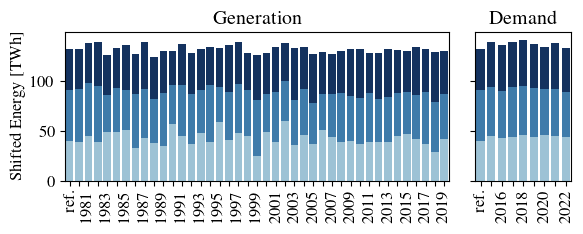

In [212]:
save_dir = "results/plots"
f, (a0, a1) = plt.subplots(1, 2, figsize=(6, 2.5), gridspec_kw={'width_ratios': [4, 1]})
parameter = {"year": "Year"}
ylabel = "Shifted Energy [TWh]"
language = "english"
plot_storage_equivalent_germany_stacked(
            storage_equivalent_gen,
            parameter=parameter,
            ylabel=ylabel,
            loc=None,
            language=language,
            ax=a0,
            ylim=(0,149)
        )
parameter = {"year": "Year"}
ylabel = "Stored Energy [TWh]"
language = "english"
plot_storage_equivalent_germany_stacked(
            storage_equivalent_demand,
            parameter=parameter,
            ylabel=ylabel,
            loc=None,
            language=language,
            ax=a1,
            ylim=(0,149)
        )
a0.set_xlabel("")
a1.set_xlabel("")
a0.set_title("Generation")
a1.set_title("Demand")
a1.set_ylabel("")
a1.set_yticklabels([])
a0.set_xticklabels(a0.get_xticklabels(), rotation=90)
n = 2  
[l.set_visible(False) for (i,l) in enumerate(a0.xaxis.get_ticklabels()) if i % n != 0]
a1.set_xticklabels(a1.get_xticklabels(), rotation=90)
[l.set_visible(False) for (i,l) in enumerate(a1.xaxis.get_ticklabels()) if i % n != 0]
plt.tight_layout()
save_dir_tmp = os.path.join(save_dir, "paper_dc_storage_equivalent_variation_years.pdf")
plt.savefig(save_dir_tmp)

In [47]:
res_dir = r"C:\Users\aheider\Documents\Software\Flexibility-Quantification\results\two_weeks"
scenario = "Variation_Generation_years"
storage_equivalent_gen = pd.read_csv(
        f"{res_dir}/{scenario}/storage_equivalents.csv",
        index_col=0)
storage_equivalent_gen.loc[storage_equivalent_gen.data_source=="ego", "year"] = "ref."
res_dir = r"C:\Users\aheider\Documents\Software\Flexibility-Quantification\results\Diss2024"
scenario = "Variation_Load_years"
storage_equivalent_demand = pd.read_csv(
        f"{res_dir}/{scenario}/storage_equivalents.csv",
        index_col=0)
storage_equivalent_demand.loc[storage_equivalent_demand.data_source=="ego", "year"] = "ref."

C:\Users\aheider\AppData\Local\Temp\ipykernel_21184\717231517.py:40: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  mean_df=storage_equivalent_demand.loc[storage_equivalent_demand.data_source=="entso"].groupby("storage_type").mean()/1e3
C:\Users\aheider\AppData\Local\Temp\ipykernel_21184\717231517.py:46: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  mean_df=storage_equivalent_gen.loc[storage_equivalent_gen.data_source=="rn"].groupby("storage_type").mean()/1e3


(-0.5, 10.5)

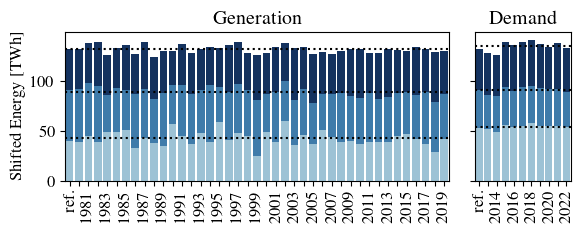

In [49]:
save_dir = "results/plots"
f, (a0, a1) = plt.subplots(1, 2, figsize=(6, 2.5), gridspec_kw={'width_ratios': [4, 1]})
parameter = {"year": "Year"}
ylabel = "Shifted Energy [TWh]"
language = "english"
plot_storage_equivalent_germany_stacked(
            storage_equivalent_gen,
            parameter=parameter,
            ylabel=ylabel,
            loc=None,
            language=language,
            ax=a0,
            ylim=(0,149)
        )
parameter = {"year": "Year"}
ylabel = "Stored Energy [TWh]"
language = "english"
plot_storage_equivalent_germany_stacked(
            storage_equivalent_demand,
            parameter=parameter,
            ylabel=ylabel,
            loc=None,
            language=language,
            ax=a1,
            ylim=(0,149)
        )
a0.set_xlabel("")
a1.set_xlabel("")
a0.set_title("Generation")
a1.set_title("Demand")
a1.set_ylabel("")
a0.set_xticklabels(a0.get_xticklabels(), rotation=90)
n = 2  
[l.set_visible(False) for (i,l) in enumerate(a0.xaxis.get_ticklabels()) if i % n != 0]
a1.set_xticklabels(a1.get_xticklabels(), rotation=90)
[l.set_visible(False) for (i,l) in enumerate(a1.xaxis.get_ticklabels()) if i % n != 0]
plt.tight_layout()
# plot mean
a1.set_yticklabels([])
mean_df=storage_equivalent_demand.loc[storage_equivalent_demand.data_source=="entso"].groupby("storage_type").mean()/1e3
xlim=a1.get_xlim()
a1.hlines(y=mean_df.loc[2, "energy_stored"], color="k", linestyle='dotted', xmin=xlim[0], xmax=xlim[1])
a1.hlines(y=mean_df.loc[1:2, "energy_stored"].sum(), color="k", linestyle='dotted', xmin=xlim[0], xmax=xlim[1])
a1.hlines(y=mean_df.loc[:, "energy_stored"].sum(), color="k", linestyle='dotted', xmin=xlim[0], xmax=xlim[1])
a1.set_xlim(xlim)
mean_df=storage_equivalent_gen.loc[storage_equivalent_gen.data_source=="rn"].groupby("storage_type").mean()/1e3
xlim=a0.get_xlim()
a0.hlines(y=mean_df.loc[2, "energy_stored"], color="k", linestyle='dotted', xmin=xlim[0], xmax=xlim[1])
a0.hlines(y=mean_df.loc[1:2, "energy_stored"].sum(), color="k", linestyle='dotted', xmin=xlim[0], xmax=xlim[1])
a0.hlines(y=mean_df.loc[:, "energy_stored"].sum(), color="k", linestyle='dotted', xmin=xlim[0], xmax=xlim[1])
a0.set_xlim(xlim)
save_dir_tmp = os.path.join(save_dir, "paper_dc_storage_equivalent_variation_years.pdf")
plt.tight_layout()
#plt.savefig(save_dir_tmp)
a1.get_xlim()

In [22]:
res_dir = r"C:\Users\aheider\Documents\Software\Flexibility-Quantification\results\two_weeks"
scenario = "Variation_Generation_years"
storage_equivalent_gen = pd.read_csv(
        f"{res_dir}/{scenario}/storage_equivalents.csv",
        index_col=0)
storage_equivalent_gen.loc[storage_equivalent_gen.data_source=="ego", "year"] = "ref."
scenario = "Variation_Load_years"
storage_equivalent_demand = pd.read_csv(
        f"{res_dir}/{scenario}/storage_equivalents.csv",
        index_col=0)
storage_equivalent_demand.loc[storage_equivalent_demand.data_source=="ego", "year"] = "ref."

C:\Users\aheider\AppData\Local\Temp\ipykernel_29476\717231517.py:40: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  mean_df=storage_equivalent_demand.loc[storage_equivalent_demand.data_source=="entso"].groupby("storage_type").mean()/1e3
C:\Users\aheider\AppData\Local\Temp\ipykernel_29476\717231517.py:46: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  mean_df=storage_equivalent_gen.loc[storage_equivalent_gen.data_source=="rn"].groupby("storage_type").mean()/1e3


(-0.5, 8.5)

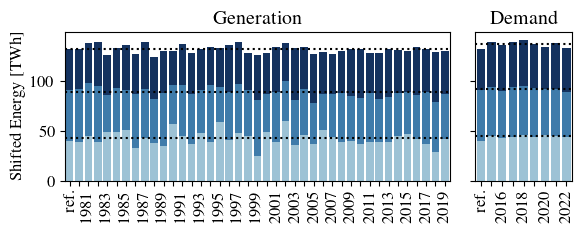

In [28]:
save_dir = "results/plots"
f, (a0, a1) = plt.subplots(1, 2, figsize=(6, 2.5), gridspec_kw={'width_ratios': [4, 1]})
parameter = {"year": "Year"}
ylabel = "Shifted Energy [TWh]"
language = "english"
plot_storage_equivalent_germany_stacked(
            storage_equivalent_gen,
            parameter=parameter,
            ylabel=ylabel,
            loc=None,
            language=language,
            ax=a0,
            ylim=(0,149)
        )
parameter = {"year": "Year"}
ylabel = "Stored Energy [TWh]"
language = "english"
plot_storage_equivalent_germany_stacked(
            storage_equivalent_demand,
            parameter=parameter,
            ylabel=ylabel,
            loc=None,
            language=language,
            ax=a1,
            ylim=(0,149)
        )
a0.set_xlabel("")
a1.set_xlabel("")
a0.set_title("Generation")
a1.set_title("Demand")
a1.set_ylabel("")
a0.set_xticklabels(a0.get_xticklabels(), rotation=90)
n = 2  
[l.set_visible(False) for (i,l) in enumerate(a0.xaxis.get_ticklabels()) if i % n != 0]
a1.set_xticklabels(a1.get_xticklabels(), rotation=90)
[l.set_visible(False) for (i,l) in enumerate(a1.xaxis.get_ticklabels()) if i % n != 0]
plt.tight_layout()
# plot mean
a1.set_yticklabels([])
mean_df=storage_equivalent_demand.loc[storage_equivalent_demand.data_source=="entso"].groupby("storage_type").mean()/1e3
xlim=a1.get_xlim()
a1.hlines(y=mean_df.loc[2, "energy_stored"], color="k", linestyle='dotted', xmin=xlim[0], xmax=xlim[1])
a1.hlines(y=mean_df.loc[1:2, "energy_stored"].sum(), color="k", linestyle='dotted', xmin=xlim[0], xmax=xlim[1])
a1.hlines(y=mean_df.loc[:, "energy_stored"].sum(), color="k", linestyle='dotted', xmin=xlim[0], xmax=xlim[1])
a1.set_xlim(xlim)
mean_df=storage_equivalent_gen.loc[storage_equivalent_gen.data_source=="rn"].groupby("storage_type").mean()/1e3
xlim=a0.get_xlim()
a0.hlines(y=mean_df.loc[2, "energy_stored"], color="k", linestyle='dotted', xmin=xlim[0], xmax=xlim[1])
a0.hlines(y=mean_df.loc[1:2, "energy_stored"].sum(), color="k", linestyle='dotted', xmin=xlim[0], xmax=xlim[1])
a0.hlines(y=mean_df.loc[:, "energy_stored"].sum(), color="k", linestyle='dotted', xmin=xlim[0], xmax=xlim[1])
a0.set_xlim(xlim)
save_dir_tmp = os.path.join(save_dir, "paper_dc_storage_equivalent_variation_years.pdf")
plt.tight_layout()
#plt.savefig(save_dir_tmp)
a1.get_xlim()

C:\Users\aheider\AppData\Local\Temp\ipykernel_20536\4021133325.py:52: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  mean_df=storage_equivalent_demand.loc[storage_equivalent_demand.data_source=="entso"].groupby("storage_type").mean()/1e3
C:\Users\aheider\AppData\Local\Temp\ipykernel_20536\4021133325.py:58: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  mean_df=storage_equivalent_gen.loc[storage_equivalent_gen.data_source=="rn"].groupby("storage_type").mean()/1e3


(-0.5, 8.5)

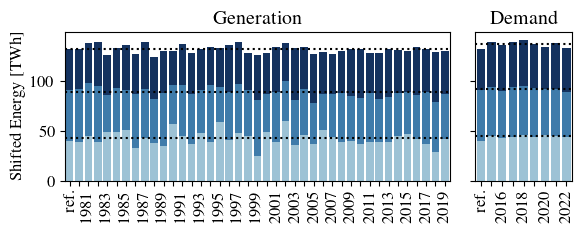

In [18]:
res_dir = r"C:\Users\aheider\Documents\Software\Flexibility-Quantification\results\two_weeks"
scenario = "Variation_Generation_years"
storage_equivalent_gen = pd.read_csv(
        f"{res_dir}/{scenario}/storage_equivalents.csv",
        index_col=0)
storage_equivalent_gen.loc[storage_equivalent_gen.data_source=="ego", "year"] = "ref."
res_dir = r"U:\Software\Flexibility-Quantification\results\Diss2024"
scenario = "Variation_Load_years"
storage_equivalent_demand = pd.read_csv(
        f"{res_dir}/{scenario}/storage_equivalents.csv",
        index_col=0)
storage_equivalent_demand.loc[storage_equivalent_demand.data_source=="ego", "year"] = "ref."
save_dir = "results/plots"
f, (a0, a1) = plt.subplots(1, 2, figsize=(6, 2.5), gridspec_kw={'width_ratios': [4, 1]})
parameter = {"year": "Year"}
ylabel = "Shifted Energy [TWh]"
language = "english"
plot_storage_equivalent_germany_stacked(
            storage_equivalent_gen,
            parameter=parameter,
            ylabel=ylabel,
            loc=None,
            language=language,
            ax=a0,
            ylim=(0,149)
        )
parameter = {"year": "Year"}
ylabel = "Stored Energy [TWh]"
language = "english"
plot_storage_equivalent_germany_stacked(
            storage_equivalent_demand,
            parameter=parameter,
            ylabel=ylabel,
            loc=None,
            language=language,
            ax=a1,
            ylim=(0,149)
        )
a0.set_xlabel("")
a1.set_xlabel("")
a0.set_title("Generation")
a1.set_title("Demand")
a1.set_ylabel("")
a0.set_xticklabels(a0.get_xticklabels(), rotation=90)
n = 2  
[l.set_visible(False) for (i,l) in enumerate(a0.xaxis.get_ticklabels()) if i % n != 0]
a1.set_xticklabels(a1.get_xticklabels(), rotation=90)
[l.set_visible(False) for (i,l) in enumerate(a1.xaxis.get_ticklabels()) if i % n != 0]
plt.tight_layout()
# plot mean
a1.set_yticklabels([])
mean_df=storage_equivalent_demand.loc[storage_equivalent_demand.data_source=="entso"].groupby("storage_type").mean()/1e3
xlim=a1.get_xlim()
a1.hlines(y=mean_df.loc[2, "energy_stored"], color="k", linestyle='dotted', xmin=xlim[0], xmax=xlim[1])
a1.hlines(y=mean_df.loc[1:2, "energy_stored"].sum(), color="k", linestyle='dotted', xmin=xlim[0], xmax=xlim[1])
a1.hlines(y=mean_df.loc[:, "energy_stored"].sum(), color="k", linestyle='dotted', xmin=xlim[0], xmax=xlim[1])
a1.set_xlim(xlim)
mean_df=storage_equivalent_gen.loc[storage_equivalent_gen.data_source=="rn"].groupby("storage_type").mean()/1e3
xlim=a0.get_xlim()
a0.hlines(y=mean_df.loc[2, "energy_stored"], color="k", linestyle='dotted', xmin=xlim[0], xmax=xlim[1])
a0.hlines(y=mean_df.loc[1:2, "energy_stored"].sum(), color="k", linestyle='dotted', xmin=xlim[0], xmax=xlim[1])
a0.hlines(y=mean_df.loc[:, "energy_stored"].sum(), color="k", linestyle='dotted', xmin=xlim[0], xmax=xlim[1])
a0.set_xlim(xlim)
save_dir_tmp = os.path.join(save_dir, "paper_dc_storage_equivalent_variation_years.pdf")
plt.tight_layout()
#plt.savefig(save_dir_tmp)
a1.get_xlim()

In [47]:
mean_df=storage_equivalent_demand.loc[storage_equivalent_demand.data_source=="entso"].groupby("storage_type").mean()/1e3
mean_df

energy_stored
storage_type               
0                 44.838218
1                 47.466928
2                 44.757837

In [50]:
mean_df=storage_equivalent_demand.loc[storage_equivalent_demand.data_source=="entso"].groupby("storage_type").mean()/1e3
rmse = pd.Series(index=storage_equivalent_demand.year.unique())
for year in storage_equivalent_demand.year.unique():
    tmp = storage_equivalent_demand.loc[storage_equivalent_demand.year == year][["storage_type", "energy_stored"]].set_index(
        "storage_type")
    tmp["energy_stored"] /= 1000
    rmse[year] = (tmp-mean_df).divide(mean_df).apply(np.square).mean().apply(np.sqrt)["energy_stored"]
rmse

C:\Users\aheider\AppData\Local\Temp\ipykernel_29476\2739139806.py:1: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  rmse = pd.Series(index=storage_equivalent_demand.year.unique())


ref.    0.097561
2015    0.020661
2016    0.023329
2017    0.033973
2018    0.030822
2019    0.019693
2020    0.037615
2021    0.021612
2022    0.034563
dtype: float64

In [51]:
rmse.idxmin()

2019

In [52]:
mean_df=storage_equivalent_demand.loc[storage_equivalent_demand.data_source=="entso"].groupby("storage_type").mean()/1e3
rmse = pd.Series(index=storage_equivalent_demand.year.unique())
for year in storage_equivalent_demand.year.unique():
    tmp = storage_equivalent_demand.loc[storage_equivalent_demand.year == year][["storage_type", "energy_stored"]].set_index(
        "storage_type")
    tmp["energy_stored"] /= 1000
    rmse[year] = (tmp-mean_df).divide(mean_df).apply(np.square).apply(np.sqrt).mean()["energy_stored"]
rmse

C:\Users\aheider\AppData\Local\Temp\ipykernel_29476\750220241.py:1: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  rmse = pd.Series(index=storage_equivalent_demand.year.unique())


ref.    0.096675
2015    0.018747
2016    0.021634
2017    0.027262
2018    0.028180
2019    0.018060
2020    0.035803
2021    0.020435
2022    0.029206
dtype: float64

In [53]:
rmse.idxmin()

2019

In [54]:
mean_df=storage_equivalent_gen.loc[storage_equivalent_gen.data_source=="rn"].groupby("storage_type").mean()/1e3
rmse = pd.Series(index=storage_equivalent_gen.year.unique())
for year in storage_equivalent_gen.year.unique():
    tmp = storage_equivalent_gen.loc[storage_equivalent_gen.year == year][["storage_type", "energy_stored"]].set_index(
        "storage_type")
    tmp["energy_stored"] /= 1000
    rmse[year] = (tmp-mean_df).divide(mean_df).apply(np.square).mean().apply(np.sqrt)["energy_stored"]
rmse

C:\Users\aheider\AppData\Local\Temp\ipykernel_29476\2641307022.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  mean_df=storage_equivalent_gen.loc[storage_equivalent_gen.data_source=="rn"].groupby("storage_type").mean()/1e3
C:\Users\aheider\AppData\Local\Temp\ipykernel_29476\2641307022.py:2: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  rmse = pd.Series(index=storage_equivalent_gen.year.unique())


ref.    0.080680
1980    0.100851
1981    0.102466
1982    0.137405
1983    0.157989
1984    0.098281
1985    0.145686
1986    0.155466
1987    0.066634
1988    0.070003
1989    0.133917
1990    0.241575
1991    0.065817
1992    0.096814
1993    0.082411
1994    0.170502
1995    0.269299
1996    0.070249
1997    0.083774
1998    0.085547
1999    0.271763
2000    0.143015
2001    0.076466
2002    0.253819
2003    0.145667
2004    0.054806
2005    0.128866
2006    0.167337
2007    0.062276
2008    0.057542
2009    0.074286
2010    0.112531
2011    0.063892
2012    0.079285
2013    0.082672
2014    0.050075
2015    0.079389
2016    0.077830
2017    0.110517
2018    0.203855
2019    0.017358
dtype: float64

In [55]:
rmse.idxmin()

2019

In [56]:
mean_df=storage_equivalent_gen.loc[storage_equivalent_gen.data_source=="rn"].groupby("storage_type").mean()/1e3
rmse = pd.Series(index=storage_equivalent_gen.year.unique())
for year in storage_equivalent_gen.year.unique():
    tmp = storage_equivalent_gen.loc[storage_equivalent_gen.year == year][["storage_type", "energy_stored"]].set_index(
        "storage_type")
    tmp["energy_stored"] /= 1000
    rmse[year] = (tmp-mean_df).divide(mean_df).apply(np.square).apply(np.sqrt).mean()["energy_stored"]
rmse

C:\Users\aheider\AppData\Local\Temp\ipykernel_29476\2754401337.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  mean_df=storage_equivalent_gen.loc[storage_equivalent_gen.data_source=="rn"].groupby("storage_type").mean()/1e3
C:\Users\aheider\AppData\Local\Temp\ipykernel_29476\2754401337.py:2: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  rmse = pd.Series(index=storage_equivalent_gen.year.unique())


ref.    0.076941
1980    0.095437
1981    0.093961
1982    0.115195
1983    0.146298
1984    0.086180
1985    0.132261
1986    0.139392
1987    0.053641
1988    0.058582
1989    0.116288
1990    0.228979
1991    0.059063
1992    0.084465
1993    0.077191
1994    0.156749
1995    0.241056
1996    0.065061
1997    0.065372
1998    0.069336
1999    0.224454
2000    0.130441
2001    0.074398
2002    0.215615
2003    0.125828
2004    0.041592
2005    0.128667
2006    0.139248
2007    0.059408
2008    0.054053
2009    0.067305
2010    0.096129
2011    0.062691
2012    0.079227
2013    0.071604
2014    0.042535
2015    0.072388
2016    0.061310
2017    0.091268
2018    0.179908
2019    0.014335
dtype: float64

In [57]:
rmse.idxmin()

2019

C:\Users\aheider\AppData\Local\Temp\ipykernel_20536\219460463.py:52: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  mean_df=storage_equivalent_demand.loc[storage_equivalent_demand.data_source=="entso"].groupby("storage_type").mean()/1e3
C:\Users\aheider\AppData\Local\Temp\ipykernel_20536\219460463.py:58: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  mean_df=storage_equivalent_gen.loc[storage_equivalent_gen.data_source=="rn"].groupby("storage_type").mean()/1e3


(-0.5, 8.5)

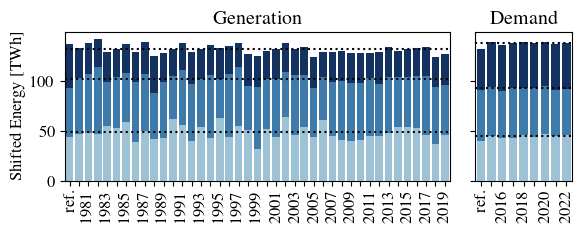

In [44]:
res_dir = r"U:\Software\Flexibility-Quantification\results\Diss2024"
scenario = "Variation_Generation_years"
storage_equivalent_gen = pd.read_csv(
        f"{res_dir}/{scenario}/storage_equivalents.csv",
        index_col=0)
storage_equivalent_gen.loc[storage_equivalent_gen.data_source=="ego", "year"] = "ref."
res_dir = r"U:\Software\Flexibility-Quantification\results\Diss2024"
scenario = "Variation_Load_years"
storage_equivalent_demand = pd.read_csv(
        f"{res_dir}/{scenario}/storage_equivalents.csv",
        index_col=0)
storage_equivalent_demand.loc[storage_equivalent_demand.data_source=="ego", "year"] = "ref."
save_dir = "results/plots"
f, (a0, a1) = plt.subplots(1, 2, figsize=(6, 2.5), gridspec_kw={'width_ratios': [4, 1]})
parameter = {"year": "Year"}
ylabel = "Shifted Energy [TWh]"
language = "english"
plot_storage_equivalent_germany_stacked(
            storage_equivalent_gen,
            parameter=parameter,
            ylabel=ylabel,
            loc=None,
            language=language,
            ax=a0,
            ylim=(0,149)
        )
parameter = {"year": "Year"}
ylabel = "Stored Energy [TWh]"
language = "english"
plot_storage_equivalent_germany_stacked(
            storage_equivalent_demand,
            parameter=parameter,
            ylabel=ylabel,
            loc=None,
            language=language,
            ax=a1,
            ylim=(0,149)
        )
a0.set_xlabel("")
a1.set_xlabel("")
a0.set_title("Generation")
a1.set_title("Demand")
a1.set_ylabel("")
a0.set_xticklabels(a0.get_xticklabels(), rotation=90)
n = 2  
[l.set_visible(False) for (i,l) in enumerate(a0.xaxis.get_ticklabels()) if i % n != 0]
a1.set_xticklabels(a1.get_xticklabels(), rotation=90)
[l.set_visible(False) for (i,l) in enumerate(a1.xaxis.get_ticklabels()) if i % n != 0]
plt.tight_layout()
# plot mean
a1.set_yticklabels([])
mean_df=storage_equivalent_demand.loc[storage_equivalent_demand.data_source=="entso"].groupby("storage_type").mean()/1e3
xlim=a1.get_xlim()
a1.hlines(y=mean_df.loc[2, "energy_stored"], color="k", linestyle='dotted', xmin=xlim[0], xmax=xlim[1])
a1.hlines(y=mean_df.loc[1:2, "energy_stored"].sum(), color="k", linestyle='dotted', xmin=xlim[0], xmax=xlim[1])
a1.hlines(y=mean_df.loc[:, "energy_stored"].sum(), color="k", linestyle='dotted', xmin=xlim[0], xmax=xlim[1])
a1.set_xlim(xlim)
mean_df=storage_equivalent_gen.loc[storage_equivalent_gen.data_source=="rn"].groupby("storage_type").mean()/1e3
xlim=a0.get_xlim()
a0.hlines(y=mean_df.loc[2, "energy_stored"], color="k", linestyle='dotted', xmin=xlim[0], xmax=xlim[1])
a0.hlines(y=mean_df.loc[1:2, "energy_stored"].sum(), color="k", linestyle='dotted', xmin=xlim[0], xmax=xlim[1])
a0.hlines(y=mean_df.loc[:, "energy_stored"].sum(), color="k", linestyle='dotted', xmin=xlim[0], xmax=xlim[1])
a0.set_xlim(xlim)
save_dir_tmp = os.path.join(save_dir, "paper_dc_storage_equivalent_variation_years.pdf")
plt.tight_layout()
#plt.savefig(save_dir_tmp)
a1.get_xlim()

In [41]:
mean_df=storage_equivalent_gen.loc[storage_equivalent_gen.data_source=="rn"].groupby("storage_type").mean()/1e3
rmse = pd.Series(index=storage_equivalent_gen.year.unique())
for year in storage_equivalent_gen.year.unique():
    tmp = storage_equivalent_gen.loc[storage_equivalent_gen.year == year][["storage_type", "energy_stored"]].set_index(
        "storage_type")
    tmp["energy_stored"] /= 1000
    rmse[year] = (tmp-mean_df).divide(mean_df).apply(np.square).apply(np.sqrt).mean()["energy_stored"]
rmse, rmse.idxmin()

C:\Users\aheider\AppData\Local\Temp\ipykernel_20536\2463527983.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  mean_df=storage_equivalent_gen.loc[storage_equivalent_gen.data_source=="rn"].groupby("storage_type").mean()/1e3
C:\Users\aheider\AppData\Local\Temp\ipykernel_20536\2463527983.py:2: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  rmse = pd.Series(index=storage_equivalent_gen.year.unique())


(ref.    0.236163
 1980    0.042661
 1981    0.050805
 1982    0.104925
 1983    0.106748
 1984    0.059502
 1985    0.106273
 1986    0.106108
 1987    0.063396
 1988    0.183484
 1989    0.059258
 1990    0.188490
 1991    0.092312
 1992    0.103247
 1993    0.081918
 1994    0.106671
 1995    0.204328
 1996    0.106859
 1997    0.131872
 1998    0.106919
 1999    0.179607
 2000    0.068482
 2001    0.066269
 2002    0.159960
 2003    0.099263
 2004    0.065091
 2005    0.077488
 2006    0.209117
 2007    0.027410
 2008    0.086427
 2009    0.095688
 2010    0.088399
 2011    0.093991
 2012    0.072267
 2013    0.028382
 2014    0.098080
 2015    0.074226
 2016    0.051823
 2017    0.052070
 2018    0.110855
 2019    0.059092
 dtype: float64,
 2007)

# Discussion

In [4]:
colors_sns = sns.color_palette("Paired")
colors_sns
colors_blue = matplotlib.cm.get_cmap("Blues")
def get_colors(df):
    colors = {}
    for idx in df.index:
        if idx != "Own Value":
            colors[idx] = colors_blue(0.5)
        else:
            colors[idx] = colors_sns[6]#"#ff7f0e"
    return colors

In [5]:
energy_ev_comparison = pd.DataFrame(columns=["electricity consumption", "nr_ev_mio"])
energy_ev_comparison.loc["Own Value", "electricity consumption"] = 89.6967
energy_ev_comparison.loc["Own Value", "nr_ev_mio"] = 40
energy_ev_comparison.loc["~ Kemmler\net al. (2022)", "electricity consumption"] = 70
energy_ev_comparison.loc["~ Kemmler\net al. (2022)", "nr_ev_mio"] = 18.2
energy_ev_comparison.loc["Pehnt et\nal. (2011)", "electricity consumption"] = 18
energy_ev_comparison.loc["Pehnt et\nal. (2011)", "nr_ev_mio"] = 12
energy_ev_comparison.loc["~Kühnbach\net al. (2020)", "electricity consumption"] = 2.9
energy_ev_comparison.loc["~Kühnbach\net al. (2020)", "nr_ev_mio"] = 1
energy_ev_comparison.loc["Brown et\nal. (2018)", "electricity consumption"] = 1075
energy_ev_comparison.loc["Brown et\nal. (2018)", "nr_ev_mio"] = 246

energy_ev_comparison["relative consumption"] = energy_ev_comparison["electricity consumption"]/energy_ev_comparison["nr_ev_mio"]

In [6]:
energy_hp_comparison = pd.DataFrame(columns=["electricity consumption", "nr_hp_mio"])
energy_hp_comparison.loc["Own Value", "electricity consumption"] = 123.822
energy_hp_comparison.loc["Own Value", "nr_hp_mio"] = 20
energy_hp_comparison.loc["~ Kemmler\net al. (2022)", "electricity consumption"] = 33
energy_hp_comparison.loc["~ Kemmler\net al. (2022)", "nr_hp_mio"] = 5.5
energy_hp_comparison.loc["Barton et\nal. (2022)", "electricity consumption"] = 15.6
energy_hp_comparison.loc["Barton et\nal. (2022)", "nr_hp_mio"] = 7
energy_hp_comparison.loc["Schlemminger\n~ et al. (2022)", "electricity consumption"] = 4.993
energy_hp_comparison.loc["Schlemminger\n~ et al. (2022)", "nr_hp_mio"] = 1
energy_hp_comparison.loc["Brown et\nal. (2018)", "electricity consumption"] = 3585/3.5/529*83
energy_hp_comparison.loc["Brown et\nal. (2018)", "nr_hp_mio"] = 20

energy_hp_comparison["relative consumption"] = energy_hp_comparison["electricity consumption"]/energy_hp_comparison["nr_hp_mio"]

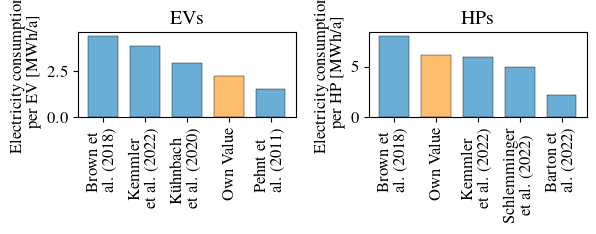

In [217]:
save_dir = "results/plots"
f, (a0, a1) = plt.subplots(1, 2, figsize=(6, 2.5), gridspec_kw={'width_ratios': [1, 1]})
colors_ev = get_colors(energy_ev_comparison)
colors_hp = get_colors(energy_hp_comparison)
df_plot = energy_ev_comparison.sort_values('relative consumption', ascending=False)
df_plot["relative consumption"].plot.bar(ax=a0, color=[colors_ev[bar] for bar in df_plot.index], width=0.7, 
                                         edgecolor="k", linewidth=0.3)
df_plot = energy_hp_comparison.sort_values('relative consumption', ascending=False)
df_plot["relative consumption"].plot.bar(ax=a1, color=[colors_hp[bar] for bar in df_plot.index], width=0.7, 
                                         edgecolor="k", linewidth=0.3)
#a0.set_xlabel("")
#a1.set_xlabel("")
a0.set_title("EVs")
a1.set_title("HPs")
a1.set_ylabel("Electricity consumption\n~~~~~~per HP [MWh/a]")
a0.set_ylabel("Electricity consumption\n~~~~~~per EV [MWh/a]")
#a1.set_yticklabels([])
a0.set_xticklabels(a0.get_xticklabels(), rotation=90)
a1.set_xticklabels(a1.get_xticklabels(), rotation=90)
plt.tight_layout()
save_dir_tmp = os.path.join(save_dir, "paper_dc_input_consumption_evs_and_hps.pdf")
#plt.savefig(save_dir_tmp)

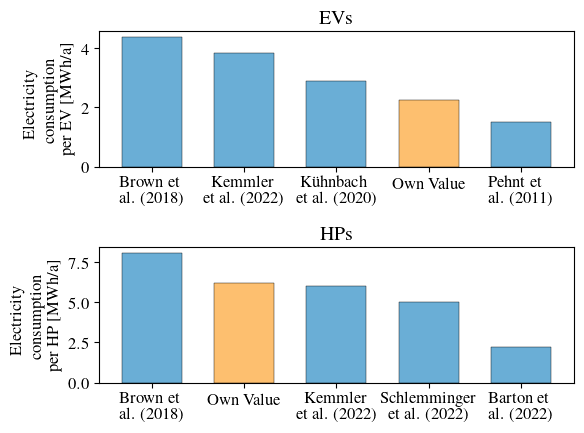

In [231]:
save_dir = "results/plots"
f, (a0, a1) = plt.subplots(2,1, figsize=(6, 4.5))
colors_ev = get_colors(energy_ev_comparison)
colors_hp = get_colors(energy_hp_comparison)
df_plot = energy_ev_comparison.sort_values('relative consumption', ascending=False)
df_plot["relative consumption"].plot.bar(ax=a0, color=[colors_ev[bar] for bar in df_plot.index], width=0.65, 
                                         edgecolor="k", linewidth=0.3)
df_plot = energy_hp_comparison.sort_values('relative consumption', ascending=False)
df_plot["relative consumption"].plot.bar(ax=a1, color=[colors_hp[bar] for bar in df_plot.index], width=0.65, 
                                         edgecolor="k", linewidth=0.3)
#a0.set_xlabel("")
#a1.set_xlabel("")
a0.set_title("EVs")
a1.set_title("HPs")
a1.set_ylabel("~~~~Electricity\n~~~consumption\nper HP [MWh/a]")
a0.set_ylabel("~~~~Electricity\n~~~consumption\nper EV [MWh/a]")
#a1.set_yticklabels([])
a0.set_xticklabels(a0.get_xticklabels(), rotation=0)
a1.set_xticklabels(a1.get_xticklabels(), rotation=0)
plt.tight_layout()
save_dir_tmp = os.path.join(save_dir, "paper_dc_input_consumption_evs_and_hps.pdf")
plt.savefig(save_dir_tmp)

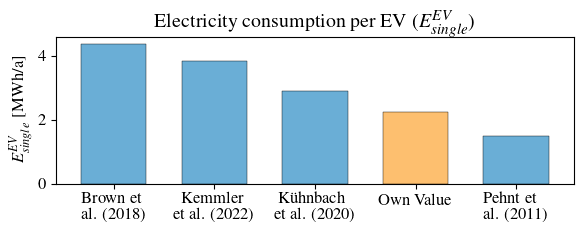

In [17]:
save_dir = "results/plots"
f, (a0) = plt.subplots(1,1, figsize=(6, 2.5))
colors_ev = get_colors(energy_ev_comparison)
colors_hp = get_colors(energy_hp_comparison)
df_plot = energy_ev_comparison.sort_values('relative consumption', ascending=False)
df_plot["relative consumption"].plot.bar(ax=a0, color=[colors_ev[bar] for bar in df_plot.index], width=0.65, 
                                         edgecolor="k", linewidth=0.3)
#a0.set_xlabel("")
#a1.set_xlabel("")
#a0.set_title("EVs")
a0.set_title("Electricity consumption per EV ($E^{EV}_{single}$)")
a0.set_ylabel("$E^{EV}_{single}$ [MWh/a]")
#a1.set_yticklabels([])
a0.set_xticklabels(a0.get_xticklabels(), rotation=0)
plt.tight_layout()
save_dir_tmp = os.path.join(save_dir, "diss_consumption_evs.pdf")
plt.savefig(save_dir_tmp)

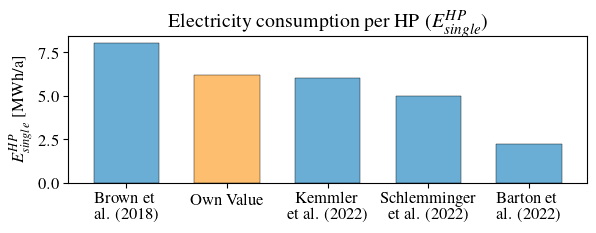

In [100]:
save_dir = "results/plots"
f, (a1) = plt.subplots(1,1, figsize=(6, 2.5))
colors_ev = get_colors(energy_ev_comparison)
colors_hp = get_colors(energy_hp_comparison)
df_plot = energy_hp_comparison.sort_values('relative consumption', ascending=False)
df_plot["relative consumption"].plot.bar(ax=a1, color=[colors_hp[bar] for bar in df_plot.index], width=0.65, 
                                         edgecolor="k", linewidth=0.3)
#a0.set_xlabel("")
#a1.set_xlabel("")
#a0.set_title("EVs")
a1.set_title("Electricity consumption per HP ($E^{HP}_{single}$)")
a1.set_ylabel("$E^{HP}_{single}$ [MWh/a]")
#a1.set_yticklabels([])
a1.set_xticklabels(a1.get_xticklabels(), rotation=0)
plt.tight_layout()
save_dir_tmp = os.path.join(save_dir, "diss_consumption_hps.pdf")
plt.savefig(save_dir_tmp)

In [41]:
energy_ev_comparison = pd.DataFrame(columns=["electricity consumption", "nr_ev_mio"])
energy_ev_comparison.loc["Own Value", "electricity consumption"] = 89.6967
energy_ev_comparison.loc["Own Value", "nr_ev_mio"] = 40
energy_ev_comparison.loc["~ Kemmler\net al. (2022)", "electricity consumption"] = 70
energy_ev_comparison.loc["~ Kemmler\net al. (2022)", "nr_ev_mio"] = 18.2
energy_ev_comparison.loc["Pehnt et\nal. (2011)", "electricity consumption"] = 18
energy_ev_comparison.loc["Pehnt et\nal. (2011)", "nr_ev_mio"] = 12
energy_ev_comparison.loc["~Kühnbach\net al. (2020)", "electricity consumption"] = 2.9
energy_ev_comparison.loc["~Kühnbach\net al. (2020)", "nr_ev_mio"] = 1
energy_ev_comparison.loc["Brown et\nal. (2018)", "electricity consumption"] = 1075
energy_ev_comparison.loc["Brown et\nal. (2018)", "nr_ev_mio"] = 246
energy_ev_comparison.loc["NEP2035", "electricity consumption"] = 51.8
energy_ev_comparison.loc["NEP2035", "nr_ev_mio"] = 15.1

energy_ev_comparison["relative consumption"] = energy_ev_comparison["electricity consumption"]/energy_ev_comparison["nr_ev_mio"]
energy_ev_comparison

electricity consumption nr_ev_mio  \
Own Value                                89.6967        40   
~ Kemmler\net al. (2022)                      70      18.2   
Pehnt et\nal. (2011)                          18        12   
~Kühnbach\net al. (2020)                     2.9         1   
Brown et\nal. (2018)                        1075       246   
NEP2035                                     51.8      15.1   

                         relative consumption  
Own Value                            2.242418  
~ Kemmler\net al. (2022)             3.846154  
Pehnt et\nal. (2011)                      1.5  
~Kühnbach\net al. (2020)                  2.9  
Brown et\nal. (2018)                 4.369919  
NEP2035                              3.430464

In [44]:
correction_nep2035 = pd.DataFrame(columns=["driven_km","consumption_per_km", "nr_ev_mio", "electricity consumption"])
correction_nep2035.loc["E-PKW", "nr_ev_mio"] = 14
correction_nep2035.loc["E-Nutzfahrzeuge", "nr_ev_mio"] = 1
correction_nep2035.loc["E-Schwerlast", "nr_ev_mio"] = 0.1
correction_nep2035.loc["E-PKW", "driven_km"] = 14000
correction_nep2035.loc["E-Nutzfahrzeuge", "driven_km"] = 22000
correction_nep2035.loc["E-Schwerlast", "driven_km"] = 100000
correction_nep2035.loc["E-PKW", "consumption_per_km"] = 0.18
correction_nep2035.loc["E-Nutzfahrzeuge", "consumption_per_km"] = 0.60
correction_nep2035.loc["E-Schwerlast", "consumption_per_km"] = 1.20
correction_nep2035["electricity consumption"] = correction_nep2035["driven_km"]*correction_nep2035["consumption_per_km"]
correction_nep2035

driven_km consumption_per_km nr_ev_mio electricity consumption
E-PKW               14000               0.18        14                  2520.0
E-Nutzfahrzeuge     22000                0.6         1                 13200.0
E-Schwerlast       100000                1.2       0.1                120000.0

In [40]:
energy_hp_comparison = pd.DataFrame(columns=["electricity consumption", "nr_hp_mio"])
energy_hp_comparison.loc["Own Value", "electricity consumption"] = 123.822
energy_hp_comparison.loc["Own Value", "nr_hp_mio"] = 20
energy_hp_comparison.loc["~ Kemmler\net al. (2022)", "electricity consumption"] = 33
energy_hp_comparison.loc["~ Kemmler\net al. (2022)", "nr_hp_mio"] = 5.5
energy_hp_comparison.loc["Barton et\nal. (2022)", "electricity consumption"] = 15.6
energy_hp_comparison.loc["Barton et\nal. (2022)", "nr_hp_mio"] = 7
energy_hp_comparison.loc["Schlemminger\n~ et al. (2022)", "electricity consumption"] = 4.993
energy_hp_comparison.loc["Schlemminger\n~ et al. (2022)", "nr_hp_mio"] = 1
energy_hp_comparison.loc["Brown et\nal. (2018)", "electricity consumption"] = 3585/3.5/529*83
energy_hp_comparison.loc["Brown et\nal. (2018)", "nr_hp_mio"] = 20
energy_hp_comparison.loc["NEP2035", "electricity consumption"] = 22.4
energy_hp_comparison.loc["NEP2035", "nr_hp_mio"] = 7

energy_hp_comparison["relative consumption"] = energy_hp_comparison["electricity consumption"]/energy_hp_comparison["nr_hp_mio"]
energy_hp_comparison

electricity consumption nr_hp_mio  \
Own Value                                     123.822        20   
~ Kemmler\net al. (2022)                           33       5.5   
Barton et\nal. (2022)                            15.6         7   
Schlemminger\n~ et al. (2022)                   4.993         1   
Brown et\nal. (2018)                       160.710235        20   
NEP2035                                          22.4         7   

                              relative consumption  
Own Value                                   6.1911  
~ Kemmler\net al. (2022)                       6.0  
Barton et\nal. (2022)                     2.228571  
Schlemminger\n~ et al. (2022)                4.993  
Brown et\nal. (2018)                      8.035512  
NEP2035                                        3.2